# Text Analysis: 50 yrs. of Magazine Issues
Analysis of 50 years of magazine issues to discover trends in topics addressed over time.

**Author:** [Ryan Parker](https://github.com/rparkr).

**Data source:** Data scraped from magazines of The Church of Jesus Christ of Latter-day Saints from 1971-2021. Starting point: [Church Magazines](https://www.churchofjesuschrist.org/study/magazines?lang=eng).

**Objective**: understand trends in topics addressed through the content of four magazines produced by [The Church of Jesus Christ of Latter-day Saints](https://churchofjesuschrist.org).

In addition to collecting data, I'll analyze the data and implement various machine learning algorithms to understand the data, uncover insights, and make predictions.

## Steps
1. Data collection: Gather data through web scraping, then lightly process it and save it to .csv files.
2. <strong><span style="color:rgb(82, 191, 127)">Topic modeling (this notebook)</strong></span>: assign a topic to each document (article) and label the topics, then append the topic label as a new feature (column) in the dataset.
3. Data augmentation: modify and add additional features (columns) to the dataset to enhance its analysis.
4. Analysis: explore the dataset through visualization, and make predictions using supervised and unsupervised machine learing algorithms.


# Topic modeling
In this notebook, I predict a topic for each magazine article in the dataset based on topics curated from the [Gospel Topics](https://www.churchofjesuschrist.org/study/manual/gospel-topics) reference on [ChurchOfJesusChrist.org](https://www.churchofjesuschrist.org).

This notebook assumes that the .csv files created by the Data Collection notebook exist and are saved in the `data/` directory (relative to where this notebook is saved). In particular, it relies on:
- `data/article_data.csv`
- `data/article_text.csv`
- `data/topics_gt_mod.csv`


# Methodology

In natural language processing (NLP) parlance, each article is a _document_. I implement two methods to classify each document with its main topic.

**Topic assignment**

The first method is my own naïve approach that uses matrix-multiplication to score how similar each document is to each topic. The resulting matrix has n_documents rows by n_topics columns, with similarity scores of each topic to each document. The topic chosen for each document is the one with the highest similarity score. 

The second method uses scikit-learn's Non-Negative Matrix Factorization (`NMF`) algorithm, which performs very well, but takes longer to process. It iterates over the dataset and creates two non-negative matrices: a topic-term matrix (called _H_ and accessed with `nmf_model.components_`) and a document-topic matrix (called _W_) whose product approximates the doc-term matrix _X_ that was passed to it during fitting. The function minimizes the difference between $H \times W$ and $X$, where the loss, that difference, is called _violation_. Each iteration, the algorithm alternates between adjusting _H_ and _W_.

**Labeling each topic**

For both methods, I automatically assign a label to the topic thanks to the topic articles I scraped from _Gospel Topics_, using similarity scores returned by matrix multiplication. In the naïve method, the assigned topic is the argmax across the columns for each row in the doc-topic matrix, which returns the index (column number) of the highest-scoring topic, and that index accesses the topic's label.

For the `NMF` method, I multiply the topic-terms matrix computed by NMF with the transposed doc-terms matrix (where _documents_ are the Gospel Topics articles) to create a topic-topic matrix of size n_topics rows by n_topics columns, where the rows are topics computed by NMF and the columns are the topic articles whose names will be used for labels. The label assigned to each computed topic (i.e., each row) is the argmax across the columns, which returns an index that I use to access the label name (that is, the topic name from the topic articles). Note that this collapses some computed topics by assigning them the same label. Thus, the NMF version will likely have fewer total labeled topics than the naïve method.

**Text preparation**

Prior to computing the topics, I vectorize the documents to create a doc-terms matrix of size n_docs rows by n_terms columns, where each column is the normalized occurence of a term (n-gram) in each document. This simple approach is a modified _bag-of-words_ representation, and it works well for this analysis. An alternative (and more informative) representation would be the use of word _embeddings_, vectors of an arbirtary size that encode information on the similarity of terms after the embedding vectors are trained using a neural network -- but I'll save that exercise for a later analysis.

For efficiency, scikit-learn creates this doc-terms matrix as a `scipy` _sparse_ matrix, since the majority of its values are `0`s (e.g., if there are 50,000 documents and 100,000 terms, each document will likely have a small fraction of the total terms present in the entire corpus, so most of the values in any row will be 0s).

**Background and more info**

I arrived at the methods above after much experimentation with different approaches. You can see my experiments in the "Experiment: ..." sections at the bottom of this notebook.

# Setup

## Import required packages

**Explanation of `sklearn` imports**
- `TfidfVectorizer`: Convert documents to vectors representing the number of times a term (word or n-gram) appeared in each document (its Term Frequency), but weighed based on the relative importance of that term (the Inverse Document Frequency)
- `NMF` and `MiniBatchNMF`: Assign topics to documents after the documents have been vectorized (e.g., by `TfidfVectorizer`). Time complexity increases in polynomial time with respect to the number of inputs, so the `MiniBatchNMF` can perform much faster for large datasets since it uses a default batch size of 1,024 documents compared to the entire set of documents.

In [1]:
# Built-in packages
import random       # sampling
import re           # text-based pattern matching
import time         # measure code execution time
import unicodedata  # Unicode character reference (database on character properties)
                    # for normalizing characters. See also unicodedata2: https://pypi.org/project/unicodedata2/

# Third-party packages
import matplotlib.pyplot as plt   # general plotting library
import numpy as np                # array-based computation
import pandas as pd               # tabular data analysis
from scipy import sparse          # utilities for sparse matrices (returned by TfidfVectorizer)
pd.options.display.precision = 3  # Show 3 decimal places of precision in displayed DataFrames

# scikit-learn feature extraction and estimators
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, MiniBatchNMF

# set_config: Disable HTML display of sklearn objects;
# this way, the text representation is returned
# when an object's __repr__ method is called, like
# when that object is on the last line in a code cell.
from sklearn import set_config
set_config(display='text')

# Function to print code completion time
def print_time(start_time: float) -> None:
    '''Print the completion time for a section of code.
    
    Parameters
    ----------
    start_time: float
        Pass a value from time.perf_counter(), captured
        just before running the function whose time you
        wish to test.
    '''
    end_time = time.perf_counter() - start_time
    # Check if the time was greater than 1 minute
    if (end_time // 60) > 0:
        print(f"Completed in {end_time // 60:,.0f}min {end_time % 60:.1f}s.")
    else:
        print(f"Completed in {end_time:.1f}s.")
    
    return None
        

## Load data
The topic modeling methods in this notebook require data from files produced in the Data Collection notebook. The three files to load are:
- `article_text.csv`: text from ~65k magazine articles.
- `article_data.csv`: author, title, magazine issue, and other info for the ~65k magazine articles. This dataset will hold the columns with predicted topics for each article.
- `topics_[...].csv`: topic articles, used for automatically assigning topic labels in both the naïve and `NMF` methods. Can be one of the following, though I recommend `topics_gt_mod.csv`, curated in the Data Collection notebook.

| Filepath | Description |
|---|---|
| `data/topics_gt_mod.csv` | _Gospel Topics_, newer topical reference, manually modified from `topics_gt.csv` to remove glossary-style topics and consolidate similar topics. 75 topics. |
| `data/topics_gt.csv` | _Gospel Topics_, newer topical reference, 223 topics. Updated ca. 2020. |
| `data/topics_tf.csv` | _True to the Faith_, older topical reference, 108 topics. Updated 2004. |

In [2]:
# Load article_data.csv. Predicted topics will be added as a column to this dataset.
df_article_data = pd.read_csv('data/article_data.csv', low_memory=False)

# Remove articles that don't have text (e.g., section dividers, image-only articles)
df_article_data = df_article_data[df_article_data['word_count'] > 0].reset_index(drop=True)

# Fill missing values in the month column with the last valid value above them.
# This occurs for the December 2017 Special issue of the Liahona.
df_article_data['month'] = df_article_data['month'].fillna(method='pad')

# Load magazine articles
df_text = pd.read_csv('data/article_text.csv').dropna()
# The URL uniquely identifies each article, so we can align article text with other article data using boolean filtering
df_text = df_text[df_text.url.isin(df_article_data.url)].reset_index(drop=True)
print(f"Loaded data for {len(df_text.index):,.0f} articles.")

# Verify that the article text and article data match
assert len(df_article_data.index) == len(df_text.index), "The article text and article data don't match up," \
    " so the assigned topics won't align. Check that the datasets are loaded properly."

# Load topic articles
df_topics = pd.read_csv('data/topics_gt_mod.csv')
num_topics = len(df_topics.index)
print(f"Loaded data for {num_topics:,.0f} topics.")

# Add a word count column for topic articles
if 'word_count' not in df_topics.columns:
    df_topics['word_count'] = df_topics['text'].apply(lambda v: len(v.split()))

# Combine text from magazine and topic articles into a single Series
# to vectorize them together (used in NMF with automatic labeling)
df_text_and_topics = pd.concat([df_text['text'], df_topics['text']], ignore_index=True)

# Verify that the two Series concatenated correctly
assert len(df_text_and_topics.index) == len(df_text.index) + len(df_topics.index), "Uh oh, the concatenation of" \
    + " magazine article text with topic article text didn't work out."

Loaded data for 64,932 articles.
Loaded data for 75 topics.


## Text pre-processing

Function to normalize text (convert Unicode to ASCII equivalents), convert to lowercase, and remove non-alphabetic characters and anything between parentheses (which are often scripture references, based on the content of these magazines).

In [3]:
def preprocess_text(orig_str: str) -> str:
    '''Preprocess text for sklearn's text vectorizers.
    
    Performs the following:
    1. convert all text to lowercase
    2. normalize unicode text to ASCII-equivalent characters
    3. remove punctuation and anything between parentheses

    Return value: str
    '''
    # unidecode is a third-party package for unicode normaliznig
    # that works with most Latin-looking characters and punctuation.
    # new_str = unidecode.unidecode(orig_str.lower())

    # Replace anything inside parentheses (to remove scripture references, which may skew the dataset
    # towards topics like "Doctrine and Covenants")
    new_str = re.sub(pattern=r'\(.+?\)', repl=' ', string=orig_str.lower())

    # Optional: expand contractions (e.g., "you're" -> "you are")
    # Most contractions are stopwords and will be removed by TfidfVectorizer with `stopwords`='english'.
    # See: https://github.com/kootenpv/contractions
    # new_str = contractions.fix(new_str)

    # unicodedata.normalize is Python's built-in normalizing method. 
    # It fails to convert “” to "" and ‘’ to '', but is good enough 
    # for my purposes since I remove those characters anyways.
    # sklearn's TfidfVectorizer also doesn't remove those characters (or numbers, either).
    new_str = unicodedata.normalize(
        'NFKD',
        new_str
    ).encode(encoding='ascii', errors='ignore').decode()

    # Remove digits and punctuation (and anything else besides lowercase a-z and whitespace)
    new_str = re.sub(pattern=r'[^a-z\s]', repl=' ', string=new_str)
    
    # Replace multiple whitespace chars with a single space
    new_str = re.sub(pattern=r'[\s]{2,}', repl=' ', string=new_str)

    return new_str

# Naïve method
This is a fast method that returns a similarity score for each topic to each magazine article, based on the text from the topic articles and magazine articles. The predicted topic for each article is the one with the highest similarity score.

This method provides a decent baseline for topic assignment, but it is limited by the quality of the topic articles. The topic articles were not written with the intent of being compared with magazine articles, so they might lack some words or phrases commonly used for the topic in magazine articles.

The [Advanced method: NMF](#advanced-method-nmf) section below presents an alternate (and potentially more accurate) topic prediction model.

## Text vectorizing

Prior to running the topic models, the text must be _vectorized_: converted into an array of numbers that can be processed by the algorithms to assign a topic for each document.

After experimenting with multiple approaches, I chose to use `sklearn`'s `TfidfVectorizer`, which uses Term Frequency x Inverse Document Frequency (TF-IDF) to create a document-terms matrix of n_documents rows by n_terms columns, where terms are n-grams present in the text _corpus_ (the combined text of all documents). TF-IDF is a method of normalizing term frequency counts, where terms are weighed less if they appear in many documents in the corpus, since that would mean they are less informative for distinguishing one document from another.

For the naïve method, I first create a doc-terms matrix for the topic articles, with a row for each document and a column for each term, the _ngrams_ in those documents (I use unigrams and bigrams); then I use the vocabulary (terms) in that doc-terms matrix to vectorize the magazine articles: that way, only terms present in the topic articles will be considered while all other words will be ignored. Compared with creating the document-terms matrix on all ~65k articles, this method provides two primary benefits:
1. **Significantly reduced memory footprint.** The ~75-220 topic articles have far fewer vocabulary terms than the ~65,000 magazine articles, resulting in a much smaller doc-terms matrix (~30k vs. ~3M terms). The smaller vocabulary list leads to reduced computation time.
2. **More compact representation.** For the naïve method, I simply multiply the magazine articles' doc-terms matrix by the transposed topic articles doc-terms matrix, which means that any vocabulary terms from the magazine articles that were not in the topic articles would become `0s` even if I used the full vocabulary. As such, the method gains no new information from the terms in the magazine articles that are not present in the topic articles.*

*The main drawback of this approach is that the TF-IDF-normalized weights for each term differ slightly compared to using the vocabulary learned from all 65k articles. See the [data/topic_predictions_norm_comparison.xlsx](data/topic_predictions_norm_comparison.xlsx) Excel file for a comparison between the full vocabulary and the vocabulary from only the topic articles. The results are very similar when using the default settings for `TfidfVectorizer`. You can see how I implemented the full-vocabulary version in the Experiments section of this notebook: "🧪 Experiments" > "[Experiment: normalize vectors](#experiment-normalize-vectors)" > "Doc-terms matrix for articles" > "Using the full vocabulary".

**Explanation of `TfidfVectorizer`'s parameters:**  
- `preprocessor`: Function that takes a string, processes it, and returns a string.
- `ngram_range`: The n-grams to use when building the terms vocabulary. `(1, 1)` means unigrams (single words) only. `(1, 2)` means unigrams and bigrams. `(2, 2)` means bigrams only, etc.
- `max_df`: Automatic stopword filtering based on the document frequency (`_df`) of a term. If a term is found in > `max_df` % of documents, it will not be used in the vocabulary but will be added to the stopwords list.
- `min_df`: Automatic stopword filtering based on the document frequency (`_df`) of a term. Can be set to an integer or a float. If an integer and a term is found in < `min_df` # of documents, that term will not be used in the vocabulary but will be added to the stopwords list. If a float and a term is found in < `min_df` % of documents, that term will not be added to the vocabulary.
- `max_features`: The maximum number of terms to use, based on descending order of prevalence. For example, setting `max_features=50_000` will include the 50,000 most-common terms in the vocabulary, ommiting all others.
- `norm`: Normalizing strategy (options: ['l2', 'l1'], default='l2'). L2 norm adjusts weights such that the sum of squared elements of each vector equals 1. L1 norm adjusts weights such that the sum of elements in each vector equals 1. See [data/topic_predictions_norm_comparison.xlsx](data/topic_predictions_norm_comparison.xlsx) for results from using both approaches.
- `stop_words`: List of terms to exclude from the vocabulary. `sklearn` provides a pre-configured list ('english') but stopwords are also created based on the `max_df` and `min_df` settings.

In [5]:
tfidf = TfidfVectorizer(
    preprocessor = preprocess_text,
    ngram_range = (1, 2),
    max_df = 0.95,
    # min_df = 2,  # min_df is not needed since a word present in a single topic is useful for uniquely identifying that topic
    # dtype = np.float32,  # default is np.float64, set to np.float32 to reduce memory usage at the expense of precision
    stop_words = 'english'
)

print(f"Creating the doc-terms matrix for {len(df_topics.index):,.0f} topic articles...")
t0 = time.perf_counter()
dtm_topics = tfidf.fit_transform(df_topics['text'])  # The text from 75 topic articles
print_time(t0)

print(f"Doc-terms matrix shape: {dtm_topics.shape} (# docs, # terms)")
print(f"Approximate size in memory: {dtm_topics.data.nbytes/1_000_000:,.2f}MB")

# Check number of terms (ngrams) added to stopwords (usually
# because they appeared in only one document when min_df is set to 2).
if len(tfidf.stop_words_) < 100:
    if tfidf.stop_words_ == set():
        print("Default stopwords list used, no new terms added.")
        # Show default stopwords list:
        # print(tfidf.get_stop_words())
    else:
        print(f"Words added to stopwords list:\n{tfidf.stop_words_}")
else:
    print(f"Number of terms added to stopword list: {len(tfidf.stop_words_):,.0f}")

Creating the doc-terms matrix for 75 topic articles...
Completed in 0.5s.
Doc-terms matrix shape: (75, 33024) (# docs, # terms)
Approximate size in memory: 0.41MB
Default stopwords list used, no new terms added.


## Topic prediction
Each magazine article is scored based on similarity to each of the topics. The topic with the highest score is used as the predicted topic, though any number of top scores could be selected for assigning multiple topics to an article.

The scoring happens via matrix multiplication of the magazine articles' doc-terms matrix with the topic articles' (transposed) doc-terms matrix.

In [6]:
tfidf_docs = TfidfVectorizer(
    preprocessor = preprocess_text,
    ngram_range = (1,2),
    stop_words = 'english',
    # dtype = np.float32,  # default is np.float64, set to np.float32 to reduce memory usage at the expense of precision
    vocabulary = tfidf.vocabulary_  # the vocabulary learned from the topic articles' doc-terms matrix
)

print(f"Vectorizing {len(df_text.index):,.0f} magazine articles into a doc-terms matrix...")
t0 = time.perf_counter()
dtm_docs = tfidf_docs.fit_transform(df_text['text'])  # The text from ~65,000 magazine articles
print_time(t0)

# # Uncomment this section to normalize the topic vectors
# # and reduce the impact of word count on topic prediction.
# print('Normalizing the topics...')
# t0 = time.perf_counter()
# # Implicitly converts to dense format, which causes out-of-memory errors on larger arrays (like dtm_docs).
# dtm_topics = dtm_topics.power(2) / dtm_topics.max(axis=1).toarray()  # squared first, then mini-max normalized
# print_time(t0)

print("Scoring the topics by multiplying the doc-terms matrix by the topic-terms matrix...")
t0 = time.perf_counter()
doc_topic_similarity = dtm_docs @ dtm_topics.transpose()  # Matrix multiplication using the @ operator
print_time(t0)

# There are 29 magazine articles that have no words in common with the topic articles,
# which means that the argmax() across columns will be 0, assigning the topic at index 0: "Addiction".
# To avoid selecting a topic for those articles, I use filtering to set them to np.NaN.
max_vals = doc_topic_similarity.max(axis=1).toarray().flatten()

# Find the most similar topic for each document. 
# doc_topic_similarity is a scipy.csr_matrix,
# whose .argmax() method returns a 2-D numpy.matrix object,
# which I convert to a standard numpy.array object, then flatten to 1 dimension.
print("Selecting the highest-scoring topic for each article...")
t0 = time.perf_counter()
topic_labels = df_topics['topic'].values
pred_topic_idxs = np.array(doc_topic_similarity.argmax(axis=1)).flatten()
pred_topic_labels = pd.Series(pred_topic_idxs, name='topic_naive').apply(lambda idx_val: topic_labels[idx_val])
# Clear predictions where there was no information to predict from (because the magazine articles didn't share any words in common with any of the topic articles)
pred_topic_labels[max_vals == 0] = np.NaN
# Resetting the index ensures proper alignment when concatenated
df_article_topics = pd.concat([df_article_data.reset_index(drop=True), pred_topic_labels], axis=1)
print_time(t0)

# To verify proper alignment, check that the URLs for each row are the same:
# print((df_article_data.url == df_text.url).value_counts())
# print((df_article_data.url == df_article_topics.url).value_counts())

Vectorizing 64,932 magazine articles into a doc-terms matrix...
Completed in 2min 27.5s.
Scoring the topics by multiplying the doc-terms matrix by the topic-terms matrix...
Completed in 1.1s.
Selecting the highest-scoring topic for each article...
Completed in 0.8s.


In [6]:
# Save the predicted topics along with other article data
df_article_topics.to_csv('data/article_data_with_topics.csv', index=False)

# View a sample of predicted topics (filtered to articles with a summary for added context)
df_article_topics[~df_article_topics.summary.isna()] \
    [['magazine', 'issue', 'section', 'title', 'summary', 'topic_naive']] \
    .sample(10, random_state=0)  # or .head(10) for the first rows

magazine           issue                   section  \
4591   Liahona        May 2014  Saturday Morning Session   
56480   Friend    October 2004                   Funstuf   
41570  New Era     August 2009                   general   
49259   Friend      April 2021                   general   
20886   Ensign   November 2009                   general   
34658   Ensign    October 1979                   general   
43671  New Era   December 2001                   general   
49439   Friend  September 2021                   general   
21352   Ensign   November 2008                   general   
17636   Ensign   November 2016  Saturday Morning Session   

                                                   title  \
4591                   The Joyful Burden of Discipleship   
56480  Poster Article: Prophets Teach Me to Strengthe...   
41570                                            Charity   
49259                   Meet Shiloh from the Philippines   
20886                          Teaching Helps Save Lives   
34658               The Importance of Celestial Marriage   
43671                                  Doorstep Nativity   
49439                               Church History Cards   
21352                       Winning the War against Evil   
17636                  Am I Good Enough? Will I Make It?   

                                                 summary          topic_naive  
4591   To sustain our leaders is a privilege; it come...              Service  
56480  What I the Lord have spoken, I have spoken, … ...               Family  
41570  Charity and Christlike love were taught and ex...              Charity  
49259  Meet Primary children helping others, like Jes...            Parenting  
20886  We teach key doctrine, invite learners to do t...  Teaching the Gospel  
34658  From addresses delivered 22 October 1976 at th...             Marriage  
43671  This family Christmas tradition started on a d...            Christmas  
49439  Cut out the cards, fold on the dotted line, an...       Book of Mormon  
21352  You were entrusted to come to the earth in the...    Plan of Salvation  
17636  If you will really try and will not rationaliz...           Repentance

In [87]:
# For comparing this to prior approaches, run the code below
# and add it to a worksheet in data/topic_predictions_norm_comparison.xlsx

# df_article_topics[['issue', 'topic_naive']].groupby(by='topic_naive').count() \
#     .sort_values(by='issue', ascending=False) \
#     .to_csv('experiments/topic_assignments_aligned.csv')

## Tagging: top 5 topics
The section above predicts a single topic for each magazine article, but it is likely that an article could have multiple topics. This section finds the top 5 topics for each article. You can think of this method as tagging each magazine article, where the tags are the most-similar topics to the article.

> 💡 Tip: The code in this section creates the `tags_naive` `Series` with a list of tags in each row. You can expand that list into rows using the `pandas.DataFrame.explode()` method.

In [7]:
# Get the indices of the 5 most-similar topics, and sort them in descending order
sorted_indices = np.argsort(doc_topic_similarity.toarray(), axis=1)[:, -1:-6:-1]
sorted_scores = np.sort(doc_topic_similarity.toarray(), axis=1)[:, -1:-6:-1]
# Avoid a zero-division error by setting rows with all 0s to 1s
sorted_scores[max_vals == 0, :] = 1
# Normalize by the most-similar topic. np.newaxis aligns the row vector
# as a column vector for the division operation.
# I also convert this to a float64 data type so it can be properly rounded
# even after being passed to DataFrame.to_dict().
# See: https://github.com/pandas-dev/pandas/issues/50213
normalized_scores = np.array(sorted_scores / sorted_scores.max(axis=1)[:, np.newaxis], dtype='float64').round(3)
 
# Translate the scores and indices into a DataFrame
df_top5_topics = pd.DataFrame(data=sorted_indices, columns=[f"topic_{n}" for n in range(1, 6)]).applymap(lambda idx_val: topic_labels[idx_val])
df_top5_scores = pd.DataFrame(data=sorted_scores, columns=[f"similarity_score_{n}" for n in range(1, 6)])
df_top5_normalized_scores = pd.DataFrame(data=normalized_scores, columns=[f"normalized_score_{n}" for n in range(1, 6)])

df_top5 = pd.concat([df_article_data['url'], df_top5_topics, df_top5_normalized_scores, df_top5_scores], axis=1)

# Clear predictions where there was no information to predict from (because the magazine articles didn't share any words in common with any of the topic articles)
df_top5.iloc[max_vals == 0, 1:] = np.NaN

# Add tag information to the rest of the article data
df_article_topics_with_tags = pd.concat([
    df_article_topics,
    pd.Series(df_top5.loc[:, 'topic_1':'topic_5'].to_dict(orient='split')['data'], name='tags_naive'), 
    pd.Series(df_top5.loc[:, 'normalized_score_1':'normalized_score_5'].to_dict(orient='split')['data'], name='tag_scores_naive')
    ], axis = 1
)

# Save tag data
df_article_topics_with_tags.to_csv('data/article_data_with_topics_and_tags.csv', index=False)

# Save tag info as a standalone file
df_top5.to_csv('data/articles_top5_topics_naive_method.csv', index=False)

# View the article topics with tags and tag scores (copied to cell below)
# df_article_topics_with_tags[~df_article_topics.summary.isna()] \
#     [['magazine', 'issue', 'section', 'title', 'summary', 'word_count', 'tags_naive', 'tag_scores_naive']] \
#     .sample(10, random_state=0)

# View the same sample of data as the main topics, above
df_top5[~df_article_topics.summary.isna()].sample(10, random_state=0)

url              topic_1  \
4591   https://www.churchofjesuschrist.org/study/liah...              Service   
56480  https://www.churchofjesuschrist.org/study/frie...               Family   
41570  https://www.churchofjesuschrist.org/study/new-...              Charity   
49259  https://www.churchofjesuschrist.org/study/frie...            Parenting   
20886  https://www.churchofjesuschrist.org/study/ensi...  Teaching the Gospel   
34658  https://www.churchofjesuschrist.org/study/ensi...             Marriage   
43671  https://www.churchofjesuschrist.org/study/new-...            Christmas   
49439  https://www.churchofjesuschrist.org/study/frie...       Book of Mormon   
21352  https://www.churchofjesuschrist.org/study/ensi...    Plan of Salvation   
17636  https://www.churchofjesuschrist.org/study/ensi...           Repentance   

                                                 topic_2  \
4591   Diversity and Unity in The Church of Jesus Chr...   
56480                          Restoration of the Church   
41570                                               Love   
49259                                             Family   
20886                              Faith in Jesus Christ   
34658                                  Plan of Salvation   
43671                                             Family   
49439                                         Scriptures   
21352                          Agency and Accountability   
17636                          Atonement of Jesus Christ   

                                                 topic_3  \
4591                                   Plan of Salvation   
56480  Diversity and Unity in The Church of Jesus Chr...   
41570  Diversity and Unity in The Church of Jesus Chr...   
49259                                            Baptism   
20886                                  Plan of Salvation   
34658                                  Kingdoms of Glory   
43671                                    Spiritual Gifts   
49439  Diversity and Unity in The Church of Jesus Chr...   
21352                              Faith in Jesus Christ   
17636                                  Plan of Salvation   

                                                 topic_4  \
4591                                            Prophets   
56480                              Faith in Jesus Christ   
41570                                  Plan of Salvation   
49259  Diversity and Unity in The Church of Jesus Chr...   
20886                                          Parenting   
34658  Diversity and Unity in The Church of Jesus Chr...   
43671                                     Family History   
49439                                          Testimony   
21352                          Atonement of Jesus Christ   
17636                                        Forgiveness   

                                                 topic_5  normalized_score_1  \
4591                                 Teaching the Gospel                 1.0   
56480                                  Plan of Salvation                 1.0   
41570                                       Joseph Smith                 1.0   
49259                                            Temples                 1.0   
20886  Diversity and Unity in The Church of Jesus Chr...                 1.0   
34658                                           Covenant                 1.0   
43671                         Fasting and Fast Offerings                 1.0   
49439                          Restoration of the Church                 1.0   
21352                                       Jesus Christ                 1.0   
17636                              Faith in Jesus Christ                 1.0   

       normalized_score_2  normalized_score_3  normalized_score_4  \
4591                0.854               0.839               0.704   
56480               0.694               0.662               0.623   
41570               0.645               0.443               0.417   
49259               0

In [8]:
# View the article topics with tags and tag scores
df_article_topics_with_tags[~df_article_topics.summary.isna()] \
    [['magazine', 'issue', 'section', 'title', 'summary', 'word_count', 'tags_naive', 'tag_scores_naive']] \
    .sample(10, random_state=0)

magazine           issue                   section  \
4591   Liahona        May 2014  Saturday Morning Session   
56480   Friend    October 2004                   Funstuf   
41570  New Era     August 2009                   general   
49259   Friend      April 2021                   general   
20886   Ensign   November 2009                   general   
34658   Ensign    October 1979                   general   
43671  New Era   December 2001                   general   
49439   Friend  September 2021                   general   
21352   Ensign   November 2008                   general   
17636   Ensign   November 2016  Saturday Morning Session   

                                                   title  \
4591                   The Joyful Burden of Discipleship   
56480  Poster Article: Prophets Teach Me to Strengthe...   
41570                                            Charity   
49259                   Meet Shiloh from the Philippines   
20886                          Teaching Helps Save Lives   
34658               The Importance of Celestial Marriage   
43671                                  Doorstep Nativity   
49439                               Church History Cards   
21352                       Winning the War against Evil   
17636                  Am I Good Enough? Will I Make It?   

                                                 summary  word_count  \
4591   To sustain our leaders is a privilege; it come...      1423.0   
56480  What I the Lord have spoken, I have spoken, … ...       519.0   
41570  Charity and Christlike love were taught and ex...       260.0   
49259  Meet Primary children helping others, like Jes...       185.0   
20886  We teach key doctrine, invite learners to do t...      1578.0   
34658  From addresses delivered 22 October 1976 at th...      3096.0   
43671  This family Christmas tradition started on a d...       299.0   
49439  Cut out the cards, fold on the dotted line, an...       139.0   
21352  You were entrusted to come to the earth in the...      1655.0   
17636  If you will really try and will not rationaliz...      1576.0   

                                              tags_naive  \
4591   [Service, Diversity and Unity in The Church of...   
56480  [Family, Restoration of the Church, Diversity ...   
41570  [Charity, Love, Diversity and Unity in The Chu...   
49259  [Parenting, Family, Baptism, Diversity and Uni...   
20886  [Teaching the Gospel, Faith in Jesus Christ, P...   
34658  [Marriage, Plan of Salvation, Kingdoms of Glor...   
43671  [Christmas, Family, Spiritual Gifts, Family Hi...   
49439  [Book of Mormon, Scriptures, Diversity and Uni...   
21352  [Plan of Salvation, Agency and Accountability,...   
17636  [Repentance, Atonement of Jesus Christ, Plan o...   

                        tag_scores_naive  
4591   [1.0, 0.854, 0.839, 0.704, 0.701]  
56480  [1.0, 0.694, 0.662, 0.623, 0.592]  
41570  [1.0, 0.645, 0.443, 0.417, 0.415]  
49259   [1.0, 0.621, 0.584, 0.531, 0.47]  
20886  [1.0, 0.821, 0.796, 0.641, 0.585]  
34658  [1.0, 0.494, 0.483, 0.477, 0.444]  
43671   [1.0, 0.34, 0.227, 0.224, 0.221]  
49439  [1.0, 0.802, 0.468, 0.408, 0.377]  
21352  [1.0, 0.808, 0.697, 0.637, 0.637]  
17636   [1.0, 0.82, 0.798, 0.662, 0.596]

### Tags dataset
Create an "exploded" version of the tags for visualization and analysis, where each row of the dataset is the count of articles tagged with a given topic for a certain month and year of a magazine. That is, the count is the number of times a tag appeared across all articles from one month of a particular magazine.

In [10]:
df_article_topics_with_tags = pd.read_csv('data/article_data_with_topics_and_tags.csv') \
    .loc[:, ['url', 'magazine', 'year', 'month', 'tags_naive', 'tag_scores_naive']]

# Convert the string (['tag1', ..., 'tag5']) into a list using .split()
# then use .explode() to move each item in the list to a new row
# then replace the symbols leftover from the list and string syntax ("[]" and "'")
df_article_topics_with_tags['tags_naive'] = df_article_topics_with_tags['tags_naive'].str.split(', ')
df_article_topics_with_tags['tag_scores_naive'] = df_article_topics_with_tags['tag_scores_naive'].str.split(', ')
df_article_topics_with_tags = df_article_topics_with_tags.explode(column=['tags_naive', 'tag_scores_naive'], ignore_index=True)
df_article_topics_with_tags['tags_naive'] = df_article_topics_with_tags['tags_naive'] \
    .str.replace(r"'|\[|\]", "", regex=True)
df_article_topics_with_tags['tag_scores_naive'] = df_article_topics_with_tags['tag_scores_naive'] \
    .str.replace(r"\[|\]", "", regex=True)

df_article_topics_with_tags = df_article_topics_with_tags.rename(columns={'tags_naive': 'tag', 'tag_scores_naive': 'tag_score'})

# You can save the unaggregated data: it has 5 rows per article, or ~325k records (5 * 65K)
# df_article_topics_with_tags.to_csv('experiments/tag_scores.csv', index=False)

# I left out the "url" column from grouping so it can be used for counts
# and I excluded the scores since grouping by the scores would expand beyond 
# the level desired for grouping (one record per magazine-year-month-topic)
df_tag_counts = df_article_topics_with_tags[['url', 'magazine', 'year', 'month', 'tag']].groupby(
    by=['magazine', 'year', 'month', 'tag']).count()

df_tag_counts = df_tag_counts.rename(columns={'url': 'num_articles'})

# Normalize based on total number of tags in a given month for each magazine. Otherwise, some of 
# the trends will just be patterns of increasing number of articles per magazine over the years.
# Technique adapted from: https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby/23377232#23377232
df_tag_counts['pct_articles'] = df_tag_counts['num_articles'] / df_tag_counts.groupby(['magazine', 'year', 'month'])['num_articles'].transform('sum')

# Sort in proper month order
df_tag_counts = df_tag_counts.reset_index()
df_tag_counts['date'] = pd.to_datetime(df_tag_counts.year.astype(str) + '-' + df_tag_counts.month)
df_tag_counts = df_tag_counts.sort_values(by=['magazine', 'date'], ascending=True)[['magazine', 'year', 'month', 'date', 'tag', 'num_articles', 'pct_articles']]

df_tag_counts.to_csv('data/tag_counts_by_month_year.csv', index=False)

df_tag_counts.tail(35)

magazine  year     month       date  \
91869  New Era  2020  November 2020-11-01   
91870  New Era  2020  November 2020-11-01   
91601  New Era  2020  December 2020-12-01   
91602  New Era  2020  December 2020-12-01   
91603  New Era  2020  December 2020-12-01   
91604  New Era  2020  December 2020-12-01   
91605  New Era  2020  December 2020-12-01   
91606  New Era  2020  December 2020-12-01   
91607  New Era  2020  December 2020-12-01   
91608  New Era  2020  December 2020-12-01   
91609  New Era  2020  December 2020-12-01   
91610  New Era  2020  December 2020-12-01   
91611  New Era  2020  December 2020-12-01   
91612  New Era  2020  December 2020-12-01   
91613  New Era  2020  December 2020-12-01   
91614  New Era  2020  December 2020-12-01   
91615  New Era  2020  December 2020-12-01   
91616  New Era  2020  December 2020-12-01   
91617  New Era  2020  December 2020-12-01   
91618  New Era  2020  December 2020-12-01   
91619  New Era  2020  December 2020-12-01   
91620  New Era  2020  December 2020-12-01   
91621  New Era  2020  December 2020-12-01   
91622  New Era  2020  December 2020-12-01   
91623  New Era  2020  December 2020-12-01   
91624  New Era  2020  December 2020-12-01   
91625  New Era  2020  December 2020-12-01   
91626  New Era  2020  December 2020-12-01   
91627  New Era  2020  December 2020-12-01   
91628  New Era  2020  December 2020-12-01   
91629  New Era  2020  December 2020-12-01   
91630  New Era  2020  December 2020-12-01   
91631  New Era  2020  December 2020-12-01   
91632  New Era  2020  December 2020-12-01   
91633  New Era  2020  December 2020-12-01   

                                                     tag  num_articles  \
91869                                Women in the Church             2   
91870                                            Worship             1   
91601                          Atonement of Jesus Christ             4   
91602                                            Baptism             1   
91603                                              Bible             1   
91604                                     Book of Mormon             2   
91605                                            Charity             1   
91606                                          Christmas             7   
91607                                           Covenant             1   
91608  Diversity and Unity in The Church of Jesus Chr...             5   
91609                             Emergency Preparedness             1   
91610                                       Eternal Life             2   
91611                              Faith in Jesus Christ            14   
91612                                             Family             3   
91613                                     Family History             1   
91614                         Fasting and Fast Offerings             1   
91615                                        Forgiveness             1   
91616                                              Grief             1   
91617                                             Health             1   
91618                                   Heavenly Parents             1   
91619                                         Holy Ghost             7   
91620                                               Hope             4   
91621                                       Jesus Christ             2   
91622                                       Joseph Smith             2   
91623                                              Media             1   
91624                                  Plan of Salvation            16   
91625                                             Prayer             4   
91626                                         Priesthood             2   
91627                          Restoration of the Church             2   
91628                                         Scriptures             3   
91629                                      Self-Reliance             1   
91630            

# Method: `NMF`
The Non-Negative Matrix Factorization (`NMF`) algorithm creates a document-topic matrix and a topic-terms matrix whose product approximates the doc-terms matrix created by, for example, `TfidfVectorizer`. It does so iteratively: each round, the algorithm alternates between adjusting the topic-terms matrix and the document-topic matrix. I use the document-topic matrix for the predicted topic for each magazine article, and I use the topic-terms matrix to understand what each topic is.

The loss (or minimizing objective) of this algorithm is called _violation_, which is printed out in each iteration with the `verbose=1` setting (helpful for watching training progress over time).

**Naming the topics**  
`NMF` creates topics, but doesn't assign them a name. Topics can be manually labeled from the topic-terms matrix by reviewing the top terms for each topic, or they can be automatically assigned by:
- using similarity scores between the NMF-computed topic-terms matrix and the topic articles' document-terms matrix (similar to the naïve method)
- using the most influential term for a given topic as its label
- comparing synomyns for the top terms in each topic to find a common synonym for the topic label (e.g., using `NLTK`'s `WordNet` `synset`s, or sets of hierarchical synonyms)

**Timing**  
`NMF` time complexity increases in polynomial time with respect to the _number of components_. When using `n_components = 20` and a doc-terms matrix of shape `(64_932, 50_000)`, the `.fit()` method completed in ~6min.

My laptop has a 5th-gen Intel Core i5-5200U dual-core CPU rated at 2.20GHz. Using `n_components = 158` (i.e., number of topics), my laptop ran 200 iterations of `NMF.fit()` in about **12 minutes** on a scipy CSR sparse matrix of shape ~`(1_000, 50_000)`. The `MiniBatchNMF` on that dataset completed 200 iterations in about **14 minutes**. I chose to `.fit()` the model (which creates the topic-terms matrix) using a ~1,000-row sample of the dataset, then used the `.transform()` method on the full dataset to create the doc-topics matrix (takes <1 min). To converge the loss below the default threshold of 1e-4—or .0001—required around 300-500 iterations.

For more information on the timing and performance of `NMF` and `MiniBatchNMF`, see the [Experiment: real data, topic modeling](#experiment-real-data-topic-modeling) section of this notebook. That section also has information on the number of vocabulary terms using different settings for vectorizer parameters (e.g., changing `ngram_range`, `max_df`, and `min_df`). One takeaway is that **there are only ~27,000 unique words** across the 65,000 magazine articles; the rest of the ~7M terms are bigrams, and ~4M of those bigrams appear in only one article.

**Notes**
- I used the default settings for NMF except I set `init='nndsvda'`, which is the initialization strategy used for MiniBatchNMF and is the setting that [scikit-learn used in the example code](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html) comparing NMF to MiniBatchNMF and LDA.
- I fit the model with the topic articles appended to the end of the magazine articles, which might help with topic prediction and which enables a comparison of `NMF`'s predicted topic for each topic article (kind of like a calibration measurement).

## Text vectorizing
The `NMF` algorithm is more memory and computation intensive than the naïve method, so I limit the vocabulary size to 50,000 terms when creating the doc-terms matrix. Note that there are only ~27,000 unique words across all 65,000 magazine articles. All other vocabulary terms come from bigrams.

In [4]:
tfidf_nmf = TfidfVectorizer(
    preprocessor = preprocess_text,
    ngram_range = (1, 2),
    max_df = 0.95,
    min_df = 2,
    max_features = 50_000,  # set max vocabulary size; only the most common terms will be included
    stop_words = 'english',
    dtype = np.float32  # default is np.float64. Set to np.float32 to reduce memory usage 
                        # at the expense of precision. Also reduces computation time for some
                        # operations, like NMF.fit()
)

print(f"Creating the doc-terms matrix for {len(df_text_and_topics.index):,.0f} magazine and topic articles...")
t0 = time.perf_counter()
dtm_nmf = tfidf_nmf.fit_transform(df_text_and_topics)  # The text of ~65k magazine articles plus 75 topic articles
print_time(t0)

Creating the doc-terms matrix for 65,007 magazine and topic articles...
Completed in 3min 47.8s.


In [5]:
print(f"Doc-terms matrix shape: {dtm_nmf.shape} (# docs, # terms)")
print(f"Approximate size in memory: {dtm_nmf.data.nbytes/1_000_000:,.2f}MB")

# Check number of terms (ngrams) added to stopwords (usually
# because they appeared in only one document when min_df is set to 2).
if len(tfidf_nmf.stop_words_) < 100:
    if tfidf_nmf.stop_words_ == set():
        print("Default stopwords list used, no new terms added.")
        # Show default stopwords list:
        # print(tfidf_nmf.get_stop_words())
    else:
        print(f"Words added to stopwords list:\n{tfidf_nmf.stop_words_}")
else:
    print(f"Number of terms added to stopword list: {len(tfidf_nmf.stop_words_):,.0f}")

Doc-terms matrix shape: (65007, 50000) (# docs, # terms)
Approximate size in memory: 77.36MB
Number of terms added to stopword list: 7,008,944


## Manual labels
Here, I run NMF to create 20 topics, which I then manually label based on the top terms for each topic.

### Key takeaways
- **The naive method produces perceptually more accurate results than this manually-labeled NMF approach**, often driven by specificity of topics.
- The hardest-to-guess topics are among the most common, leading to somewhat-confusing labels (e.g., what I labeled as "Scriptures" could probably be generally categorized as "Words of God," and any article with heavy use of scripture references may receive that category rather than a more specific topic)
  - This effect suggests that 20 is too few topics and a larger number of topics might produce better categories.
- Some topics found by NMF are not captured by the Gospel Topics articles in the naive method; e.g., "Crafts" or "Food"

### Topic-terms matrix
`nmf.fit(doc_terms_matrix)` creates the topic-terms matrix and stores it in `nmf.components_`. The topic-terms matrix holds the scores for each term to each topic, which can be used to interpret the topics.

The algorithm will stop before the `max_iter` number of iterations if the loss (called `violation`) goes below a threshold (default of 0.0001).

**Approximate timing**  
Using the `np.float32` data type, 20 topics, and a doc-terms matrix of `(5000, 50000)`, `NMF.fit()` converged in 57s after 166 iterations.  
With a doc-terms matrix of `(64932, 50000)`, the model converged in 6m 9s after 94 iterations.

In [15]:
# In the line below slicing ([:-num_topics, ...]) excludes the final 75 rows, 
# which are topic articles (not magazine articles). The topic articles are used for automatic labeling.
print(f"Fitting the NMF model on {dtm_nmf[:-num_topics, :].shape[0]:,.0f} articles to create the topic-terms matrix...")
t0 = time.perf_counter()
nmf = NMF(n_components=20, verbose=1, max_iter=1_000)
nmf.fit(dtm_nmf[:-num_topics, :])
# Or, to fit topic-term matrix and doc-topic matrix at the same time, use nmf.fit_transform()
# nmf_doc_topics = nmf.fit_transform(dtm_nmf[:-num_topics, :])
print('=' * 50, '\n', 'DONE'.center(50, ' '), '\n', '=' * 50, sep='')
print_time(t0)

Fitting the NMF model on 64,932 articles to create the topic-terms matrix...
violation: 1.0
violation: 0.21423723241447867
violation: 0.1437563924944303
violation: 0.10506097180447391
violation: 0.08325854222988816
violation: 0.06799878643237765
violation: 0.0552380997580482
violation: 0.045424777836829376
violation: 0.0378918572459655
violation: 0.031743885320427656
violation: 0.026744847658269517
violation: 0.022820972208871783
violation: 0.01985782249473309
violation: 0.017554938620239907
violation: 0.01587447784394579
violation: 0.014645720785011338
violation: 0.013692893089254605
violation: 0.012967546320820039
violation: 0.012368891603509794
violation: 0.011827500594623596
violation: 0.011313405928649711
violation: 0.010782120305227433
violation: 0.010230020831918025
violation: 0.00964257474543802
violation: 0.009050495598572107
violation: 0.008418012014429843
violation: 0.0077546481078544895
violation: 0.007080998932656005
violation: 0.006416194392887188
violation: 0.00578531742

### Topic prediction
Use the `nmf.transform()` method to create a doc-topic matrix, with similarity scores for each topic to each magazine article.

Note: if you ran `nmf.fit_transform(doc_topics_matrix)` in the previous step, this step isn't necessary. Only use if you ran just `nmf.fit(doc_topics_matrix)` in the previous step.

In [16]:
print("Scoring topics for all magazine articles based on the fitted NMF model...")
t0 = time.perf_counter()
nmf_doc_topics = nmf.transform(dtm_nmf)
print_time(t0)

Scoring topics for all magazine articles based on the fitted NMF model...
violation: 1.0
violation: 0.3856292315221904
violation: 0.05764529916741811
violation: 0.011260081398615103
violation: 0.003614850698659256
violation: 0.000739290274318568
violation: 0.00019113676868224422
violation: 6.521399417605211e-05
Converged at iteration 9
Completed in 23.8s.


### Topic labeling
To label each of the 20 computed topics, I plot the top terms for each topic using code adapted from the scikit-learn example: [Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html "A scikit-learn tutorial comparing NMF, MiniBatchNMF, and LDA").

I then choose a label for each topic that seems to fit its top terms, weighing my judgment based on the scores of the terms for the topic.

In [10]:
def plot_top_words(model, feature_names, n_topics, n_top_words, title, randomize=False):
    """Plot a bar chart showing the score of each term on each topic computed
    by one of the sklearn.decomposition estimators (e.g., NMF, LatentDirichletAllocation).
    """
    cols = 5
    rows = n_topics // cols
    if rows * cols < n_topics: rows += 1
    fig, axes = plt.subplots(rows, cols, figsize=(30, 7.5 * rows), sharex=True)
    axes = axes.flatten()
    if randomize:
        idxs = random.sample(list(range(len(model.components_))), n_topics)
    else:
        idxs = [i for i in range(n_topics)]
    for topic_idx, topic in enumerate(model.components_[idxs]):
        top_features_idxs = np.argsort(topic)[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_idxs]
        weights = topic[top_features_idxs]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)

        title_text = (f"Topic {topic_idx}")
        ax.set_title(title_text, fontdict={"fontsize": 14})

        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

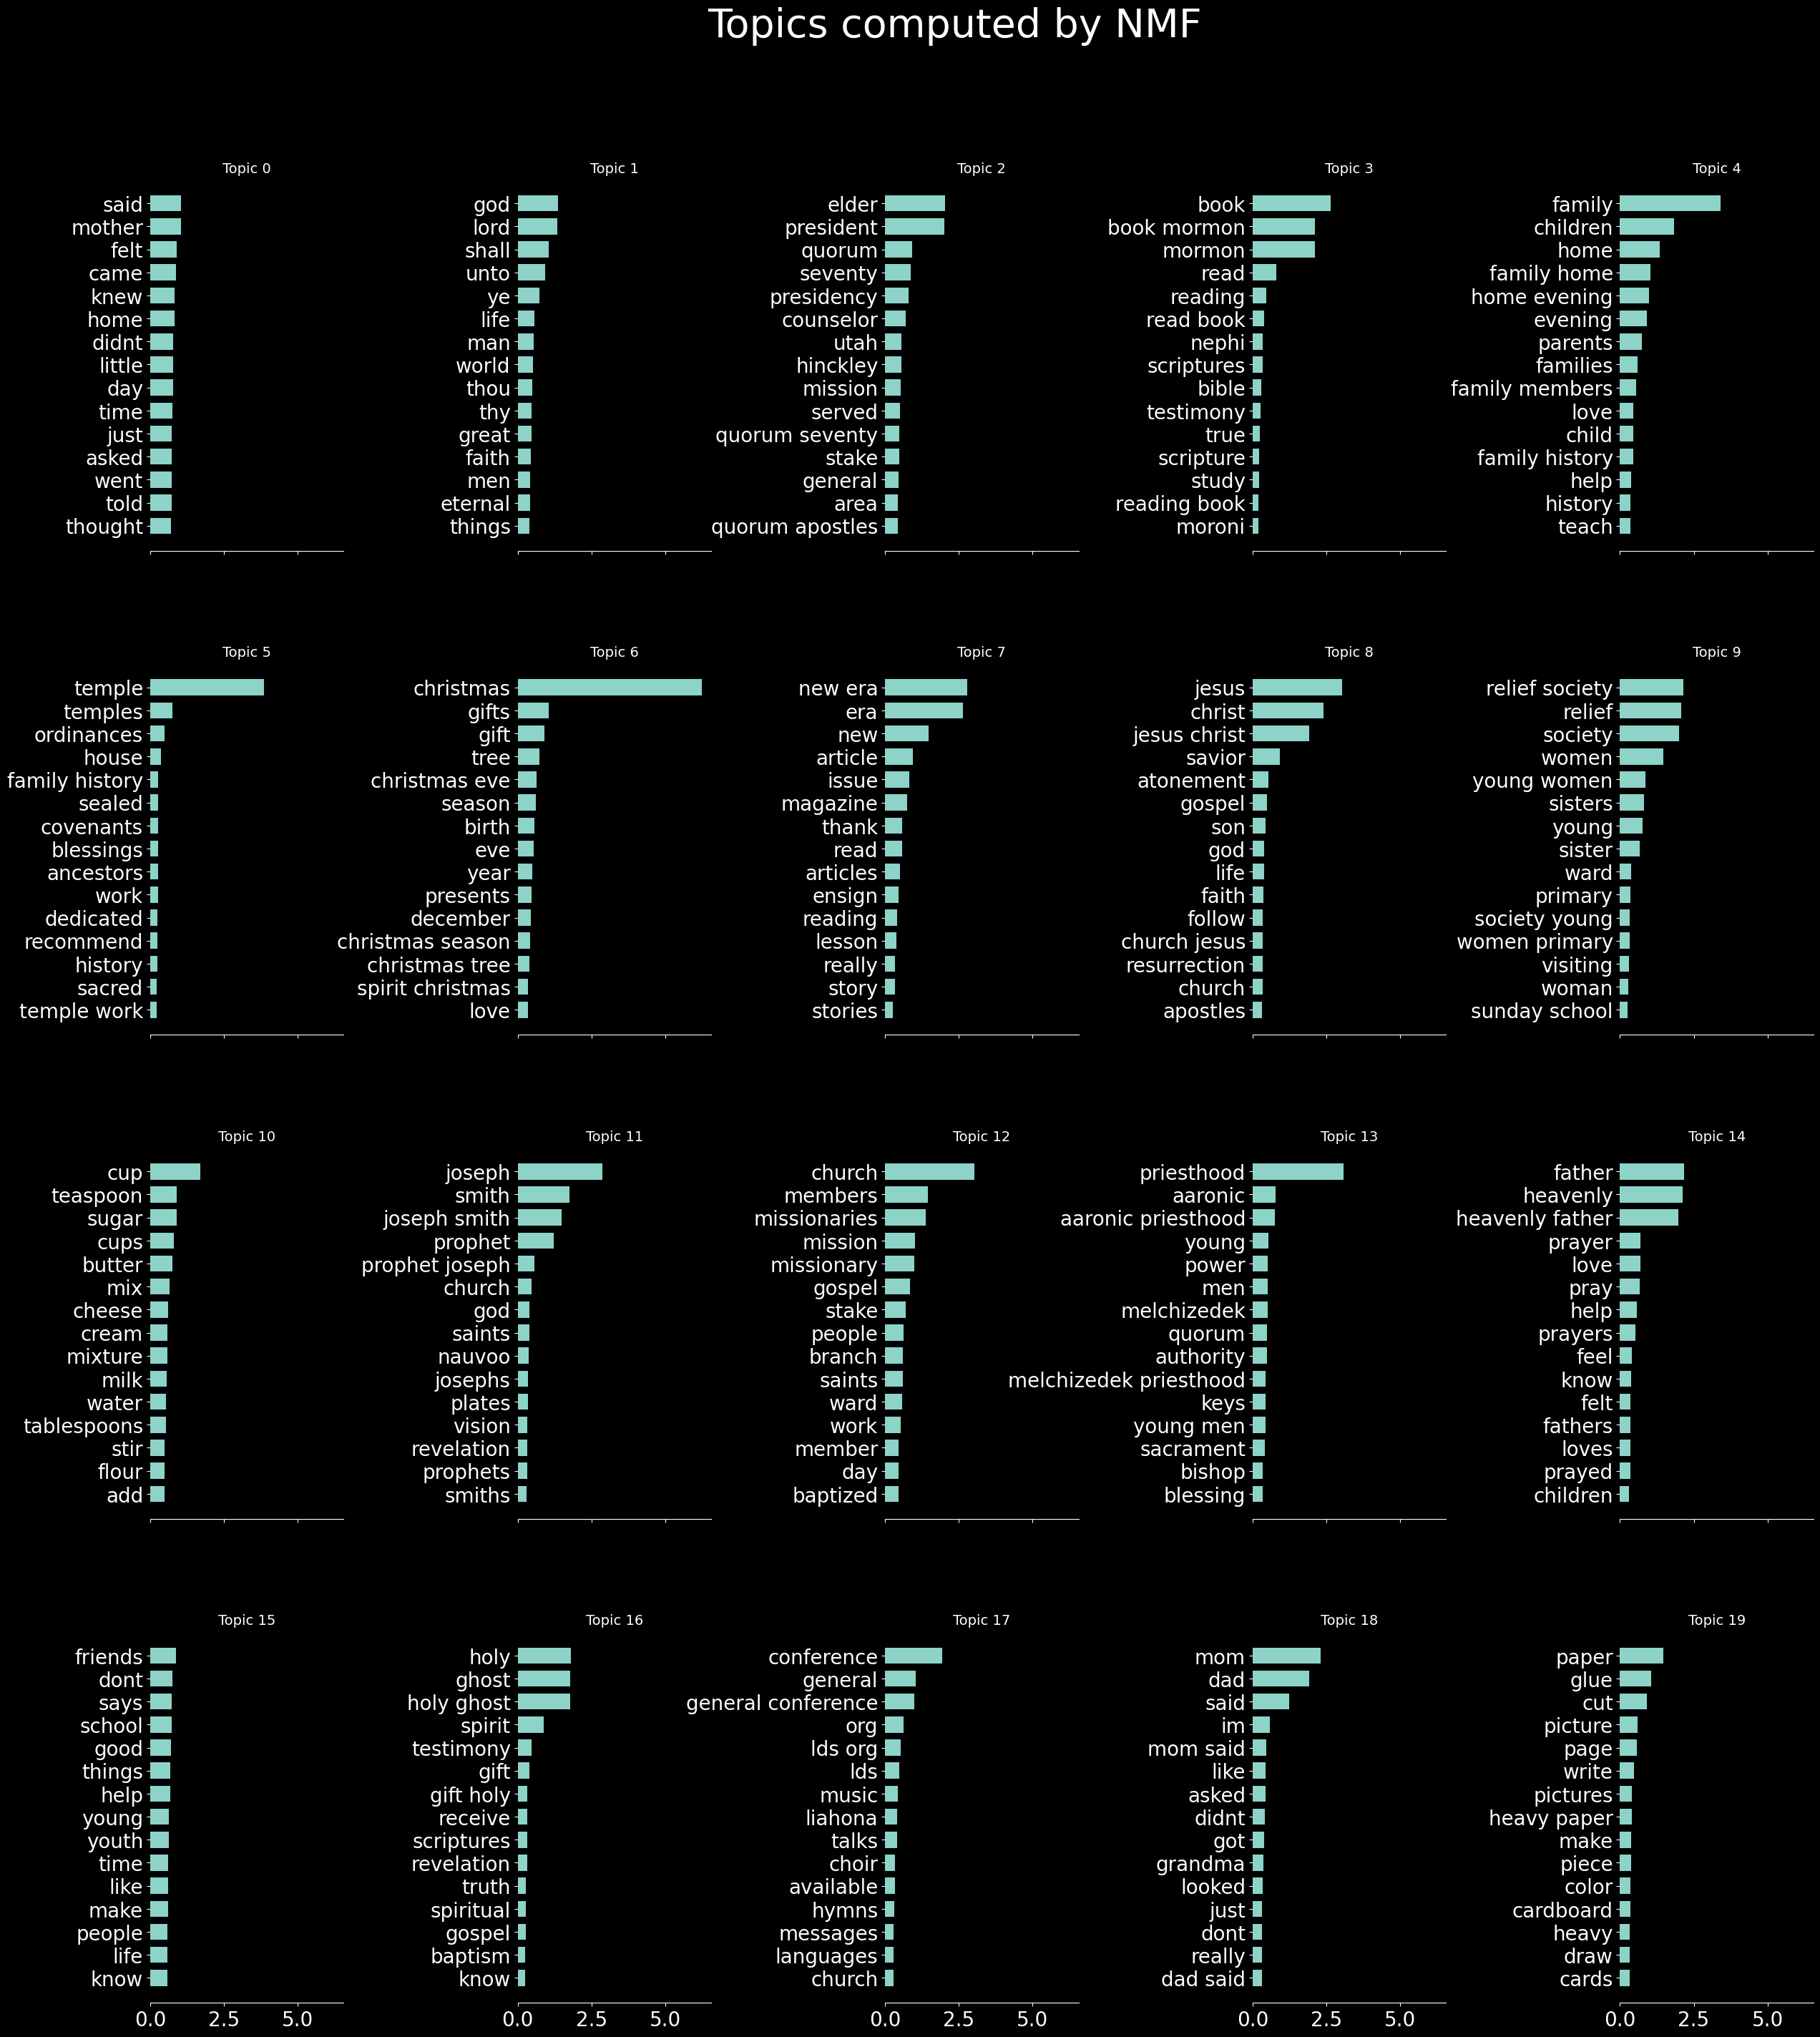

In [27]:
plot_top_words(
    model = nmf,
    feature_names = tfidf_nmf.get_feature_names_out(),
    n_topics = 20,
    n_top_words = 15,
    title = "Topics computed by NMF",
    randomize = False)


In [64]:
nmf_topic_labels = [
    'Communication', # Communication? Dialog?
    'Scriptures', # Scripture passage? God? Commandments?
    'Church Organization', # Church administration? Church organization? Priesthood?
    'Book of Mormon', 
    'Family',
    'Temple', 
    'Christmas',
    'Youth',  # maybe just "magazine"?
    'Jesus Christ',
    'Women in the Church',
    'Food',  # Recipe? Cooking? Baking?
    'Joseph Smith',  # Restoration of the Church?
    'Missionary Work',  # Church gathering?
    'Priesthood',
    'Heavenly Father',  # Prayer?
    'Friends',  # School? Peer pressure? Education? Relationships?
    'Holy Ghost',  # Revelation?
    'General Conference',  # Broadcasts? Church-wide messages?
    'Parents',  # Relatives? Communication? Relationships?
    'Crafts'  # Activities?
]

dict(zip(range(len(nmf_topic_labels)), nmf_topic_labels))

{0: 'Communication',
 1: 'Scriptures',
 2: 'Church Organization',
 3: 'Book of Mormon',
 4: 'Family',
 5: 'Temple',
 6: 'Christmas',
 7: 'Youth',
 8: 'Jesus Christ',
 9: 'Women in the Church',
 10: 'Food',
 11: 'Joseph Smith',
 12: 'Missionary Work',
 13: 'Priesthood',
 14: 'Heavenly Father',
 15: 'Friends',
 16: 'Holy Ghost',
 17: 'General Conference',
 18: 'Parents',
 19: 'Crafts'}

Find the article with the highest score for each topic (to help determine whether the topic is well labeled).

In [65]:
topics_docs_matrix = nmf.components_ @ dtm_nmf[:-num_topics].transpose()
top_score_articles = topics_docs_matrix.argmax(axis=1)

df_top_article_per_topic = pd.concat(
    [
        df_article_topics_with_tags.loc[
            top_score_articles, 
            ['url', 'magazine', 'issue', 'section', 'title', 'summary', 'word_count', 'tags_naive']
            ].reset_index(),
        pd.Series(nmf_topic_labels)
    ], axis = 1
)

df_top_article_per_topic.to_csv('experiments/nmf_20_topics_top_articles.csv', index=False)

# Enable more characters to be displayed per column
# pd.options.display.max_colwidth = 256
# Return to default display limit
# pd.reset_option('display.max_colwidth')

df_top_article_per_topic.head(20)

index                                                url magazine  \
0   47156  https://www.churchofjesuschrist.org/study/new-...  New Era   
1   38220  https://www.churchofjesuschrist.org/study/ensi...   Ensign   
2   32175  https://www.churchofjesuschrist.org/study/ensi...   Ensign   
3   26702  https://www.churchofjesuschrist.org/study/ensi...   Ensign   
4   49528  https://www.churchofjesuschrist.org/study/frie...   Friend   
5   12473  https://www.churchofjesuschrist.org/study/liah...  Liahona   
6    2271  https://www.churchofjesuschrist.org/study/liah...  Liahona   
7   41826  https://www.churchofjesuschrist.org/study/new-...  New Era   
8   34516  https://www.churchofjesuschrist.org/study/ensi...   Ensign   
9    9816  https://www.churchofjesuschrist.org/study/liah...  Liahona   
10  37148  https://www.churchofjesuschrist.org/study/ensi...   Ensign   
11  48712  https://www.churchofjesuschrist.org/study/new-...  New Era   
12  35540  https://www.churchofjesuschrist.org/study/ensi...   Ensign   
13  42112  https://www.churchofjesuschrist.org/study/new-...  New Era   
14   9428  https://www.churchofjesuschrist.org/study/liah...  Liahona   
15  45690  https://www.churchofjesuschrist.org/study/new-...  New Era   
16   7064  https://www.churchofjesuschrist.org/study/liah...  Liahona   
17   4639  https://www.churchofjesuschrist.org/study/liah...  Liahona   
18  59743  https://www.churchofjesuschrist.org/study/frie...   Friend   
19  62520  https://www.churchofjesuschrist.org/study/frie...   Friend   

            issue                                    section  \
0        May 1982                                    general   
1   November 1971                                    general   
2   December 1985                                    general   
3     August 1996                                    general   
4   November 2021                         For Little Friends   
5      April 1993                                    general   
6   December 2019                                 The Friend   
7        May 2008                       What’s in It for You   
8        May 1979                                    general   
9      March 2003                                    general   
10   January 1973                         News of the Church   
11  December 1973                        “Of Goodly Parents”   
12   October 1977                                     Poetry   
13       May 2007                           The Unseen Power   
14   January 2004  From the Life of President Heber J. Grant   
15   January 1990                                    general   
16  November 2010                   Sunday Afternoon Session   
17       May 2014                         News of the Church   
18    August 1993                                    general   
19  February 1983                                    Funstuf   

                                                title  \
0                                 Pride and Prejudice   
1                             The Way to Eternal Life   
2   President Ezra Taft Benson Ordained Thirteenth...   
3                           Being a Missionary Church   
4                                Families Are Forever   
5                        Temples throughout the World   
6                                       Coloring Page   
7                                 Sunday Lesson Helps   
8   “What Think Ye of Christ?” “Whom Say Ye That I...   
9                  From Young Women to Relief Society   
10                                Simple Sunday Menus   
11                          “Joseph, Joseph, Joseph”*   
12  Status Report on Missionary Work:A Conversatio...   
13                                   The Unseen Power   
14                                I Am a Child of God   
15                          Q&A:Questions and Answers   
16                             Receive the Holy Ghost   
17  Technology and Social Media Expand Worldwide R...   
18                          Baseball and a

Label magazine articles with topic names.

In [66]:
# There are 8 magazine articles that had no words from the 50,000-term vocabulary.
# To avoid selecting a topic for those articles, I use filtering to set them to np.NaN.
max_vals_nmf = nmf_doc_topics[:-num_topics].max(axis=1).flatten()
# print((max_vals_nmf == 0).sum())  # Check the number of articles with no topic score information.

# Find the most similar topic for each document. 
print("Selecting the highest-scoring topic for each article...")
t0 = time.perf_counter()
pred_topic_idxs_nmf = np.array(nmf_doc_topics[:-num_topics].argmax(axis=1)).flatten()
pred_topic_labels_nmf = pd.Series(pred_topic_idxs_nmf, name='topic_nmf_20').apply(lambda idx_val: nmf_topic_labels[idx_val])
# Clear predictions where there was no information to predict from (because the magazine articles didn't share any words in common with any of the topic articles)
pred_topic_labels_nmf[max_vals_nmf == 0] = np.NaN
# Resetting the index ensures proper alignment when concatenated
df_article_topics_nmf = pd.concat([df_article_topics_with_tags.reset_index(drop=True), pred_topic_labels_nmf], axis=1)
print_time(t0)

# # To verify proper alignment, check that the URLs for each row are the same:
# print((df_article_data.url == df_text.url).value_counts())
# print((df_article_data.url == df_article_topics_nmf.url).value_counts())

# Save data
df_article_topics_nmf.to_csv('data/article_data_with_topics_and_tags_nmf.csv', index=False)

# View the article topics and compare the naive method to the manually-labeled NMF method
df_article_topics_nmf[~df_article_topics.summary.isna()] \
    [['magazine', 'issue', 'section', 'title', 'summary', 'word_count', 'tags_naive', 'topic_nmf_20']] \
    .sample(10, random_state=0)


Selecting the highest-scoring topic for each article...
Completed in 0.1s.


magazine           issue                   section  \
4591   Liahona        May 2014  Saturday Morning Session   
56480   Friend    October 2004                   Funstuf   
41570  New Era     August 2009                   general   
49259   Friend      April 2021                   general   
20886   Ensign   November 2009                   general   
34658   Ensign    October 1979                   general   
43671  New Era   December 2001                   general   
49439   Friend  September 2021                   general   
21352   Ensign   November 2008                   general   
17636   Ensign   November 2016  Saturday Morning Session   

                                                   title  \
4591                   The Joyful Burden of Discipleship   
56480  Poster Article: Prophets Teach Me to Strengthe...   
41570                                            Charity   
49259                   Meet Shiloh from the Philippines   
20886                          Teaching Helps Save Lives   
34658               The Importance of Celestial Marriage   
43671                                  Doorstep Nativity   
49439                               Church History Cards   
21352                       Winning the War against Evil   
17636                  Am I Good Enough? Will I Make It?   

                                                 summary  word_count  \
4591   To sustain our leaders is a privilege; it come...      1423.0   
56480  What I the Lord have spoken, I have spoken, … ...       519.0   
41570  Charity and Christlike love were taught and ex...       260.0   
49259  Meet Primary children helping others, like Jes...       185.0   
20886  We teach key doctrine, invite learners to do t...      1578.0   
34658  From addresses delivered 22 October 1976 at th...      3096.0   
43671  This family Christmas tradition started on a d...       299.0   
49439  Cut out the cards, fold on the dotted line, an...       139.0   
21352  You were entrusted to come to the earth in the...      1655.0   
17636  If you will really try and will not rationaliz...      1576.0   

                                              tags_naive    topic_nmf_20  
4591   [Service, Diversity and Unity in The Church of...      Scriptures  
56480  [Family, Restoration of the Church, Diversity ...          Family  
41570  [Charity, Love, Diversity and Unity in The Chu...      Scriptures  
49259  [Parenting, Family, Baptism, Diversity and Uni...         Parents  
20886  [Teaching the Gospel, Faith in Jesus Christ, P...      Holy Ghost  
34658  [Marriage, Plan of Salvation, Kingdoms of Glor...      Scriptures  
43671  [Christmas, Family, Spiritual Gifts, Family Hi...       Christmas  
49439  [Book of Mormon, Scriptures, Diversity and Uni...  Book of Mormon  
21352  [Plan of Salvation, Agency and Accountability,...      Scriptures  
17636  [Repentance, Atonement of Jesus Christ, Plan o...      Scriptures

Which topics are selected most frequently by the NMF 20-topic method with manual labels?

In [74]:
article_mix = df_article_topics_nmf['topic_nmf_20'].value_counts() / len(df_article_topics_nmf.index)
pd.DataFrame(article_mix).style.format({'topic_nmf_20': lambda val: f"{val:.1%}"})

### Manual labels using 30 topics

In [9]:
# Use a sample of articles to speed up NMF convergence
rng = np.random.default_rng()
sampled_indices = rng.choice(np.arange(dtm_nmf.shape[0] - num_topics), size=20_000, replace=False)
dtm_sample = dtm_nmf[sampled_indices, :]

print(f"Fitting the NMF model on {len(sampled_indices):,.0f} articles to create the topic-terms matrix...")
t0 = time.perf_counter()

nmf_30 = NMF(n_components=30, verbose=1, max_iter=1_000)
# Fit on the sample...
nmf_30.fit(dtm_sample)
# ...then apply to the entire document collection
nmf_doc_topics_30 = nmf_30.transform(dtm_sample)

print('=' * 50, '\n', 'DONE'.center(50, ' '), '\n', '=' * 50, sep='')
print_time(t0)

Fitting the NMF model on 20,000 articles to create the topic-terms matrix...
violation: 1.0
violation: 0.21299292046395638
violation: 0.14191758356519185
violation: 0.10862123458415039
violation: 0.08523941140848183
violation: 0.0637265471494666
violation: 0.04583089814754357
violation: 0.03501631591827406
violation: 0.029671176994450533
violation: 0.02721878721355345
violation: 0.025836075471113086
violation: 0.023935779852436743
violation: 0.021223461949799044
violation: 0.018219454828774122
violation: 0.015485791675175479
violation: 0.013135747585281079
violation: 0.011122327073112859
violation: 0.00944939006326148
violation: 0.008081169541208426
violation: 0.006953566994180633
violation: 0.006021921584982721
violation: 0.005253071982587749
violation: 0.0045964917874979265
violation: 0.004062474674088196
violation: 0.0036344244782136603
violation: 0.003283816399244427
violation: 0.0029983632752554738
violation: 0.002767009176650122
violation: 0.0025736496381491276
violation: 0.00241

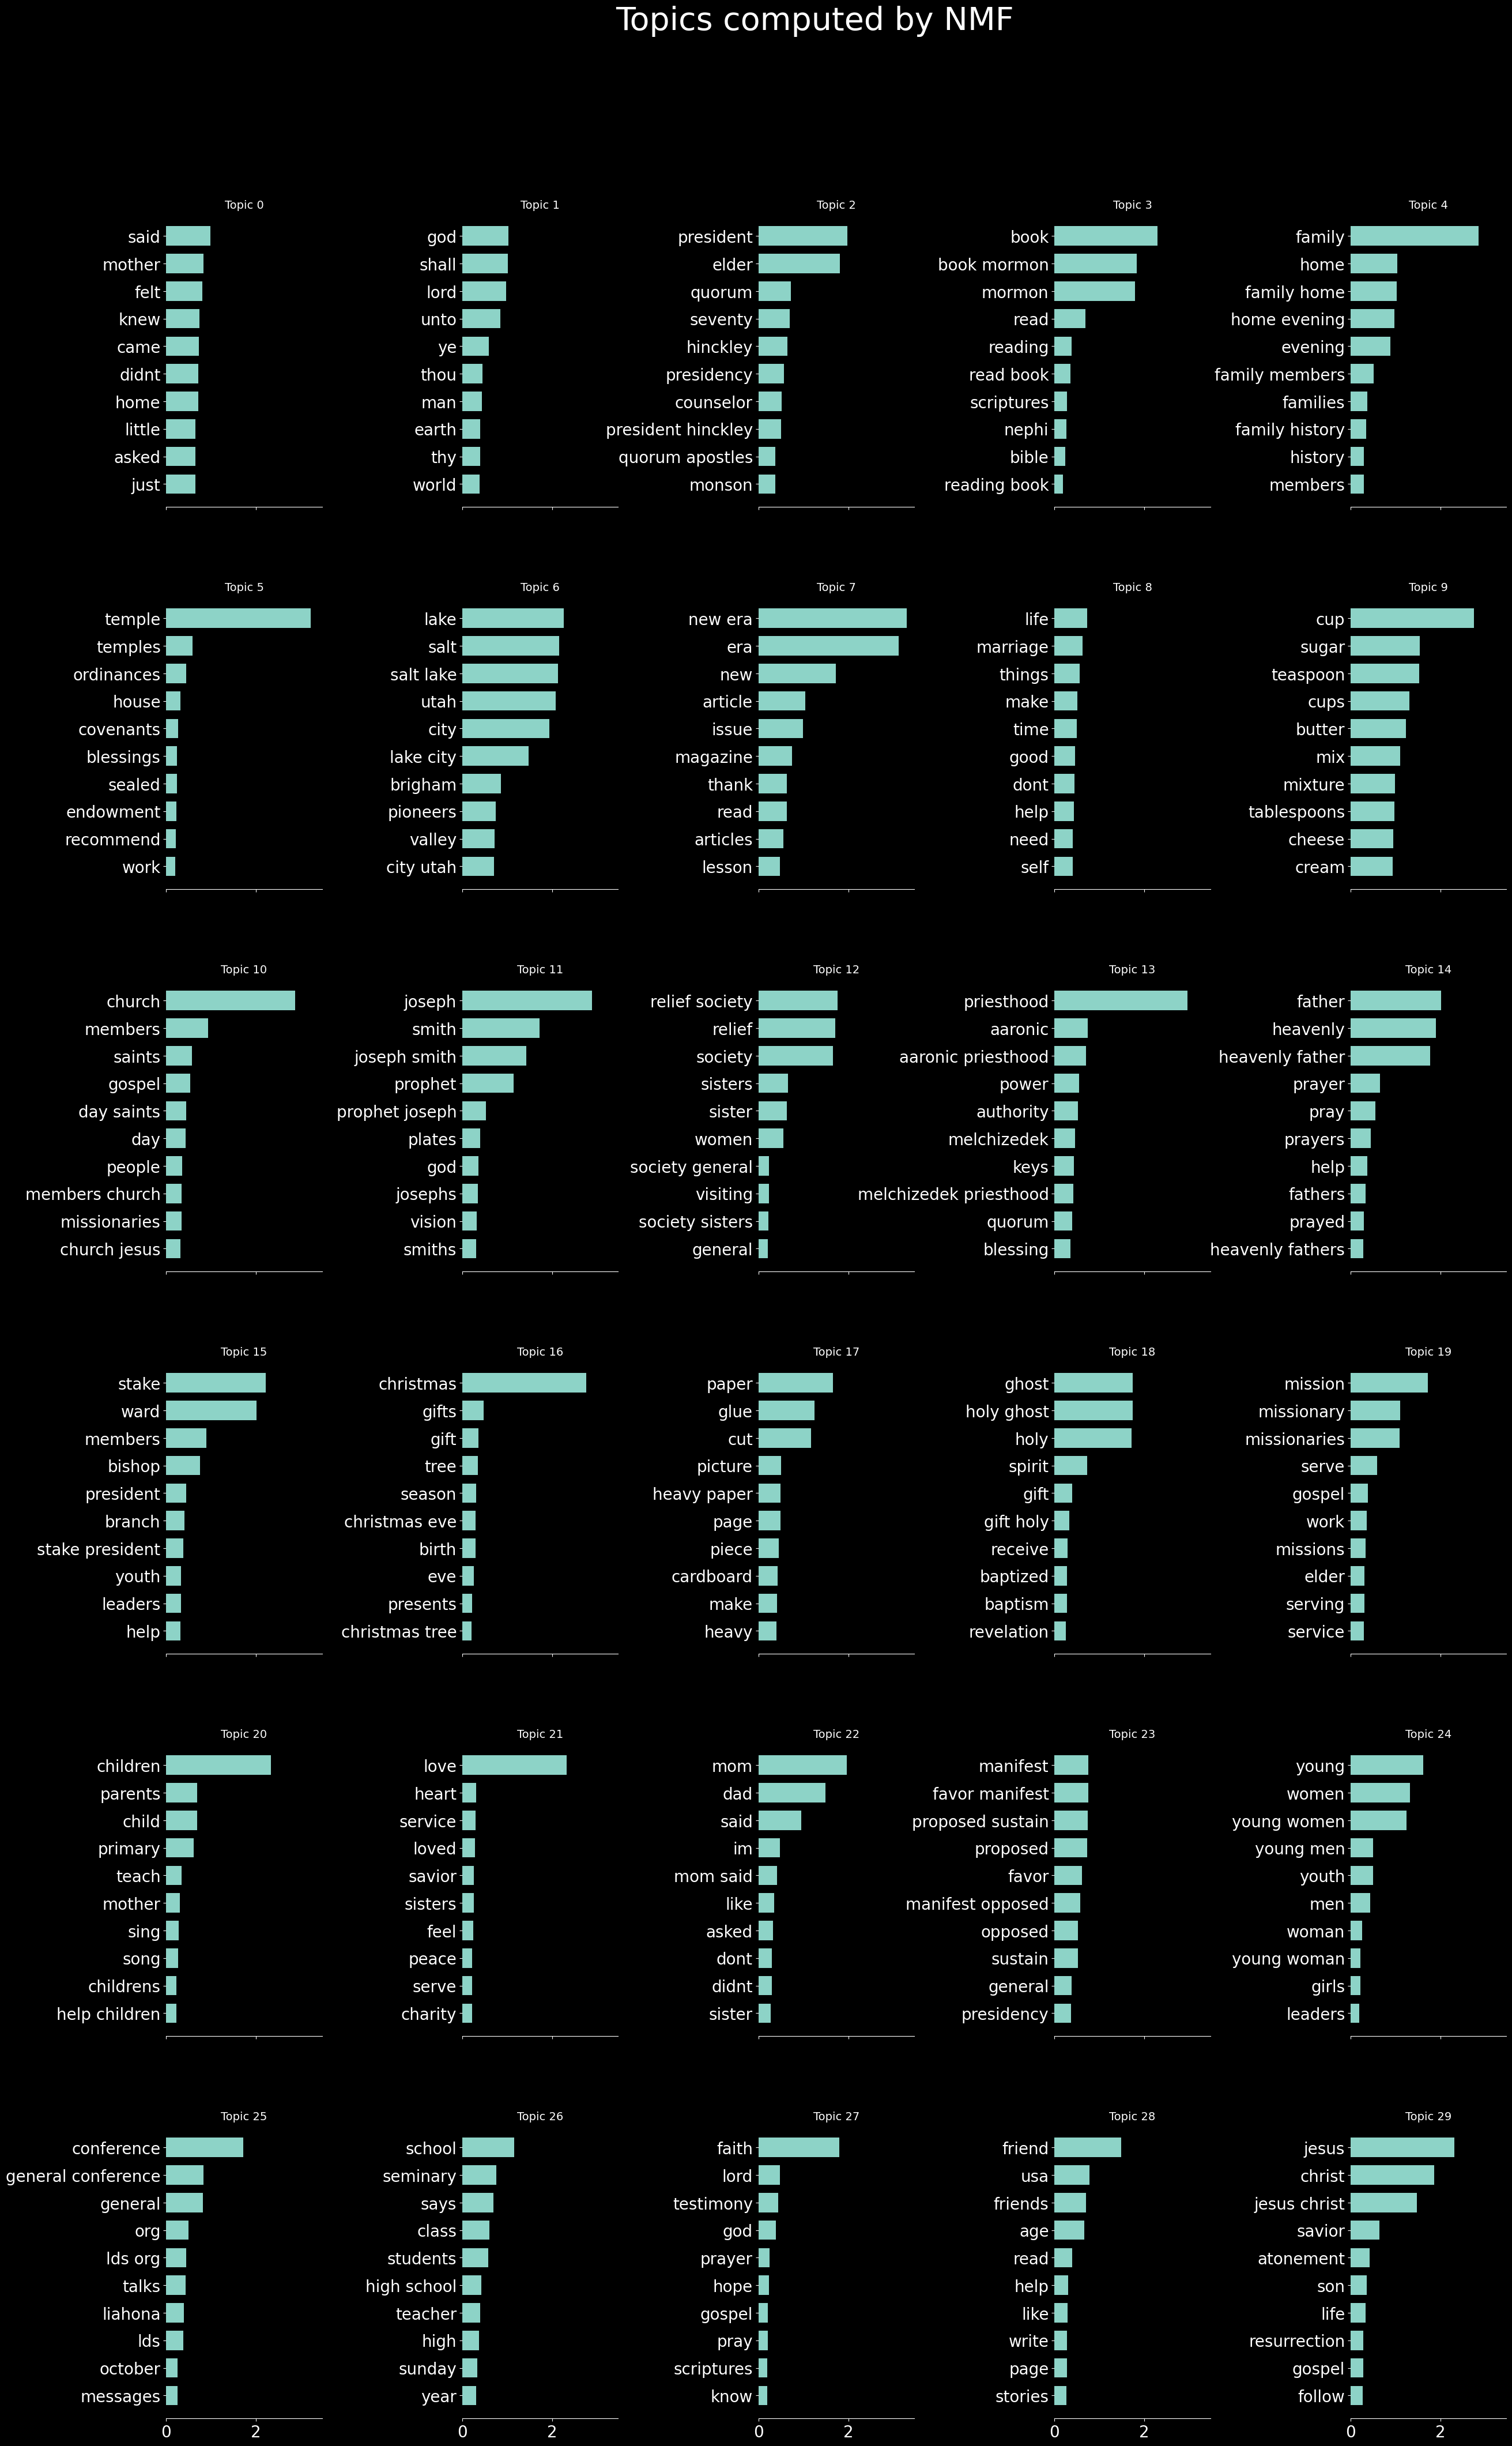

In [11]:
plot_top_words(
    model = nmf_30,
    feature_names = tfidf_nmf.get_feature_names_out(),
    n_topics = 30,
    n_top_words = 10,
    title = "Topics computed by NMF",
    randomize = False)


#### Which topics were selected most frequently?

Once again, we notice the same pattern with 20 topics: the least-distinguishable topics are the most common (i.e., topics 0, 1, and 8), suggesting that a larger `n_components` would create more distinct categories. But I'll stop here, since the naive method performs well and is much faster than runnning `NMF` on ~65k documents for 75 topics.

In [12]:
df_nmf_30_top_topics = pd.DataFrame(nmf_doc_topics_30.argmax(axis=1), columns=['topic_nmf_30'])
article_mix_30 = df_nmf_30_top_topics['topic_nmf_30'].value_counts() / len(df_nmf_30_top_topics.index)
pd.DataFrame(article_mix_30).style.format({'topic_nmf_30': lambda val: f"{val:.1%}"})

## Automatic labels
Using this method, the NMF-computed topics (available in the fitted model via `nmf.components_`) are labeled based on similarity scores from matrix multiplication with the topic article vectors.

### Topic-terms matrix
`nmf.fit(doc_terms_matrix)` creates the topic-terms matrix and stores it in `nmf.components_`. The topic-terms matrix holds the scores for each term to each topic, which can be used to interpret the topics.

The algorithm will stop before the `max_iter` number of iterations if the loss (called `violation`) goes below a threshold (default of 0.0001).

**Approximate timing**  
Using the `np.float32` data type, 75 categories, and a doc-terms matrix of `(1_075, 50_000)`, `NMF.fit()` converged in 2min 20s after ~200 iterations.  
With a doc-terms matrix of `(2_075, 50_000)`, the model converged in 3-5 minutes after 120-359 iterations (some runs converge faster than others).  
With a doc-terms matrix of `(10_075, 50_000)`, the model converged in 6min 26sec.

**Explanation of `NMF`'s parameters**  
- `n_components`: the number of topics to create
- `verbose`: if `1` or `True`, print the loss (called "violation") at each iteration to see progress towards convergence
- `init`: initialization strategy that sets the starting values of the matrices.
- `max_iter`: maximum number of iterations to run before completing; default=200. The algorithm will stop if the violation drops below the convergence threshold or if `max_iter` is reached.
- `random_state`: set to any integer to set the starting seed for reproducibility

For examples of how those parameters can be used, see the [scikit-learn example code comparing NMF to MiniBatchNMF and LDA](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html).

`MiniBatchNMF` uses those same parameters along with a `batch_size` parameter.

In [14]:
# Sample 1000 rows, excluding the topic articles.
# Technique adapted from: https://stackoverflow.com/a/22901973/17005348 
# and https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.choice.html
rng = np.random.default_rng()
sampled_indices = rng.choice(np.arange(dtm_nmf.shape[0] - num_topics), size=10_000, replace=False)
dtm_sample = dtm_nmf[sampled_indices, :]

# Concatenate the sampled magazine articles with all topic articles
dtm_sample = sparse.vstack([dtm_sample, dtm_nmf[-num_topics:, :]])

print(f"Fitting the NMF model on a sample of {dtm_sample.shape[0]:,.0f} articles to create the topic-terms matrix...")
t0 = time.perf_counter()
nmf = NMF(n_components=num_topics, verbose=1, max_iter=1_000)
nmf.fit(dtm_sample)
print('=' * 50, '\n', 'DONE'.center(50, ' '), '\n', '=' * 50, sep='')
print_time(t0)

Fitting the NMF model on a sample of 10,075 articles to create the topic-terms matrix...
violation: 1.0
violation: 0.1780670642936186
violation: 0.13253802198828984
violation: 0.09629097075487945
violation: 0.06756245459155544
violation: 0.04896839241971806
violation: 0.037964754143638736
violation: 0.03111877743354559
violation: 0.026135864806549135
violation: 0.022769316593156324
violation: 0.020593032371260686
violation: 0.01886111007796778
violation: 0.017042081086785094
violation: 0.015178585746125904
violation: 0.013538799693915133
violation: 0.012232126376996572
violation: 0.011083535209141878
violation: 0.010112206755627727
violation: 0.009326978505584574
violation: 0.008677529148643302
violation: 0.008121209809966407
violation: 0.007617422294537469
violation: 0.007101349099308035
violation: 0.0066181525244342785
violation: 0.0061168809024994475
violation: 0.005619243257531088
violation: 0.00514035110582397
violation: 0.004673774439005563
violation: 0.004225686313426903
violati

### Topic prediction
Use the `nmf.transform()` method to create a doc-topic matrix, with similarity scores for each topic to each magazine article.

In [15]:
print("Scoring topics for all magazine articles based on the fitted NMF model...")
t0 = time.perf_counter()
nmf_doc_topics = nmf.transform(dtm_nmf)
print_time(t0)


Scoring topics for all magazine articles based on the fitted NMF model...
violation: 1.0
violation: 0.48551706355658414
violation: 0.05865158439545482
violation: 0.016442363885208124
violation: 0.0051884454309222665
violation: 0.0012765718501538132
violation: 0.0005015104432759905
violation: 0.00015775892708965163
violation: 4.65105966250544e-05
Converged at iteration 10
Completed in 38.1s.


### Topic labeling

In [17]:
# If you haven't run the code in the Naive Method above,
# run this cell to load the data:
df_article_topics_with_tags = pd.read_csv('data/article_data_with_topics_and_tags_nmf.csv')

In [21]:
# Matrix-multiply (using the @ operator) the topic-terms matrix by the
# transposed doc-terms matrix for the topic articles.
# It's important to perform the operation this way to preserve the SciPy sparse
# matrices that save memory compared to dense NumPy arrays.
# nmf.components_ stores the topic-term matrix after fitting the NMF model.

nmf_topic_similarity = nmf.components_ @ dtm_nmf[-num_topics:, :].transpose()

# # Uncomment this section to normalize the topic vectors
# # and reduce the impact of word count on topic prediction.
# print('Normalizing the topics...')
# # Implicitly converts to dense format, which causes out-of-memory errors on larger arrays (like dtm_docs).
# dtm_topics_nmf = dtm_nmf[-num_topics:, :].copy()
# # dtm_topics_nmf /= dtm_topics_nmf.max(axis=1).toarray()  # mini-max normalized
# dtm_topics_nmf = dtm_topics_nmf.power(2) / dtm_topics_nmf.max(axis=1).toarray()  # squared first, then mini-max normalized
# nmf_topic_similarity = nmf.components_ @ dtm_topics_nmf.transpose()  

# Check the shape of the topic-terms matrix -- it should be 
# `num_topics` rows by `num_topics` columns, where each row 
# is a topic computed by NMF and each column is the score of that topic 
# compared to the labeled topics. The argmax (index of the highest score) 
# should correspond with the most likely label for the computed topic.
print(f"Shape of topic predictions matrix: {nmf_topic_similarity.shape}")

# View resulting total number of topic labels 
# (likely reduced since some computed topics were assigned the same label)
num_condensed = len(set(np.array(nmf_topic_similarity).argmax(axis=1)))
print(f"NMF-computed topics correspond to {num_condensed} topic labels out of the total {num_topics} labels.")

# On the code line below, np.array(nmf_topic_similarity).argmax(axis=1)
# creates a mapping between the topics I generated (that is, the last section of the doc-terms matrix)
# and the topics that the NMF model created. The first item in the list is
# the first topic that the NMF model created, and the number of that item is the
# index in the article topics. The second item holds the index of the article topic
# that it is closest to, and so forth.
nmf_topic_names = [df_topics.at[idx, 'topic'] for idx in np.array(nmf_topic_similarity).argmax(axis=1)]

# Find the most similar topic for each document. 
print("Selecting the highest-scoring topic for each article...")
t0 = time.perf_counter()
# Add topic labels for magazine articles only (that's the [:-num_topics] part),
# selecting the topic with the highest similarity score (that's the .argmax() part).
pred_topic_labels_nmf = pd.Series(
    data = np.array(nmf_doc_topics[:-num_topics, :].argmax(axis=1)).flatten(),
    name = 'topic_nmf_75',
    ).apply(lambda idx: nmf_topic_names[idx])

# There are 8 magazine articles that had no words from the 50,000-term vocabulary.
# To avoid selecting a topic for those articles, I use filtering to set them to np.NaN.
max_vals_nmf = nmf_doc_topics[:-num_topics].max(axis=1).flatten()
# print((max_vals_nmf == 0).sum())  # Check the number of articles with no topic score information.
# Clear predictions where there was no information to predict from (because the magazine articles didn't share any words in common with any of the topic articles)
pred_topic_labels_nmf[max_vals_nmf == 0] = np.NaN

# Resetting the index ensures proper alignment when concatenated
df_article_topics_nmf = pd.concat([df_article_topics_with_tags.reset_index(drop=True), pred_topic_labels_nmf], axis=1)
print_time(t0)

# # To verify proper alignment, check that the URLs for each row are the same:
# print((df_article_data.url == df_text.url).value_counts())
# print((df_article_data.url == df_article_topics_nmf.url).value_counts())

# Save data
df_article_topics_nmf.to_csv('data/article_data_with_topics_and_tags_nmf_75.csv', index=False)

# View the article topics and compare to the naive method abd the manually-labeled NMF method
df_article_topics_nmf[~df_article_data.summary.isna()] \
    [['magazine', 'issue', 'section', 'title', 'summary', 'word_count', 'tags_naive', 'topic_nmf_20', 'topic_nmf_75']] \
    .sample(10, random_state=0)


Shape of topic predictions matrix: (75, 75)
NMF-computed topics correspond to 44 topic labels out of the total 75 labels.
Selecting the highest-scoring topic for each article...
Completed in 0.1s.


magazine           issue                   section  \
4591   Liahona        May 2014  Saturday Morning Session   
56480   Friend    October 2004                   Funstuf   
41570  New Era     August 2009                   general   
49259   Friend      April 2021                   general   
20886   Ensign   November 2009                   general   
34658   Ensign    October 1979                   general   
43671  New Era   December 2001                   general   
49439   Friend  September 2021                   general   
21352   Ensign   November 2008                   general   
17636   Ensign   November 2016  Saturday Morning Session   

                                                   title  \
4591                   The Joyful Burden of Discipleship   
56480  Poster Article: Prophets Teach Me to Strengthe...   
41570                                            Charity   
49259                   Meet Shiloh from the Philippines   
20886                          Teaching Helps Save Lives   
34658               The Importance of Celestial Marriage   
43671                                  Doorstep Nativity   
49439                               Church History Cards   
21352                       Winning the War against Evil   
17636                  Am I Good Enough? Will I Make It?   

                                                 summary  word_count  \
4591   To sustain our leaders is a privilege; it come...      1423.0   
56480  What I the Lord have spoken, I have spoken, … ...       519.0   
41570  Charity and Christlike love were taught and ex...       260.0   
49259  Meet Primary children helping others, like Jes...       185.0   
20886  We teach key doctrine, invite learners to do t...      1578.0   
34658  From addresses delivered 22 October 1976 at th...      3096.0   
43671  This family Christmas tradition started on a d...       299.0   
49439  Cut out the cards, fold on the dotted line, an...       139.0   
21352  You were entrusted to come to the earth in the...      1655.0   
17636  If you will really try and will not rationaliz...      1576.0   

                                              tags_naive    topic_nmf_20  \
4591   ['Service', 'Diversity and Unity in The Church...      Scriptures   
56480  ['Family', 'Restoration of the Church', 'Diver...          Family   
41570  ['Charity', 'Love', 'Diversity and Unity in Th...      Scriptures   
49259  ['Parenting', 'Family', 'Baptism', 'Diversity ...         Parents   
20886  ['Teaching the Gospel', 'Faith in Jesus Christ...      Holy Ghost   
34658  ['Marriage', 'Plan of Salvation', 'Kingdoms of...      Scriptures   
43671  ['Christmas', 'Family', 'Spiritual Gifts', 'Fa...       Christmas   
49439  ['Book of Mormon', 'Scriptures', 'Diversity an...  Book of Mormon   
21352  ['Plan of Salvation', 'Agency and Accountabili...      Scriptures   
17636  ['Repentance', 'Atonement of Jesus Christ', 'P...      Scriptures   

              topic_nmf_75  
4591               Service  
56480            Education  
41570                 Love  
49259                 Love  
20886  Teaching the Gospel  
34658             Marriage  
43671            Christmas  
49439       Book of Mormon  
21352    Plan of Salvation  
17636           Repentance

In [58]:
# For comparing this to prior approaches, run the code below
# and add it to a worksheet in data/topic_predictions_norm_comparison.xlsx

df_article_topics_nmf[['issue', 'topic_nmf_75']].groupby(by='topic_nmf_75').count() \
    .sort_values(by='issue', ascending=False) \
    .to_csv('experiments/topic_assignments_nmf_auto_label.csv')

How well did the topic assignment do? Let's check its accuracy at labeling the topic articles:

In [23]:
topic_srs = pd.Series(
    data = np.array(nmf_doc_topics[-num_topics: , :].argmax(axis=1)).flatten(),
    index = df_topics['topic'],
    name = 'index'
)

label_srs = pd.Series(
    data = topic_srs.apply(lambda idx: nmf_topic_names[idx]),
    index = df_topics['topic'],
    name = 'topic_label'
)

df_nmf_topic_labels = pd.concat([label_srs, topic_srs], axis=1)

# Note that the index is the actual topic
df_nmf_topic_labels.to_csv('experiments/nmf_topics_to_topic_articles.csv')

# View a sample of the results
pd.options.display.max_rows = 100
# pd.reset_option('display.max_rows')  # Reset to default display limit
df_nmf_topic_labels.head(75)

topic_label  \
topic                                                                                                   
Addiction                                                                                  Repentance   
Adversity                                                                           Plan of Salvation   
Agency and Accountability                                                           Plan of Salvation   
Atonement of Jesus Christ                                                           Plan of Salvation   
Baptism                                                                                      Covenant   
Bible                                                                                           Bible   
Book of Mormon                                                                         Book of Mormon   
Charity                                                                                          Love   
Chastity                                                                                     Marriage   
Christmas                                                                                   Christmas   
Citizenship                                         Diversity and Unity in The Church of Jesus Chr...   
Communication                                                                                    Love   
Conversion                                                                                 Conversion   
Covenant                                                                                     Covenant   
Dating and Courtship                                                             Dating and Courtship   
Diversity and Unity in The Church of Jesus Chri...  Diversity and Unity in The Church of Jesus Chr...   
Easter                                                                                   Jesus Christ   
Education                                                                           Plan of Salvation   
Emergency Preparedness                                                         Emergency Preparedness   
Employment                                                                              Self-Reliance   
Eternal Life                                                                                   Prayer   
Faith in Jesus Christ                                                           Faith in Jesus Christ   
Family                                                                                         Family   
Family Finances                                                                         Self-Reliance   
Family History                                                                         Family History   
Fasting and Fast Offerings                                                     Emergency Preparedness   
Forgiveness                                                                                Repentance   
Gospel                                                                                       Covenant   
Grace                                                                                      Repentance   
Gratitude                                                                                Jesus Christ   
Grief                                                                                      Repentance   
Happiness                                                                           Plan of Salvation   
Health                                                                              Plan of Salvation   
Heavenly Parents                                                                    Plan of Salvation   
Holy Ghost                                                                                 Holy Ghost   
Honesty                                                                                 Self-Reliance   
Hope                                                                                           Praye

In [27]:
# See how often they matched
cnt = (df_nmf_topic_labels.index == df_nmf_topic_labels.topic_label).sum()
pctg = cnt / len(df_nmf_topic_labels.index)

print(f"NMF properly labeled topics {cnt}/{len(df_nmf_topic_labels.index)} times ({pctg:.2%}).")

NMF properly labeled topics 28/75 times (37.33%).


In [28]:
# Number of unique label names assigned to the topics.
# Any number below num_topics indicates the presence of duplicate labels.
print(f"Out of {num_topics} topics, " \
      f"NMF assigned {len(label_srs.unique())} different labels among those topics," \
      f"\nand {num_condensed} unique labels across all articles in the dataset.")

Out of 75 topics, NMF assigned 30 different labels among those topics,
and 44 unique labels across all articles in the dataset.


In [29]:
# View distribution of topic labels; show which ones are used most frequently.
label_srs.value_counts()

Plan of Salvation                                                         11
Prayer                                                                     8
Repentance                                                                 6
Covenant                                                                   5
Self-Reliance                                                              4
Love                                                                       3
Holy Ghost                                                                 3
Diversity and Unity in The Church of Jesus Christ of Latter-day Saints     3
Jesus Christ                                                               3
Emergency Preparedness                                                     2
Teaching the Gospel                                                        2
Joseph Smith                                                               2
Faith in Jesus Christ                                                      2

---

# Next steps
Here are some things I could try later to improve upon the topic modeling techniques demonstrated above:
- Use word embeddings (e.g., using `Gensim`'s `word2vec` or a neural network) to capture the semantic meaning of words in a lower-dimensional space (e.g., 100 dimensions). **Note:** don't use bigrams with this approach, just unigrams only, since the embeddings will capture the meaning of words much better than bigrams would.
- Sum word vectors for a document to create a document embedding
- Use a clustering algorithm on the document embeddings (e.g., `KMeans`) to group into topics

Or, another approach could be:
- Reduce the dimensionality of the doc-terms matrix using `TruncatedSVD` (e.g., 100 dimensions per document) then apply a clustering algorithm on the documents to group into topics

---

# <strong><span style="color: rgba(26, 130, 75, 1.0)">🧪 Experiments</span></strong>

I conduct problem-solving through experiments, exploring ideas and testing different approaches. I usually make note of what I learned from the experiments and save the code I wrote in case I want to refer to it later, but **I keep the best parts for the finished analysis, which is in the sections above**.

The sections below contain valuable notes documenting my problem-solving methodology and explaining what worked and what didn't. Review the code below to understand the steps I carried out before arriving at the finished code above.

# Experiment: normalize vectors
> **Key takeaway:** Normalizing the topic vectors may lead to suboptimal results compared to using the standard outputs of `TfidfVectorizer` (which outperforms `CountVectorizer` based on human judgment).

**Normalizing topic vectors**

Without specific normalizing steps, longer topic articles will be assigned more frequently than shorter articles in my naïve method because I matrix-multiply (i.e., a sum-product) the topic vectors by the document vectors. This effect is undesirable because topics should be assigned based on term relevance, rather than word counts. In this section, I explore different normalizing methods on the topic vectors. It should be noted that [standardizing TF-IDF vectors is probably unnecessary](https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features), since the TF-IDF algorithm itself normalizes the data. Given the unique application I have, whereby I matrix-multiply the TF-IDF vectors from the topics by those from the documents, a case can be made that normalizing the vectors might be beneficial to ensure that the most prominent term for each topic has the same value (e.g., using mini-max normalizing). Empirically, it seems that **this naive method produces relatively poor results whether normalized or not**, since the topic articles were not written with the purpose of being compared to the text from magazine articles.

See my [comparison between different normalizing and post-processing techniques on TfidfVectorizer](data/topic_predictions_norm_comparison.xlsx). From my experiments, I found that `TfidfVectorizer` seems to perform better than `CountVectorizer`, and that the default `TfidfVectorizer` seems to perform better than normalizing the outputs. By examining a sample of outputs and the topic selection distribution, I think the best normalizing technique that I tried was squaring each element and then dividing by the max value of each vector.

### Load data

In [ ]:
# Load article text
text_df = pd.read_csv('data/article_text.csv').dropna()
print(f"Loaded article text data ({len(text_df.index):,.0f} articles).")

# Load topics. Can use one of:
# RECOMMENDED ↓
# -------------------------------------------------------------------------------
# data/topics_gt_mod.csv  | newer topical reference, manually modified 
#                           from topics_gt.csv to remove glossary-style topics
#                           and consolidate similar topics. 75 topics.
# --------------------------------------------------------------------------------
# data/topics_gt.csv      | newer topical reference, 223 topics. Updated ca. 2020.
# data/topics_tf.csv      | older topical reference, 108 topics. Updated 2004.
topic_df = pd.read_csv('data/topics_gt_mod.csv')
# Add a word count column
topic_df['word_count'] = topic_df['text'].apply(lambda v: len(v.split()))

num_topics = len(topic_df.index)
print(f"Topics loaded. Total number of topics: {num_topics}")

full_data = pd.concat([text_df['text'], topic_df['text']], ignore_index=True)

# Verify that the Series loaded correctly
print(f"full_data Series loaded correctly? -> {len(full_data.index) == len(text_df.index) + len(topic_df.index)}")

Loaded article text data (64,953 articles).
Topics loaded. Total number of topics: 75
full_data Series loaded correctly? -> True


Load `article_data.csv`, where the resulting topics will be saved.

In [ ]:
article_data_df = pd.read_csv('data/article_data.csv', low_memory=False)
# Remove articles that don't have text (they're not really articles, after all 😉)
article_has_text = article_data_df.word_count.notna()
trimmed_article_data_df = article_data_df[article_has_text]

print(f"Articles with text from article_data.csv: {len(trimmed_article_data_df.index):,.0f}")
print(f"vs. number of articles in article_text.csv: {len(text_df.index):,.0f}")

Articles with text from article_data.csv: 64,953
vs. number of articles in article_text.csv: 64,953


### Text pre-processing

Function to normalize text (convert Unicode to ASCII equivalents), convert to lowercase, and remove non-alphabetic characters.

In [ ]:
def preprocess_text(orig_str):
    '''Preprocess text for sklearn's text vectorizers.
    
    Performs the following:
    1. convert all text to lowercase
    2. normalize unicode text to ASCII-equivalent characters
    3. remove punctuation and anything between parentheses
    '''
    # unidecode is a third-party package for unicode normaliznig
    # that works with most Latin-looking characters and punctuation.
    # new_str = unidecode.unidecode(orig_str.lower())

    # Replace anything inside parentheses (to remove scripture references, which may skew the dataset
    # towards topics like "Doctrine and Covenants")
    new_str = re.sub(pattern=r'\(.+?\)', repl=' ', string=orig_str.lower())

    # unicodedata.normalize is Python's built-in normalizing method. 
    # It fails to convert “” to "" and ‘’ to '', but is good enough 
    # for my purposes since I remove those characters anyways.
    # sklearn's TfidfVectorizer also doesn't remove those characters (or numbers, either).
    new_str = unicodedata.normalize(
        'NFKD',
        new_str
    ).encode(encoding='ascii', errors='ignore').decode()

    # Remove digits and punctuation (and anything else besides lowercase a-z and whitespace)
    new_str = re.sub(pattern=r'[^a-z\s]', repl=' ', string=new_str)
    
    # Replace multiple whitespace chars with a single space
    new_str = re.sub(pattern=r'[\s]{2,}', repl=' ', string=new_str)

    return new_str

## Doc-terms matrix for topics
Prior to running the topic models, the text must be _vectorized_: converted into a matrix of numbers that can be processed by the algorithms to assign a topic for each document.

After experimenting with multiple approaches, I chose to use `scikit-learn`'s `TfidfVectorizer`, which uses Term Frequency x Inverse Document Frequency (TF-IDF) to create a document-terms matrix of n_documents rows by n_terms columns, where terms are n-grams present in the text corpus (i.e., the text of all documents together). TF-IDF is a method of normalizing term frequency counts, where terms are weighed less if they appear in many documents in the corpus, since that would mean they are less informative for distinguishing one document from another.

I first create a doc-terms matrix for the topic articles, where the documents (rows) are the topic articles, and the terms (columns) are the _ngrams_ in those documents (I use unigrams and bigrams).

The vocabulary learned from vectorizing these topic articles will be used when vectorizing the magazine articles: that way, only words present in the topic articles will be considered for the vectorized bag-of-words representation for each magazine article. Compared with creating the document-terms matrix on all ~65k articles first, this method provides two primary benefits:
1. **Significantly reduced computational time.** The vocabulary present in the ~75-140 topic articles is significantly smaller than the vocabulary from all ~65,000 magazine articles.
2. **More compact representation.** For the naïve method, I simply multiply the magazine articles doc-terms matrix by the transposed topic articles doc-terms matrix, which means that any vocabulary terms from the magazine articles that were not in the topic articles would become `0s` -- making this a very large and very sparse matrix with no new information from the terms in the magazine articles that are not present in the topic articles.

In [ ]:
# The range for n-gram terms to include. (1, 1) means unigrams (single words) only.
# (1, 2) means unigrams and bigrams. (2, 2) means bigrams only, etc.
NGRAMS = (1, 2)

# Automatic stopword filtering
MAX_DOC_FREQ = 0.95       # Term cannot be present in over 95% of documents
# MIN_DOC_FREQ = 2          # Term must be present in at least 2 documents

# The maximum number of terms that will be used
# MAX_NUM_TERMS = 50_000 

tfidf = TfidfVectorizer(
    preprocessor = preprocess_text,
    ngram_range = NGRAMS,
    max_df = MAX_DOC_FREQ,
    # min_df = MIN_DOC_FREQ,
    # max_features = MAX_NUM_TERMS,
    # norm = 'l1'    # ['l2', 'l1']
    stop_words = 'english'
)

# Document-terms matrix (dtm) using the TF-IDF algorithm (TfidfVectorizer)
print("Creating doc-terms matrix using TF-IDF (TfidfVectorizer)...")
t0 = time.perf_counter()
dtm = tfidf.fit_transform(topic_df['text'])
print(f"Completed in {time.perf_counter() - t0:,.3f} seconds.")

# Check vocabulary size
print(f"\nNumber of docs by number of terms:\n{dtm.shape}")

# View the size, in bytes, of the doc-to-terms matrix
print(f"Approximate size in memory: {dtm.data.nbytes/1_000_000:,.2f}MB")

# Check number of terms (ngrams) added to stopwords (usually
# because they appeared in only one document when min_df is set to 2).
if len(tfidf.stop_words_) < 100:
    if tfidf.stop_words_ == set():
        print("Default stopwords list used, no new terms added.")
        # Show default stopwords list:
        # print(tfidf.get_stop_words())
    else:
        print(f"Words added to stopwords list:\n{tfidf.stop_words_}")
else:
    print(f"Number of terms added to stopword list: {len(tfidf.stop_words_):,.0f}")

Creating doc-terms matrix using TF-IDF (TfidfVectorizer)...
Completed in 0.848 seconds.

Number of docs by number of terms:
(75, 33024)
Approximate size in memory: 0.41MB
Default stopwords list used, no new terms added.


### Topic similarity
In this section, I examine the similarity between each topic, based on its doc-terms representation from `TfidfVectorizer`.

Cosine similarity from matrix multiplication.

The documentation for `scikit-learn`'s `TfidfVectorizer` states that when the `norm` parameter is set to `l2` (default, the sum of squares of each element in a vector equals 1), "the cosine similarity between two vectors is their dot product when l2 norm has been applied."

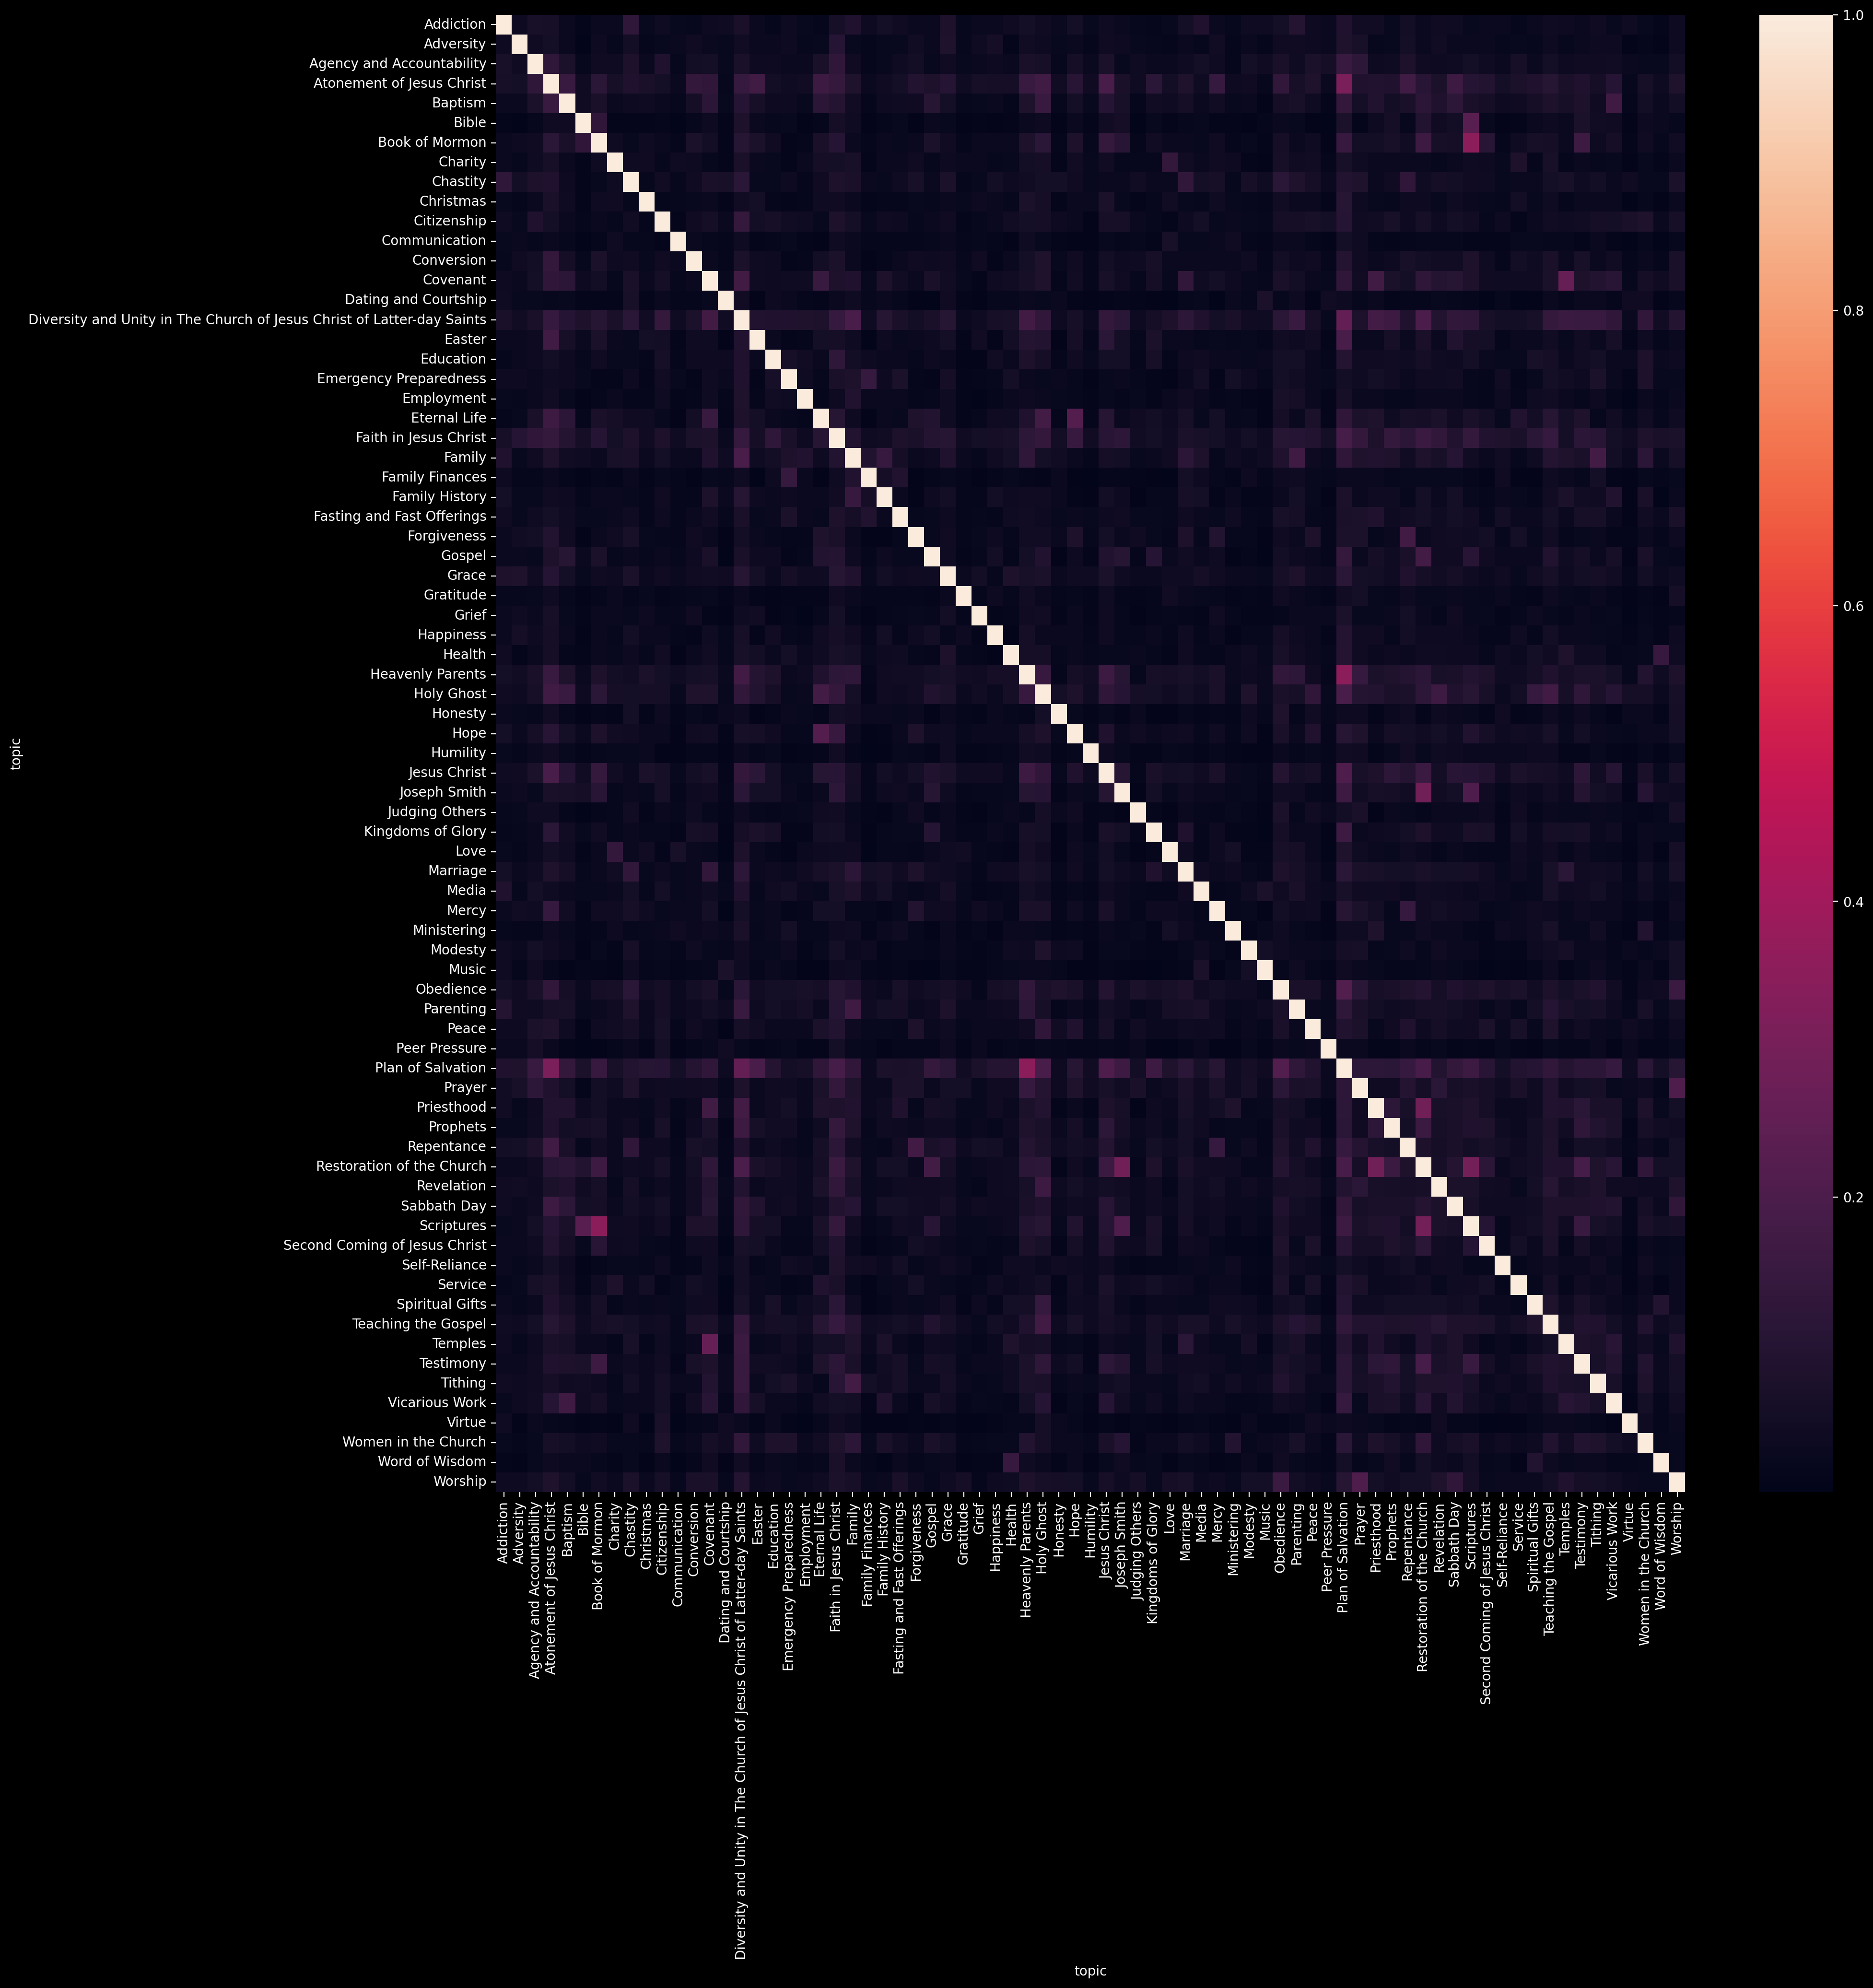

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20), dpi=200)
sns.heatmap(data=pd.DataFrame(data=(dtm @ dtm.transpose()).toarray(), index=topic_df['topic'], columns=topic_df['topic']), ax=ax)
plt.show()

The correlation between topic vectors yields a very similar result:

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20), dpi=200)
sns.heatmap(data=pd.DataFrame(data=dtm.transpose().toarray(), columns=topic_df['topic']).corr(), ax=ax)
plt.show()

### Top terms for each topic
Let's check which terms are most influential for each topic.

In [ ]:
# Get the top-10 terms for each topic
term_idxs = dtm.toarray().argsort()[:,:-11:-1]
print(term_idxs.shape)
terms_list = tfidf.get_feature_names_out()

df_topic_top_terms = pd.DataFrame(term_idxs).applymap(lambda val: terms_list[val])
df_topic_top_terms = pd.concat([topic_df['topic'], df_topic_top_terms], axis=1)

df_topic_top_terms.to_csv('experiments/topic_top_terms.csv', index=False)

df_topic_top_terms.head(10)

(75, 10)


topic            0                1                 2  \
0                  Addiction  pornography        addiction          recovery   
1                  Adversity    adversity           trials         responses   
2  Agency and Accountability        satan           choose            agency   
3  Atonement of Jesus Christ        death        sacrifice              fall   
4                    Baptism      baptism  little children             water   
5                      Bible        bible            books          writings   
6             Book of Mormon         book      book mormon            mormon   
7                    Charity      charity             love       love christ   
8                   Chastity       sexual         chastity          marriage   
9                  Christmas    christmas             came  christmas spirit   

                  3                 4                    5               6  \
0          intimacy  recovery program              program          sexual   
1         questions            people          trials come  example people   
2        temptation       free choose  overcome temptation            free   
3            christ         salvation               fallen           saved   
4         immersion            little       symbolic death  christ baptize   
5            church           witness            testament    bible church   
6             bible            christ          mormon book        lamb god   
7           ye love         rejoiceth         charity pure       pure love   
8  outside marriage           outside             thoughts        adultery   
9            season  christmas season              meaning   spirit christ   

                    7                   8                       9  
0                help  addiction recovery  addressing pornography  
1                come          experience       people experience  
2                life               devil                    good  
3               state                 god                    sins  
4            symbolic             baptize               authority  
5  scriptures current     having sanctity            translations  
6                gain               jesus            jesus christ  
7                  ye        children men                  things  
8         sexual sins        law chastity                  commit  
9              spirit              christ            god precious

In [ ]:
# Why doesn't this return the top-10 values?
# I'm indexing using an array of sorted indexes computed
# in the cell above; in NumPy, indexing with an array is
# called "fancy indexing". However, this throws an
# IndexError, since it attempts to index into axis 0 (the rows),
# where I'm trying to inde on only axis 1 (the columns).

dtm.toarray()[term_idxs]

# This doesn't work either: it broadcasts to an array of
# dimensions (75, 75, 10)
# dtm.toarray()[:, term_idxs]

IndexError: index 21618 is out of bounds for axis 0 with size 75

Here are the associated values (weights) for each term:

In [ ]:
dtm_sorted = np.sort(dtm.toarray()) # sorts the values in ascending order
pd.DataFrame(data=dtm_sorted[:, :-11:-1], index=topic_df['topic']).head(10)

0      1      2      3      4      5      6  \
topic                                                                        
Addiction                  0.191  0.050  0.048  0.013  0.012  0.009  0.008   
Adversity                  0.087  0.079  0.027  0.018  0.016  0.012  0.012   
Agency and Accountability  0.061  0.052  0.034  0.029  0.010  0.009  0.007   
Atonement of Jesus Christ  0.036  0.035  0.031  0.018  0.018  0.017  0.016   
Baptism                    0.071  0.031  0.022  0.021  0.019  0.015  0.015   
Bible                      0.140  0.030  0.015  0.013  0.009  0.007  0.006   
Book of Mormon             0.093  0.062  0.062  0.021  0.011  0.011  0.011   
Charity                    0.115  0.073  0.033  0.029  0.018  0.015  0.015   
Chastity                   0.148  0.024  0.020  0.018  0.014  0.013  0.013   
Christmas                  0.235  0.055  0.043  0.036  0.019  0.014  0.014   

                               7      8      9  
topic                                           
Addiction                  0.007  0.007  0.007  
Adversity                  0.011  0.010  0.010  
Agency and Accountability  0.007  0.006  0.006  
Atonement of Jesus Christ  0.016  0.015  0.015  
Baptism                    0.012  0.011  0.011  
Bible                      0.006  0.006  0.006  
Book of Mormon             0.010  0.009  0.009  
Charity                    0.011  0.010  0.010  
Chastity                   0.013  0.012  0.009  
Christmas                  0.010  0.005  0.005

Here's a comparison, this time using CountVectorizer instead of TfidfVectorizer. Notice the increased prevalence of "Jesus Christ," which is a term found across many topics.

In [ ]:
tf = CountVectorizer(preprocessor=preprocess_text, ngram_range=(1,2), stop_words = 'english')
dtm_tf = tf.fit_transform(topic_df['text'])
terms_list_tf = tf.get_feature_names_out()

# Get the top-10 terms for each topic
df_topic_top_terms_tf = pd.DataFrame(
        dtm_tf.toarray().argsort()[:,:-11:-1]
    ).applymap(lambda val: terms_list_tf[val])

df_topic_top_terms_tf = pd.concat([topic_df['topic'], df_topic_top_terms_tf], axis=1)
df_topic_top_terms_tf.to_csv('experiments/topic_top_terms_tf.csv', index=False)

df_topic_top_terms_tf.head(10)

topic            0          1             2  \
0                  Addiction  pornography  addiction          help   
1                  Adversity       people  adversity        trials   
2  Agency and Accountability       choose      satan          life   
3  Atonement of Jesus Christ       christ        god         jesus   
4                    Baptism      baptism     christ  jesus christ   
5                      Bible        bible     church         books   
6             Book of Mormon         book     mormon   book mormon   
7                    Charity         love    charity        christ   
8                   Chastity       sexual   marriage      chastity   
9                  Christmas    christmas       came        christ   

              3                 4           5              6  \
0        family          recovery    children       intimacy   
1          come         questions  experience       heavenly   
2        agency        temptation        good            god   
3  jesus christ             death   salvation           life   
4      children             jesus       water           life   
5           god           witness   testament         christ   
6        christ      jesus christ       jesus            god   
7        things                ye         men    love christ   
8          sins               law    thoughts          shall   
9        spirit  christmas spirit      season  spirit christ   

                  7           8             9  
0              lord      christ        sexual  
1           persons       shall     different  
2              unto          ye        follow  
3         sacrifice        sins          fall  
4   little children      little      baptized  
5             jesus  scriptures      writings  
6              come       bible          holy  
7           ye love     example  children men  
8            people         sin          lord  
9  christmas season     meaning          love

In [ ]:
dtm_tf_topics = dtm_tf.toarray() / dtm_tf.max(axis=1).toarray()

In [ ]:
dtm_tf_sorted = np.sort(dtm_tf.toarray()) # sorts the values in ascending order
pd.DataFrame(data=dtm_tf_sorted[:, :-11:-1], index=topic_df['topic']).head(10)

0   1   2   3   4   5   6   7   8   9
topic                                                            
Addiction                  20   9   9   8   8   7   5   5   5   5
Adversity                   7   7   7   5   4   4   3   3   3   3
Agency and Accountability  11  10   8   8   8   6   6   5   5   5
Atonement of Jesus Christ  32  29  24  23  22  19  18  17  17  16
Baptism                     8   6   5   5   5   4   4   4   4   3
Bible                       7   5   3   2   2   2   2   2   2   2
Book of Mormon             11  10   9   8   7   7   5   4   4   4
Charity                    11   6   5   4   4   3   3   3   2   2
Chastity                   23  10   9   8   7   7   7   7   7   6
Christmas                   7   6   4   4   3   3   2   2   2   2

Compare the results from both approaches:

In [ ]:
data_comp = df_topic_top_terms.drop(columns=['topic']).to_numpy()
for r, row in enumerate(data_comp):
    for c, col in enumerate(row):
        data_comp[r, c] += ' | ' + df_topic_top_terms_tf.iat[r, c+1]

print("Top terms comparison: TF-IDF vs. Term Frequency.",
    "\n(TF-IDF result | TF result)", sep='')
pd.concat([topic_df['topic'], pd.DataFrame(data_comp)], axis=1)

Top terms comparison: TF-IDF vs. Term Frequency.
(TF-IDF result | TF result)


topic                          0  \
0                   Addiction  pornography | pornography   
1                   Adversity         adversity | people   
2   Agency and Accountability             satan | choose   
3   Atonement of Jesus Christ             death | christ   
4                     Baptism          baptism | baptism   
..                        ...                        ...   
70             Vicarious Work   performed | jesus christ   
71                     Virtue            virtue | virtue   
72        Women in the Church     relief society | women   
73             Word of Wisdom       word wisdom | wisdom   
74                    Worship          worship | worship   

                           1                         2  \
0      addiction | addiction           recovery | help   
1         trials | adversity        responses | trials   
2             choose | satan             agency | life   
3            sacrifice | god              fall | jesus   
4   little children | christ      water | jesus christ   
..                       ...                       ...   
70          deceased | jesus         baptisms | christ   
71             moral | moral             stand | stand   
72            women | relief          relief | society   
73             wisdom | word  substances | word wisdom   
74           reverence | god           thy | reverence   

                           3                            4  \
0          intimacy | family  recovery program | recovery   
1           questions | come           people | questions   
2        temptation | agency     free choose | temptation   
3      christ | jesus christ            salvation | death   
4       immersion | children               little | jesus   
..                       ...                          ...   
70           dead | baptized          baptism | performed   
71             worthy | holy        receive guided | word   
72  society | relief society        organization | church   
73               word | lord    revealed word | following   
74            reverent | thy                  thou | lord   

                             5                             6  \
0           program | children             sexual | intimacy   
1     trials come | experience     example people | heavenly   
2   overcome temptation | good                    free | god   
3           fallen | salvation                  saved | life   
4       symbolic death | water         christ baptize | life   
..                         ...                           ...   
70             behalf | church            baptized | baptism   
71   clear conscience | worthy        word virtus | strength   
72          organized | christ                church | jesus   
73  healthy practices | taught  prophets taught | substances   
74                  god | thou          worship god | people   

                              7                            8  \
0                   help | lord  addiction recovery | christ   
1                come | persons           experience | shall   
2                   life | unto                   devil | ye   
3             state | sacrifice                   god | sins   
4    symbolic | little children             baptize | little   
..                          ...                          ...   
70         living person | dead             proxy | deceased   
71      feeling know | chastity       pattern thought | dont   
72  women church | jesus christ                smith | smith   
73    healthy | prophets taught          harmful | practices   
74      worship heavenly | love               yea let | unto   

                                                9  
0                 addressing pornography | sexual  
1                   people experience | different  
2                                   good | follow  
3                                     sins | fall  
4                            authority | baptized  
..                     

## Doc-terms matrix for articles
I re-use the vocabulary learned from the vectorized topic articles because that creates a more memory-efficient representation of the magazine article data, since there are far fewer terms (columns).

In [ ]:
# Code-timing template (or use %time on a line of code)

t0 = time.perf_counter()
# Your code here
t1 = time.perf_counter() - t0
# Check if the time was greater than 1 minute
if (t1 // 60) > 0:
    print(f"Completed in {t1 // 60:,.0f} min {t1 % 60:.1f} sec.")
else:
    print(f"Completed in {t1:.1f} sec.")

Completed in 0.0 sec.


In [ ]:
tfidf_docs = TfidfVectorizer(
    preprocessor = preprocess_text,
    ngram_range = (1,2),
    stop_words = 'english',
    vocabulary = tfidf.vocabulary_
)

print(f"Creating the doc-terms matrix for {len(text_df.index):,.0f} articles...")
t0 = time.perf_counter()
dtm_docs = tfidf_docs.fit_transform(text_df['text'])
t1 = time.perf_counter() - t0
# Check if the time was greater than 1 minute
if (t1 // 60) > 0:
    print(f"Completed in {t1 // 60:,.0f} min {t1 % 60:.1f} sec.")
else:
    print(f"Completed in {t1:.1f} sec.")

print("Matrix-multiplying the doc-terms matrix by the terms-topics matrix...")
# Matrix multiplication using the @ operator.
naive_topic_similarities = dtm_docs @ dtm.transpose()  # Uses the output of TfidfVectorizer
# naive_topic_similarities = dtm_docs @ dtm_topics.transpose()  # Uses the normalized output from TfidfVectorizer. See below.
naive_topic_similarities = dtm_docs @ dtm_topics.transpose()

# Find the most-similar topic for each document. 
# Note that csr_matrix.argmax() returns a 2-D numpy.matrix object,
# which is why I convert it to a standard numpy.array object.
naive_topic_assignments = np.array(naive_topic_similarities.argmax(axis=1)).flatten()
topic_list = topic_df['topic'].values
article_data_df = pd.concat(
    [   
        article_data_df, 
        pd.Series(naive_topic_assignments, name='topic').apply(lambda val: topic_list[val])
    ], axis=1)
article_data_df[['magazine', 'issue', 'section', 'series', 'title', 'topic']].head(20)
# Or, to see a random selection of topics:
# article_data_df[['magazine', 'issue', 'section', 'series', 'title', 'topic']].sample(20, random_state=0)

Creating the doc-terms matrix for 64,953 articles...
Completed in 3 min 9.2 sec.
Matrix-multiplying the doc-terms matrix by the terms-topics matrix...


magazine         issue                  section  \
0   Liahona  January 2021                  general   
1   Liahona  January 2021                  general   
2   Liahona  January 2021                  general   
3   Liahona  January 2021                  general   
4   Liahona  January 2021                  general   
5   Liahona  January 2021                  general   
6   Liahona  January 2021  Latter-day Saint Voices   
7   Liahona  January 2021  Latter-day Saint Voices   
8   Liahona  January 2021  Latter-day Saint Voices   
9   Liahona  January 2021  Latter-day Saint Voices   
10  Liahona  January 2021  Latter-day Saint Voices   
11  Liahona  January 2021  Latter-day Saint Voices   
12  Liahona  January 2021  Latter-day Saint Voices   
13  Liahona  January 2021          Come, Follow Me   
14  Liahona  January 2021          Come, Follow Me   
15  Liahona  January 2021          Come, Follow Me   
16  Liahona  January 2021          Come, Follow Me   
17  Liahona  January 2021          Come, Follow Me   
18  Liahona  January 2021          Come, Follow Me   
19  Liahona  January 2021          Come, Follow Me   

                                     series  \
0                                       NaN   
1                                  Hear Him   
2                     Welcome to This Issue   
3                                       NaN   
4                             Gospel Basics   
5                                       NaN   
6                   Latter-day Saint Voices   
7                   Latter-day Saint Voices   
8                   Latter-day Saint Voices   
9                   Latter-day Saint Voices   
10                                      NaN   
11                                      NaN   
12           Early Women of the Restoration   
13  Come, Follow Me: Doctrine and Covenants   
14  Come, Follow Me: Doctrine and Covenants   
15  Come, Follow Me: Doctrine and Covenants   
16  Come, Follow Me: Doctrine and Covenants   
17                                      NaN   
18                                Inclusion   
19                   Ministering Principles   

                                                title  \
0                     Pointing Us All to Jesus Christ   
1                                                 NaN   
2            A New Publication for a Worldwide Church   
3               Grow into the Principle of Revelation   
4                              God Speaks to Us Today   
5                    The Power of Personal Revelation   
6                                     A Better Choice   
7                                        Deneto Forde   
8                     The Anchor of My Life and Faith   
9                 Home-Centered Church Away from Home   
10                         A Bit of Missionary Heaven   
11                           Women and Covenant Power   
12                      Lucy Used Her Spiritual Gifts   
13             How does the restored gospel bless us?   
14                         How can I know for myself?   
15                What did Moroni teach Joseph Smith?   
16  “What greater witness can you have than from G...   
17   How Studying Church History Strengthens My Faith   
18                                 Including Everyone   
19                 Be With and Strengthen One Another   

                                                topic  
0                                        Jesus Christ  
1   Diversity and Unity in The Church of Jesus Chr...  
2                                          Holy Ghost  
3                                          Holy Ghost  
4                                          Holy Ghost  
5                                               Media  
6                                      Book of Mormon  
7                                      Book of Mormon  
8                                              Family  
9                                              Family  
10                                         Priesthood  
11        

### Comparison: normalized topic vectors
> **Key takeaway:** Normalizing the topic vectors may lead to suboptimal results compared to the standard output of `TfidfVectorizer`. This naive method is limited by the quality of the topic articles as reference for magazine articles, but the topic articles may not include all the terms or phrases that would best identify a topic using language common to the magazine articles. Still, this method provides a solid baseline for topic prediction.

**Normalizing topic vectors**

Without specific normalizing steps, longer topic articles will be assigned more frequently than shorter articles in my naïve method because I matrix-multiply (i.e., a sum-product) the topic vectors by the document vectors. This effect is undesirable because topics should be assigned based on term relevance, rather than word counts. In this section, I explore different normalizing methods on the topic vectors. It should be noted that [standardizing TF-IDF vectors is probably unnecessary](https://datascience.stackexchange.com/questions/33730/should-i-rescale-tfidf-features), since the TF-IDF algorithm itself normalizes the data. Given the unique application I have, whereby I matrix-multiply the TF-IDF vectors from the topics by those from the documents, a case can be made that normalizing the vectors might be beneficial to ensure that the most prominent term for each topic has the same value (e.g., using mini-max normalizing). Empirically, it seems that **this naive method produces relatively poor results whether normalized or not**, since the topic articles were not written with the purpose of being compared to the text from magazine articles.

See my [comparison between different normalizing and post-processing techniques on TfidfVectorizer](data/topic_predictions_norm_comparison.xlsx). From my experiments, I found that `TfidfVectorizer` seems to perform better than `CountVectorizer`, and that the default `TfidfVectorizer` seems to perform better than normalizing the outputs. By examining a sample of outputs and the topic selection distribution, I think the best normalizing technique that I tried was squaring each element and then dividing by the max value of each vector.

Using the default setting for the `norm` parameter, `TfidfVectorizer` uses L2 normalization, so the sum of squared elements from each vector equals 1. You can verify this by squaring each element and then computing the sum across each row, like this:

In [ ]:
np.power(dtm.toarray(), 2).sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

**Correlation with word count**  
Longer documents have higher TF-IDF scores when summing across a row (axis=1; i.e., all terms for a document). That means that longer topic articles have a higher probability of being assigned to any given magazine article using the naive method.

Here's the correlation between the sum across each topic vector and the word count for that topic:

In [ ]:
pd.DataFrame(
    dict(
        word_count=topic_df['word_count'],
        tfidf_sum=dtm.toarray().sum(axis=1)
    )
).corr()

word_count  tfidf_sum
word_count       1.000      0.923
tfidf_sum        0.923      1.000

**Dividing by the max value**  
Dividing by the max value in each row has the effect of setting the top term to 1 for each vector, with subsequent terms weighted based on their proportional importance relative to the top term. This makes the top terms comparable across topic vectors.

In [ ]:
print('Before normalizing:')
print(f"The largest sum for a topic vector is: {dtm.sum(axis=1).max():,.2f}")
print(f"and the smallest sum is: {dtm.sum(axis=1).min():,.2f},")
print(f"so the largest sum is {dtm.sum(axis=1).max() / dtm.sum(axis=1).min() - 1:,.2f}x the smallest one.")

# Normalize based on the max value in each row,
# after squaring each value to "undo" the L2 normalizing.
dtm_topics = np.power(dtm.toarray(), 2) / dtm.max(axis=1).toarray()

# Without first squaring each element:
# dtm_topics = dtm.toarray() / dtm.max(axis=1).toarray()

# A quick review of the sum of each topic vector reveals that
# there are still large differences between longer topics and
# shorter ones.
print('\nAfter normalizing:')
print(f"The largest sum for a topic vector is: {dtm_topics.sum(axis=1).max():,.2f}")
print(f"and the smallest sum is: {dtm_topics.sum(axis=1).min():,.2f}")
print(f"so the largest sum is {dtm_topics.sum(axis=1).max() / dtm_topics.sum(axis=1).min() - 1:,.2f}x the smallest one.")

# To verify that the operation was successful,
# check the max values before and after the transformation
# print('Before:', dtm.max(axis=1).toarray()[:10], '\n', sep='')
# print('After:', dtm_topics.max(axis=1)[:10])

Before normalizing:
The largest sum for a topic vector is: 47.33
and the smallest sum is: 9.82,
so the largest sum is 3.82x the smallest one.

After normalizing:
The largest sum for a topic vector is: 5.58
and the smallest sum is: 1.74
so the largest sum is 2.20x the smallest one.


In [ ]:
pd.DataFrame(
    dict(
        word_count=topic_df['text'].apply(lambda v: len(v.split())),
        tfidf_sum=dtm_topics.sum(axis=1)
    )
).corr()

word_count  tfidf_sum
word_count        1.00       0.24
tfidf_sum         0.24       1.00

In [ ]:
print("Matrix-multiplying the doc-terms matrix by the terms-topics matrix...")
# Matrix multiplication using the @ operator.
naive_topic_similarities = dtm_docs @ dtm_topics.transpose()  # Uses the modified output from TfidfVectorizer, normalized

# Find the most-similar topic for each document. 
# Note that csr_matrix.argmax() returns a 2-D numpy.matrix object,
# which is why I convert it to a standard numpy.array object.
naive_topic_assignments = np.array(naive_topic_similarities.argmax(axis=1)).flatten()
topic_list = topic_df['topic'].values
article_data_df = pd.concat(
    [   
        article_data_df.drop(columns=['topic']), 
        pd.Series(naive_topic_assignments, name='topic').apply(lambda val: topic_list[val])
    ], axis=1)
article_data_df[['magazine', 'issue', 'section', 'series', 'title', 'topic']].head(20)
# Or, to see a random selection of topics:
# article_data_df[['magazine', 'issue', 'section', 'series', 'title', 'topic']].sample(20, random_state=0)

Matrix-multiplying the doc-terms matrix by the terms-topics matrix...


magazine         issue                  section  \
0   Liahona  January 2021                  general   
1   Liahona  January 2021                  general   
2   Liahona  January 2021                  general   
3   Liahona  January 2021                  general   
4   Liahona  January 2021                  general   
5   Liahona  January 2021                  general   
6   Liahona  January 2021  Latter-day Saint Voices   
7   Liahona  January 2021  Latter-day Saint Voices   
8   Liahona  January 2021  Latter-day Saint Voices   
9   Liahona  January 2021  Latter-day Saint Voices   
10  Liahona  January 2021  Latter-day Saint Voices   
11  Liahona  January 2021  Latter-day Saint Voices   
12  Liahona  January 2021  Latter-day Saint Voices   
13  Liahona  January 2021          Come, Follow Me   
14  Liahona  January 2021          Come, Follow Me   
15  Liahona  January 2021          Come, Follow Me   
16  Liahona  January 2021          Come, Follow Me   
17  Liahona  January 2021          Come, Follow Me   
18  Liahona  January 2021          Come, Follow Me   
19  Liahona  January 2021          Come, Follow Me   

                                     series  \
0                                       NaN   
1                                  Hear Him   
2                     Welcome to This Issue   
3                                       NaN   
4                             Gospel Basics   
5                                       NaN   
6                   Latter-day Saint Voices   
7                   Latter-day Saint Voices   
8                   Latter-day Saint Voices   
9                   Latter-day Saint Voices   
10                                      NaN   
11                                      NaN   
12           Early Women of the Restoration   
13  Come, Follow Me: Doctrine and Covenants   
14  Come, Follow Me: Doctrine and Covenants   
15  Come, Follow Me: Doctrine and Covenants   
16  Come, Follow Me: Doctrine and Covenants   
17                                      NaN   
18                                Inclusion   
19                   Ministering Principles   

                                                title  \
0                     Pointing Us All to Jesus Christ   
1                                                 NaN   
2            A New Publication for a Worldwide Church   
3               Grow into the Principle of Revelation   
4                              God Speaks to Us Today   
5                    The Power of Personal Revelation   
6                                     A Better Choice   
7                                        Deneto Forde   
8                     The Anchor of My Life and Faith   
9                 Home-Centered Church Away from Home   
10                         A Bit of Missionary Heaven   
11                           Women and Covenant Power   
12                      Lucy Used Her Spiritual Gifts   
13             How does the restored gospel bless us?   
14                         How can I know for myself?   
15                What did Moroni teach Joseph Smith?   
16  “What greater witness can you have than from G...   
17   How Studying Church History Strengthens My Faith   
18                                 Including Everyone   
19                 Be With and Strengthen One Another   

                                                topic  
0   Diversity and Unity in The Church of Jesus Chr...  
1   Diversity and Unity in The Church of Jesus Chr...  
2                                          Revelation  
3                                          Revelation  
4                               Faith in Jesus Christ  
5                                               Media  
6                                      Book of Mormon  
7                                      Book of Mormon  
8                                              Family  
9                                 Teaching the Gospel  
10                                         Priesthood  
11        

In [ ]:
article_data_df[['issue', 'topic']].groupby(by='topic').count().sort_values(by='issue', ascending=False).to_csv('experiments/topic_assignments_test_L2_max_norm.csv')

**Dividing by the sum**  
Dividing by the sum of each row has the effect of scaling all terms such that the sum across each row will equal 1. Note that you could achieve this same normalizing effect by setting the `norm='l1'` parameter when initializing `TfidfVectorizer`.

This normalizing strategy penalizes longer topics relative to shorter ones: shorter topic articles will be assigned much more frequently because the individual terms in the short articles have much higher weights than those same terms in a longer article.

In [ ]:
print('Before normalizing:')
print(f"The largest sum of a topic vector is: {dtm.sum(axis=1).max():,.2f}")
print(f"and the smallest sum is: {dtm.sum(axis=1).min():,.2f},")
print(f"so the largest sum is {dtm.sum(axis=1).max() / dtm.sum(axis=1).min() - 1:,.2f}x the smallest one.")

# Normalize based on the sum of each row.
# Note that I don't square each element to "undo" the L2 normalizing because
# the sum of squared elements would be 1, and dividing by 1 wouldn't change the
# values.
dtm_topics = np.array(dtm / dtm.sum(axis=1))

# A quick review of the sum of each topic vector reveals that
# there are still large differences between longer topics and
# shorter ones.
print('\nAfter normalizing:')
print(f"The largest sum for a topic vector is: {dtm_topics.sum(axis=1).max():,.2f}")
print(f"and the smallest sum is: {dtm_topics.sum(axis=1).min():,.2f}")
print(f"so the largest sum is {dtm_topics.sum(axis=1).max() / dtm_topics.sum(axis=1).min() - 1:,.2f}x the smallest one.")


# Verify that topics are normalized. The sum across each row
# (i.e., the sum of terms for each topic) should be 1
# print(dtm_topics.sum(axis=1)[:10])
# Result:
# [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Before normalizing:
The largest sum of a topic vector is: 47.33
and the smallest sum is: 9.82,
so the largest sum is 3.82x the smallest one.

After normalizing:
The largest sum for a topic vector is: 1.00
and the smallest sum is: 1.00
so the largest sum is 0.00x the smallest one.


In [ ]:
# Correlation between word count and the sum of terms in each topic vector
pd.DataFrame(
    dict(
        word_count=topic_df['word_count'],
        tfidf_sum=dtm_topics.sum(axis=1)
    )
).corr()

word_count  tfidf_sum
word_count       1.000     -0.058
tfidf_sum       -0.058      1.000

In [ ]:
print("Matrix-multiplying the doc-terms matrix by the terms-topics matrix...")
# Matrix multiplication using the @ operator.
naive_topic_similarities = dtm_docs @ dtm_topics.transpose()  # Uses the modified output from TfidfVectorizer, normalized

# Find the most-similar topic for each document. 
# Note that csr_matrix.argmax() returns a 2-D numpy.matrix object,
# which is why I convert it to a standard numpy.array object.
naive_topic_assignments = np.array(naive_topic_similarities.argmax(axis=1)).flatten()
topic_list = topic_df['topic'].values
article_data_df = pd.concat(
    [   
        article_data_df.drop(columns=['topic']), 
        pd.Series(naive_topic_assignments, name='topic').apply(lambda val: topic_list[val])
    ], axis=1)
article_data_df[['magazine', 'issue', 'section', 'series', 'title', 'topic']].head(20)
# Or, to see a random selection of topics:
# article_data_df[['magazine', 'issue', 'section', 'series', 'title', 'topic']].sample(20, random_state=0)

Matrix-multiplying the doc-terms matrix by the terms-topics matrix...


magazine         issue                  section  \
0   Liahona  January 2021                  general   
1   Liahona  January 2021                  general   
2   Liahona  January 2021                  general   
3   Liahona  January 2021                  general   
4   Liahona  January 2021                  general   
5   Liahona  January 2021                  general   
6   Liahona  January 2021  Latter-day Saint Voices   
7   Liahona  January 2021  Latter-day Saint Voices   
8   Liahona  January 2021  Latter-day Saint Voices   
9   Liahona  January 2021  Latter-day Saint Voices   
10  Liahona  January 2021  Latter-day Saint Voices   
11  Liahona  January 2021  Latter-day Saint Voices   
12  Liahona  January 2021  Latter-day Saint Voices   
13  Liahona  January 2021          Come, Follow Me   
14  Liahona  January 2021          Come, Follow Me   
15  Liahona  January 2021          Come, Follow Me   
16  Liahona  January 2021          Come, Follow Me   
17  Liahona  January 2021          Come, Follow Me   
18  Liahona  January 2021          Come, Follow Me   
19  Liahona  January 2021          Come, Follow Me   

                                     series  \
0                                       NaN   
1                                  Hear Him   
2                     Welcome to This Issue   
3                                       NaN   
4                             Gospel Basics   
5                                       NaN   
6                   Latter-day Saint Voices   
7                   Latter-day Saint Voices   
8                   Latter-day Saint Voices   
9                   Latter-day Saint Voices   
10                                      NaN   
11                                      NaN   
12           Early Women of the Restoration   
13  Come, Follow Me: Doctrine and Covenants   
14  Come, Follow Me: Doctrine and Covenants   
15  Come, Follow Me: Doctrine and Covenants   
16  Come, Follow Me: Doctrine and Covenants   
17                                      NaN   
18                                Inclusion   
19                   Ministering Principles   

                                                title  \
0                     Pointing Us All to Jesus Christ   
1                                                 NaN   
2            A New Publication for a Worldwide Church   
3               Grow into the Principle of Revelation   
4                              God Speaks to Us Today   
5                    The Power of Personal Revelation   
6                                     A Better Choice   
7                                        Deneto Forde   
8                     The Anchor of My Life and Faith   
9                 Home-Centered Church Away from Home   
10                         A Bit of Missionary Heaven   
11                           Women and Covenant Power   
12                      Lucy Used Her Spiritual Gifts   
13             How does the restored gospel bless us?   
14                         How can I know for myself?   
15                What did Moroni teach Joseph Smith?   
16  “What greater witness can you have than from G...   
17   How Studying Church History Strengthens My Faith   
18                                 Including Everyone   
19                 Be With and Strengthen One Another   

                                                topic  
0   Diversity and Unity in The Church of Jesus Chr...  
1   Diversity and Unity in The Church of Jesus Chr...  
2                                          Revelation  
3                                          Revelation  
4                               Faith in Jesus Christ  
5                                               Media  
6                                      Book of Mormon  
7                                      Book of Mormon  
8                                              Family  
9                                 Teaching the Gospel  
10                                         Priesthood  
11        

In [ ]:
article_data_df[['issue', 'topic']].groupby(by='topic').count().sort_values(by='issue', ascending=False).to_csv('experiments/topic_assignments_test_L2_sum_norm.csv')

**Dividing by the sum, then dividing by the max**  
Dividing by the sum of each row has the effect of scaling all terms such that the sum across each row will equal 1. Note that you could achieve this same normalizing effect by setting the `norm='l1'` parameter when initializing `TfidfVectorizer`. If this operation is followed by dividing by the max value of each row, all rows will have the most important term set to 1. The combination of both of these operations may align topics on a similar scale while also reducing the impact of word count on topic assignment.

In [ ]:
print('Before normalizing:')
print(f"The largest sum for a topic vector is: {dtm.sum(axis=1).max():,.2f}")
print(f"and the smallest sum is: {dtm.sum(axis=1).min():,.2f},")
print(f"so the largest sum is {dtm.sum(axis=1).max() / dtm.sum(axis=1).min() - 1:,.2f}x the smallest one.")

# Normalize based on the sum of each row
dtm_topics = dtm / dtm.sum(axis=1).reshape(-1, 1)
# Normalize based on the max value of each row
dtm_topics /= dtm_topics.max(axis=1).reshape(-1, 1)

# A quick review of the sum of each topic vector reveals that
# there are still large differences between longer topics and
# shorter ones.
print('\nAfter normalizing:')
print(f"The largest sum for a topic vector is: {dtm_topics.sum(axis=1).max():,.2f}")
print(f"and the smallest sum is: {dtm_topics.sum(axis=1).min():,.2f}")
print(f"so the largest sum is {dtm_topics.sum(axis=1).max() / dtm_topics.sum(axis=1).min() - 1:,.2f}x the smallest one.")

# To verify that the operation was successful,
# check the max values before and after the transformation
# print('Before:', dtm.max(axis=1).toarray()[:10], '\n', sep='')
# print('After:', dtm_topics.max(axis=1)[:10])

Before normalizing:
The largest sum for a topic vector is: 47.33
and the smallest sum is: 9.82,
so the largest sum is 3.82x the smallest one.

After normalizing:
The largest sum for a topic vector is: 256.12
and the smallest sum is: 19.92
so the largest sum is 11.86x the smallest one.


In [ ]:
pd.DataFrame(
    dict(
        word_count=topic_df['word_count'],
        tfidf_sum=np.array(dtm_topics).sum(axis=1)
    )
).corr()

word_count  tfidf_sum
word_count        1.00       0.84
tfidf_sum         0.84       1.00

In [ ]:
print("Matrix-multiplying the doc-terms matrix by the terms-topics matrix...")
# Matrix multiplication using the @ operator.
naive_topic_similarities = dtm_docs @ dtm_topics.transpose()  # Uses the modified output from TfidfVectorizer, normalized

# Find the most-similar topic for each document. 
# Note that csr_matrix.argmax() returns a 2-D numpy.matrix object,
# which is why I convert it to a standard numpy.array object.
naive_topic_assignments = np.array(naive_topic_similarities.argmax(axis=1)).flatten()
topic_list = topic_df['topic'].values
article_data_df = pd.concat(
    [   
        article_data_df.drop(columns=['topic']), 
        pd.Series(naive_topic_assignments, name='topic').apply(lambda val: topic_list[val])
    ], axis=1)
article_data_df[['magazine', 'issue', 'section', 'series', 'title', 'topic']].head(20)
# Or, to see a random selection of topics:
# article_data_df[['magazine', 'issue', 'section', 'series', 'title', 'topic']].sample(20, random_state=0)

Matrix-multiplying the doc-terms matrix by the terms-topics matrix...


magazine         issue                  section  \
0   Liahona  January 2021                  general   
1   Liahona  January 2021                  general   
2   Liahona  January 2021                  general   
3   Liahona  January 2021                  general   
4   Liahona  January 2021                  general   
5   Liahona  January 2021                  general   
6   Liahona  January 2021  Latter-day Saint Voices   
7   Liahona  January 2021  Latter-day Saint Voices   
8   Liahona  January 2021  Latter-day Saint Voices   
9   Liahona  January 2021  Latter-day Saint Voices   
10  Liahona  January 2021  Latter-day Saint Voices   
11  Liahona  January 2021  Latter-day Saint Voices   
12  Liahona  January 2021  Latter-day Saint Voices   
13  Liahona  January 2021          Come, Follow Me   
14  Liahona  January 2021          Come, Follow Me   
15  Liahona  January 2021          Come, Follow Me   
16  Liahona  January 2021          Come, Follow Me   
17  Liahona  January 2021          Come, Follow Me   
18  Liahona  January 2021          Come, Follow Me   
19  Liahona  January 2021          Come, Follow Me   

                                     series  \
0                                       NaN   
1                                  Hear Him   
2                     Welcome to This Issue   
3                                       NaN   
4                             Gospel Basics   
5                                       NaN   
6                   Latter-day Saint Voices   
7                   Latter-day Saint Voices   
8                   Latter-day Saint Voices   
9                   Latter-day Saint Voices   
10                                      NaN   
11                                      NaN   
12           Early Women of the Restoration   
13  Come, Follow Me: Doctrine and Covenants   
14  Come, Follow Me: Doctrine and Covenants   
15  Come, Follow Me: Doctrine and Covenants   
16  Come, Follow Me: Doctrine and Covenants   
17                                      NaN   
18                                Inclusion   
19                   Ministering Principles   

                                                title  \
0                     Pointing Us All to Jesus Christ   
1                                                 NaN   
2            A New Publication for a Worldwide Church   
3               Grow into the Principle of Revelation   
4                              God Speaks to Us Today   
5                    The Power of Personal Revelation   
6                                     A Better Choice   
7                                        Deneto Forde   
8                     The Anchor of My Life and Faith   
9                 Home-Centered Church Away from Home   
10                         A Bit of Missionary Heaven   
11                           Women and Covenant Power   
12                      Lucy Used Her Spiritual Gifts   
13             How does the restored gospel bless us?   
14                         How can I know for myself?   
15                What did Moroni teach Joseph Smith?   
16  “What greater witness can you have than from G...   
17   How Studying Church History Strengthens My Faith   
18                                 Including Everyone   
19                 Be With and Strengthen One Another   

                                                topic  
0   Diversity and Unity in The Church of Jesus Chr...  
1   Diversity and Unity in The Church of Jesus Chr...  
2                                          Revelation  
3                                          Revelation  
4                               Faith in Jesus Christ  
5                                               Media  
6                                      Book of Mormon  
7                                      Book of Mormon  
8                                              Family  
9                                 Teaching the Gospel  
10                                         Priesthood  
11        

In [ ]:
article_data_df[['issue', 'topic']].groupby(by='topic').count().sort_values(by='issue', ascending=False).to_csv('experiments/topic_assignments_test_L2_sum_max_norm.csv')

### Using the full vocabulary for vectorizing
This version uses the full vocabulary of ~3M terms, rather than the condensed vocabulary from just the topic articles alone (~65k terms). The primary difference is in the weighting of the terms -- since matrix multiplication sets any terms not in the topic articles to `0`.

The results are similar to those achieved using the vocabulary from the topic articles alone, especially when using the default settings (no normalizing).

In [ ]:
tfidf = TfidfVectorizer(
    preprocessor = preprocess_text,
    ngram_range = (1, 2),
    max_df = 0.95,
    min_df = 2,
    stop_words = 'english'
)

# Document-terms matrix (dtm) using the TF-IDF algorithm
print(f"Creating the doc-terms matrix for {len(full_data.index):,.0f} articles...")
t0 = time.perf_counter()
dtm = tfidf.fit_transform(full_data)
print_time(t0)

# Check vocabulary size
print(f"\nSize of the doc-terms matrix:\n{dtm.shape} (# docs, # terms)")

# View the size, in bytes, of the doc-to-terms matrix
print(f"Approximate size in memory: {dtm.data.nbytes/1_000_000:,.2f}MB")

# Check number of terms (ngrams) added to stopwords (usually
# because they appeared in only one document when min_df is set to 2).
if len(tfidf.stop_words_) < 100:
    if tfidf.stop_words_ == set():
        print("Default stopwords list used, no new terms added.")
        # Show default stopwords list:
        # print(tfidf.get_stop_words())
    else:
        print(f"Words added to stopwords list:\n{tfidf.stop_words_}")
else:
    print(f"Number of terms added to stopword list: {len(tfidf.stop_words_):,.0f}")


# Get the topic articles from the end of the doc-terms matrix
dtm_topics = dtm[-num_topics: , :]

print("Matrix-multiplying the doc-terms matrix by the terms-topics matrix...")
t0 = time.perf_counter()
# Matrix multiplication using the @ operator.
doc_topic_similarity = dtm @ dtm_topics.transpose()
print_time(t0)

# Find the most-similar topic for each document. 
# Note that csr_matrix.argmax() returns a 2-D numpy.matrix object,
# which is why I convert it to a standard numpy.array object.
predicted_topics = np.array(doc_topic_similarity.argmax(axis=1)).flatten()
topic_labels = df_topics['topic'].values
df_article_data = pd.concat(
    [df_article_data, 
    pd.Series(predicted_topics, name='topic_naive').apply(lambda val: topic_labels[val])]
    , axis=1)

# View a sample of articles, with predicted topics
df_article_data[['magazine', 'issue', 'section', 'series', 'title', 'topic_naive']].head(20)
# Or, to see a random selection of topics:
# df_article_data[['magazine', 'issue', 'section', 'series', 'title', 'topic_naive']].sample(20, random_state=0)

Creating the doc-terms matrix for 65,028 articles...
Completed in 6m 0.5s

Size of the doc-terms matrix:
(65028, 2976912) (# docs, # terms)
Approximate size in memory: 267.39MB
Number of terms added to stopword list: 4,082,032
Matrix-multiplying the doc-terms matrix by the terms-topics matrix...
Completed in 5.2s


magazine         issue                  section  \
0   Liahona  January 2021                  general   
2   Liahona  January 2021                  general   
3   Liahona  January 2021                  general   
4   Liahona  January 2021                  general   
5   Liahona  January 2021                  general   
6   Liahona  January 2021  Latter-day Saint Voices   
7   Liahona  January 2021  Latter-day Saint Voices   
8   Liahona  January 2021  Latter-day Saint Voices   
9   Liahona  January 2021  Latter-day Saint Voices   
10  Liahona  January 2021  Latter-day Saint Voices   
11  Liahona  January 2021  Latter-day Saint Voices   
12  Liahona  January 2021  Latter-day Saint Voices   
13  Liahona  January 2021          Come, Follow Me   
14  Liahona  January 2021          Come, Follow Me   
15  Liahona  January 2021          Come, Follow Me   
16  Liahona  January 2021          Come, Follow Me   
17  Liahona  January 2021          Come, Follow Me   
18  Liahona  January 2021          Come, Follow Me   
19  Liahona  January 2021          Come, Follow Me   
20  Liahona  January 2021          Come, Follow Me   

                                     series  \
0                                       NaN   
2                     Welcome to This Issue   
3                                       NaN   
4                             Gospel Basics   
5                                       NaN   
6                   Latter-day Saint Voices   
7                   Latter-day Saint Voices   
8                   Latter-day Saint Voices   
9                   Latter-day Saint Voices   
10                                      NaN   
11                                      NaN   
12           Early Women of the Restoration   
13  Come, Follow Me: Doctrine and Covenants   
14  Come, Follow Me: Doctrine and Covenants   
15  Come, Follow Me: Doctrine and Covenants   
16  Come, Follow Me: Doctrine and Covenants   
17                                      NaN   
18                                Inclusion   
19                   Ministering Principles   
20                         Aging Faithfully   

                                                title  \
0                     Pointing Us All to Jesus Christ   
2            A New Publication for a Worldwide Church   
3               Grow into the Principle of Revelation   
4                              God Speaks to Us Today   
5                    The Power of Personal Revelation   
6                                     A Better Choice   
7                                        Deneto Forde   
8                     The Anchor of My Life and Faith   
9                 Home-Centered Church Away from Home   
10                         A Bit of Missionary Heaven   
11                           Women and Covenant Power   
12                      Lucy Used Her Spiritual Gifts   
13             How does the restored gospel bless us?   
14                         How can I know for myself?   
15                What did Moroni teach Joseph Smith?   
16  “What greater witness can you have than from G...   
17   How Studying Church History Strengthens My Faith   
18                                 Including Everyone   
19                 Be With and Strengthen One Another   
20                           Enjoying the Later Years   

                                          topic_naive  
0   Diversity and Unity in The Church of Jesus Chr...  
2                                          Revelation  
3                                          Revelation  
4                               Faith in Jesus Christ  
5                                               Media  
6                                   Plan of Salvation  
7                                      Book of Mormon  
8                                              Family  
9                                 Teaching the Gospel  
10                                         Priesthood  
11                                       Joseph Smith  
12        

In [ ]:
df_article_data[['issue', 'topic_naive']].groupby(by='topic_naive').count() \
    .sort_values(by='issue', ascending=False) \
    .to_csv('experiments/topic_assignments_full_data.csv')

In [ ]:
# Check vocabulary size
print(f"\nSize of the doc-terms matrix:\n{dtm.shape} (# docs, # terms)")

# View the size, in bytes, of the doc-to-terms matrix
print(f"Approximate size in memory: {dtm.data.nbytes/1_000_000:,.2f}MB")

# Check number of terms (ngrams) added to stopwords (usually
# because they appeared in only one document when min_df is set to 2).
if len(tfidf.stop_words_) < 100:
    if tfidf.stop_words_ == set():
        print("Default stopwords list used, no new terms added.")
        # Show default stopwords list:
        # print(tfidf.get_stop_words())
    else:
        print(f"Words added to stopwords list:\n{tfidf.stop_words_}")
else:
    print(f"Number of terms added to stopword list: {len(tfidf.stop_words_):,.0f}")


Size of the doc-terms matrix:
(65028, 2976912) (# docs, # terms)
Approximate size in memory: 267.39MB
Number of terms added to stopword list: 4,082,032


### Full vocabulary, normalized values:

In [ ]:
# Get the topic articles from the end of the doc-terms matrix
dtm_topics = dtm[-num_topics: , :]

print('Normalizing the topics...')
t0 = time.perf_counter()
# dtm_topics /= dtm_topics.max(axis=1).toarray()  # plain mini-max normalizing
dtm_topics = dtm_topics.power(2) / dtm_topics.max(axis=1).toarray()  # squared first, then mini-max normalizing
print_time(t0)

print("Multiplying the doc-terms matrix by the terms-topics matrix...")
t0 = time.perf_counter()
# Matrix multiplication using the @ operator.
doc_topic_similarity = dtm @ dtm_topics.transpose()
print_time(t0)

# Find the most-similar topic for each document. 
# Note that csr_matrix.argmax() returns a 2-D numpy.matrix object,
# which is why I convert it to a standard numpy.array object.
predicted_topics = np.array(doc_topic_similarity.argmax(axis=1)).flatten()
topic_labels = df_topics['topic'].values
df_article_data = pd.concat(
    [df_article_data.drop(columns=['topic_naive']), 
    pd.Series(predicted_topics, name='topic_naive').apply(lambda val: topic_labels[val])]
    , axis=1)

# View a sample of articles, with predicted topics
df_article_data[['magazine', 'issue', 'section', 'series', 'title', 'topic_naive']].head(20)
# Or, to see a random selection of topics:
# df_article_data[['magazine', 'issue', 'section', 'series', 'title', 'topic_naive']].sample(20, random_state=0)

In [ ]:
df_article_data[['issue', 'topic_naive']].groupby(by='topic_naive').count() \
    .sort_values(by='issue', ascending=False) \
    .to_csv('experiments/topic_assignments_full_data_squared_max_norm.csv')

**Is it possible to normalize the magazine article vectors**, rather than just the topic articles?

Yes, but it's tricky because the matrix is so huge that it can be manipulated only in sparse format. The cell below demonstrates a not-yet-working attempt at a solution.

Normalizing the magazine articles' vectors may not add any benefit, since the purpose of normalizing the topic vectors is to reduce the effect of word count and increase the effect of term relevance per topic.

In [ ]:
# Technique adapted from: 
# https://stackoverflow.com/questions/16043299/substitute-for-numpy-broadcasting-using-scipy-sparse-csc-matrix

from scipy import sparse

# Find the max topic score for each magazine article
max_scores = dtm_docs.max(axis=1).toarray().flatten()
# Where the max is 0 (where a magazine article had 0 terms from the topic article vocabulary),
# replace with a 1 for safe division (won't effect result).
# There are 29 magazine articles with 0 terms from the topic article vocabulary.
max_scores[max_scores == 0] = 1
# Fill each row of the sparse matrix with the max value of that row
dtm_docs_mod = dtm_docs.power(2) * sparse.diags(1.0 / max_scores, offsets=0, shape=dtm_docs.shape, format='csr').T

# Rather than transpose the diagonal matrix to work with matrix multiplication,
# we could just place a square matrix of shape n_rows on the left of the matrix
# multiplication, which would yield a matrix of the same dimensions as dtm_docs.
dtm_docs_mod = sparse.diags(1.0 / max_scores, offsets=0, shape=(dtm_docs.shape[0], dtm_docs.shape[0]), format='csr') * dtm_docs.power(2)

In [ ]:
# Technique adapted from: 
# https://stackoverflow.com/questions/16043299/substitute-for-numpy-broadcasting-using-scipy-sparse-csc-matrix

from scipy import sparse

# Find the max topic score for each magazine article
max_scores = dtm_docs.max(axis=1).toarray().flatten()
# Where the max is 0 (where a magazine article had 0 terms from the topic article vocabulary),
# replace with a 1 for safe division (won't effect result).
# There are 29 magazine articles with 0 terms from the topic article vocabulary.
max_scores[max_scores == 0] = 1
# Fill each row of the sparse matrix with the max value of that row
dtm_docs_mod = dtm_docs.power(2) * sparse.diags(1.0 / max_scores, offsets=0, shape=dtm_docs.shape, format='csr').T

# Rather than transpose the diagonal matrix to work with matrix multiplication,
# we could just place a square matrix of shape n_rows on the left of the matrix
# multiplication, which would yield a matrix of the same dimensions as dtm_docs.
dtm_docs_mod = sparse.diags(1.0 / max_scores, offsets=0, shape=(dtm_docs.shape[0], dtm_docs.shape[0]), format='csr') * dtm_docs.power(2)

# Here's the problem: the matrix lost its original shape
# dtm_docs_mod.__repr__
# <64932x64932 sparse matrix of type '<class 'numpy.float64'>'
# 	with 12731426 stored elements in Compressed Sparse Row format>

print('Normalizing the topics...')
t0 = time.perf_counter()
# dtm_topics_mod = dtm_topics / dtm_topics.max(axis=1).toarray()  # plain mini-max normalizing
# This works because it converts both arrays to dense format, which won't work on larger arrays.
dtm_topics_mod = dtm_topics.power(2) / dtm_topics.max(axis=1).toarray()  # squared first, then mini-max normalizing
print_time(t0)

print("Scoring the topics by multiplying the doc-terms matrix by the topic-terms matrix...")
t0 = time.perf_counter()
doc_topic_similarity = dtm_docs_mod @ dtm_topics_mod.transpose()  # Matrix multiplication using the @ operator
print_time(t0)

# Find the most similar topic for each document. 
# doc_topic_similarity is a scipy.csr_matrix,
# whose .argmax() method returns a 2-D numpy.matrix object,
# which I convert to a standard numpy.array object.
print("Selecting the highest-scoring topic for each article...")
t0 = time.perf_counter()
topic_labels = df_topics['topic'].values
pred_topic_idxs = np.array(doc_topic_similarity.argmax(axis=1)).flatten()
pred_topic_labels = pd.Series(pred_topic_idxs, name='topic_naive').apply(lambda idx: topic_labels[idx]) \
    .reset_index()  # Resetting the index ensures proper alignment when concatenated
df_article_topics = pd.concat([df_article_data.reset_index(), pred_topic_labels], axis=1)
print_time(t0)

# To verify proper alignment, check that the URLs for each row are the same:
# print((df_article_data.url == df_text.url).value_counts())
# print((df_article_data.url == df_article_topics.url).value_counts())

df_article_topics[['issue', 'topic_naive']].groupby(by='topic_naive').count().sort_values(by='issue', ascending=False).to_csv('experiments/topic_assignments_max_norm_aligned.csv')

### Comparison: `CountVectorizer`
...rather than `TfidfVectorizer`

In [ ]:
tf_docs = CountVectorizer(
    preprocessor = preprocess_text,
    ngram_range = (1,2),
    stop_words = 'english',
    vocabulary = tf.vocabulary_
)

print(f"Creating the doc-terms matrix for {len(text_df.index):,.0f} articles...")
t0 = time.perf_counter()
dtm_docs = tf_docs.fit_transform(text_df['text'])
t1 = time.perf_counter() - t0
# Check if the time was greater than 1 minute
if (t1 // 60) > 0:
    print(f"Completed in {t1 // 60:,.0f}min {t1 % 60:.1f}sec.")
else:
    print(f"Completed in {t1:.1f} sec.")

Creating the doc-terms matrix for 64,953 articles...
Completed in 2min 22.9sec.
Matrix-multiplying the doc-terms matrix by the terms-topics matrix...


In [ ]:
print("Matrix-multiplying the doc-terms matrix by the terms-topics matrix...")
# Matrix multiplication using the @ operator.
naive_topic_similarities = (dtm_docs / dtm_docs.max()) @ dtm_tf_topics.transpose()

# Find the most-similar topic for each document. 
# Note that csr_matrix.argmax() returns a 2-D numpy.matrix object,
# which is why I convert it to a standard numpy.array object.
naive_topic_assignments = np.array(naive_topic_similarities.argmax(axis=1)).flatten()
topic_list = topic_df['topic'].values
article_data_df = pd.concat(
    [   
        article_data_df.drop(columns=['topic']), 
        pd.Series(naive_topic_assignments, name='topic').apply(lambda val: topic_list[val])
    ], axis=1)
article_data_df[['magazine', 'issue', 'section', 'series', 'title', 'topic']].head(20)
# Or, to see a random selection of topics:
# article_data_df[['magazine', 'issue', 'section', 'series', 'title', 'topic']].sample(20, random_state=0)

Matrix-multiplying the doc-terms matrix by the terms-topics matrix...


magazine         issue                  section  \
0   Liahona  January 2021                  general   
1   Liahona  January 2021                  general   
2   Liahona  January 2021                  general   
3   Liahona  January 2021                  general   
4   Liahona  January 2021                  general   
5   Liahona  January 2021                  general   
6   Liahona  January 2021  Latter-day Saint Voices   
7   Liahona  January 2021  Latter-day Saint Voices   
8   Liahona  January 2021  Latter-day Saint Voices   
9   Liahona  January 2021  Latter-day Saint Voices   
10  Liahona  January 2021  Latter-day Saint Voices   
11  Liahona  January 2021  Latter-day Saint Voices   
12  Liahona  January 2021  Latter-day Saint Voices   
13  Liahona  January 2021          Come, Follow Me   
14  Liahona  January 2021          Come, Follow Me   
15  Liahona  January 2021          Come, Follow Me   
16  Liahona  January 2021          Come, Follow Me   
17  Liahona  January 2021          Come, Follow Me   
18  Liahona  January 2021          Come, Follow Me   
19  Liahona  January 2021          Come, Follow Me   

                                     series  \
0                                       NaN   
1                                  Hear Him   
2                     Welcome to This Issue   
3                                       NaN   
4                             Gospel Basics   
5                                       NaN   
6                   Latter-day Saint Voices   
7                   Latter-day Saint Voices   
8                   Latter-day Saint Voices   
9                   Latter-day Saint Voices   
10                                      NaN   
11                                      NaN   
12           Early Women of the Restoration   
13  Come, Follow Me: Doctrine and Covenants   
14  Come, Follow Me: Doctrine and Covenants   
15  Come, Follow Me: Doctrine and Covenants   
16  Come, Follow Me: Doctrine and Covenants   
17                                      NaN   
18                                Inclusion   
19                   Ministering Principles   

                                                title  \
0                     Pointing Us All to Jesus Christ   
1                                                 NaN   
2            A New Publication for a Worldwide Church   
3               Grow into the Principle of Revelation   
4                              God Speaks to Us Today   
5                    The Power of Personal Revelation   
6                                     A Better Choice   
7                                        Deneto Forde   
8                     The Anchor of My Life and Faith   
9                 Home-Centered Church Away from Home   
10                         A Bit of Missionary Heaven   
11                           Women and Covenant Power   
12                      Lucy Used Her Spiritual Gifts   
13             How does the restored gospel bless us?   
14                         How can I know for myself?   
15                What did Moroni teach Joseph Smith?   
16  “What greater witness can you have than from G...   
17   How Studying Church History Strengthens My Faith   
18                                 Including Everyone   
19                 Be With and Strengthen One Another   

                        topic  
0              Vicarious Work  
1              Vicarious Work  
2                  Revelation  
3                  Revelation  
4   Atonement of Jesus Christ  
5                       Media  
6   Restoration of the Church  
7              Book of Mormon  
8                   Parenting  
9                      Family  
10                 Revelation  
11  Restoration of the Church  
12                   Covenant  
13  Restoration of the Church  
14  Restoration of the Church  
15  Restoration of the Church  
16  Restoration of the Church  
17          Plan of Salvation  
18                Ministering  
19  Atonement of Jesus Christ

In [ ]:
article_data_df[['issue', 'topic']].groupby(by='topic').count().sort_values(by='issue', ascending=False).to_csv('experiments/topic_assignments_test_countvectorizer.csv')

## Doc-terms matrix: topics and articles together
This is a matrix of n_documents rows by n_terms columns, where each term is an _ngram_. In this analysis, I use individual words—_unigrams_—and two consecutive words—_bigrams_. English stopwords like 'and', 'to', or 'a' are removed, as are any terms that appear only in a single document or that appear in more than 95% of all documents.

Using bigrams greatly increases the total number of terms, but bigrams capture meaning from phrases or word order that is missed by unigrams, so I think it is valuable to include them.

**This method differs from the one presented in the sections above:** rather than first fitting to the topic articles and then re-using that vocabulary when fitting to the magazine articles, this method fits to _both_ topic and magazine articles together prior to matrix-multiplying them to assign topics to articles -- which is unnecessary since any terms not present in the topic articles will be `0`s when multiplied and summed.

In [ ]:
# The range for n-gram terms to include. (1, 1) means unigrams (single words) only.
# (1, 2) means unigrams and bigrams. (2, 2) means bigrams only, etc.
NGRAMS = (1, 2)

# Automatic stopword filtering
MAX_DOC_FREQ = 0.95       # Term cannot be present in over 95% of documents
MIN_DOC_FREQ = 2          # Term must be present in at least 2 documents

# The maximum number of terms that will be used
# MAX_NUM_TERMS = 50_000 

tfidf = TfidfVectorizer(
    # max_features = MAX_NUM_TERMS,
    preprocessor = preprocess_text,
    ngram_range = NGRAMS,
    max_df = MAX_DOC_FREQ,
    min_df = MIN_DOC_FREQ,
    stop_words = 'english'
)

# Document-terms matrix (dtm) for term-frequency by inverse-document-frequency (TfidfVectorizer).
print("Creating doc-terms matrix using TF-IDF (TfidfVectorizer)...")
t0 = time.perf_counter()

dtm = tfidf.fit_transform(full_data)

print(f"Completed in {time.perf_counter() - t0:,.3f} seconds.")

# Check vocabulary size
print(f"\nNumber of docs by number of terms:\n{dtm.shape}")

# View the size, in bytes, of the doc-to-terms matrix
print(f"Approximate size in memory: {dtm.data.nbytes:,.0f} bytes")

# Check number of terms (ngrams) added to stopwords (usually
# because they appeared in only 1 document).
if len(tfidf.stop_words_) < 100:
    if tfidf.stop_words_ == set():
        print("Default stopwords list used, no new terms added.")
        # Show default stopwords list:
        # print(tf.get_stop_words())
    else:
        print(f"Words added to stopwords list:\n{tfidf.stop_words_}")
else:
    print(f"Number of terms added to stopword list: {len(tfidf.stop_words_):,.0f}")

Creating doc-terms matrix using TF-IDF (TfidfVectorizer)...
✅ Completed in 186.957 seconds.

Number of docs by number of terms:
(65028, 2976912)
Approximate size in memory: 267,390,568 bytes
Number of terms added to stopword list: 4,082,032


Extract the doc-terms matrix for the topics, then normalize by word count, so topics with more words are not weighted any more than topics with fewer words.

This doc-terms matrix for the topics will be used to automatically label topics in both the naive and `NMF` methods.

Although this same matrix could be used for `NMF`, I use a separate version of the doc-terms matrix for `NMF` that has significantly fewer terms to help `NMF` converge faster.

In [ ]:
# Get the topic articles from the end of the doc-terms matrix
dtm_labels = dtm[-num_topics: , :]

# Normalize by word count. The .reshape turns the sum into a column vector used in the divide operation
dtm_labels /= dtm_labels.sum(axis=1).reshape(-1, 1)
# More verbose way...
# dtm_labels = dtm_labels / (dtm_labels.sum(axis=1).reshape(-1, 1))

## Naïve topic assignment
To compute topics, I multiply the doc-terms matrix by the transposed topic-terms matrix (which is the doc-terms matrix of the topic articles) and take the argmax of each row.

This method is very fast and surprisingly accurate.

Of course, it is available to me only because I have a fine collection of topic articles to draw from. In the absence of such a resource, I would resort to the Non-Negative Matrix Factorization (NMF) approach below, but I wouldn't have an easy way to assign labels to each topic (two ideas are: 1. find the most influential term for each topic and use that as its label; 2. compare synonyms for the top words in each topic and find a common synonym that can be used as the topic label).

### Assign topic labels to documents

For matrix multiplication, $(m\_rows, n\_cols) \times (n\_rows, p\_cols)$ -> $(m\_rows, p\_cols)$

Assign topic similarity scores for each document. The resulting matrix will have n_documents rows by n_topics columns. Each column holds the simlarity score of that topic with every document. Across each row are the similarity scores of all topics for the given document.

The maximum value for a row represents the topic that is most similar to the document.

In [ ]:
# Matrix multiplication using the @ operator.
naive_topic_similarities = dtm[:-num_topics, :] @ dtm_labels.transpose()

# Find the most-similar topic for each document.
# Note that csr_matrix.argmax() returns a 2-D numpy.matrix object.
naive_topic_assignments = naive_topic_similarities.argmax(axis=1)

In [ ]:
print(f"Shape of doc-topic matrix using naive method: {naive_topic_similarities.shape}")
print(f"After applying an argmax across the columns: {naive_topic_assignments.shape}")

Shape of doc-topic matrix using naive method: (64953, 75)
After applying an argmax across the columns: (64953, 1)


Add topic names (labels) to the article data. I first create a Series from the indices of the most-simlar topic for each document, then I return the label (topic name) for each index.

In [ ]:
naive_topic_label_srs = pd.Series(
    data = np.array(naive_topic_assignments).flatten(), # flatten converts the 2D matrix to a 1D array
    index = trimmed_article_data_df.index,
    name = 'naive_topic'
    ).apply(lambda v: topic_df.at[v, 'topic'])

article_data_df = article_data_df.join(naive_topic_label_srs, how='left')
article_data_df.to_csv('experiments/article_data_naive_topic.csv', index=False)

In [ ]:
# View a sample of assigned topics.
article_data_df[
    ['magazine', 'year', 'month', 'title', 'naive_topic']
].sample(n=20, random_state=0)

magazine  year     month  \
34384   Ensign  1981  November   
31308   Ensign  1987   January   
13968  Liahona  1987  February   
22534   Ensign  2006       May   
32886   Ensign  1984     April   
61465   Friend  1994      July   
22190   Ensign  2007      July   
6871   Liahona  2010   January   
65603   Friend  1979    August   
60419   Friend  1997  February   

                                                   title  \
34384                       “Except a Man Be Born Again”   
31308   First Year in Office Marked for President Benson   
13968  “Why Would They Need Another Mormon in Salt La...   
22534                                 All Men Everywhere   
32886                                          LDS Scene   
61465                                        Music Match   
22190  Church Teaching Life-Saving Techniques to Heal...   
6871                                                 NaN   
65603                                  Tangled Sentences   
60419                      Articles of Faith Word Maze 3   

                  naive_topic  
34384          Book of Mormon  
31308          Book of Mormon  
13968     Teaching the Gospel  
22534          Book of Mormon  
32886  Emergency Preparedness  
61465          Book of Mormon  
22190               Education  
6871                      NaN  
65603          Word of Wisdom  
60419            Eternal Life

### Topic prevalence
Let's see which topics are assigned most frequently.

In [ ]:
df_naive_topic_ranking = pd.merge(
    topic_df[['topic', 'text']],
    article_data_df.naive_topic.value_counts().rename('article_count'),
    how='left',
    left_on='topic',
    right_index=True
)

# Add word count information for each topic
df_naive_topic_ranking['word_count'] = df_naive_topic_ranking.text.apply(lambda v: len(str(v).split()))

df_naive_topic_ranking.sort_values(by=['article_count', 'word_count'], ascending=[False, True])

topic  \
24                                     Family History   
42                                               Love   
6                                      Book of Mormon   
9                                           Christmas   
27                                             Gospel   
..                                                ...   
13                                           Covenant   
8                                            Chastity   
15  Diversity and Unity in The Church of Jesus Chr...   
21                              Faith in Jesus Christ   
53                                  Plan of Salvation   

                                                 text  article_count  \
24  Family History: Family history is discovering ...           3787   
42  Love: Love is a feeling of deep devotion, conc...           3337   
6   Book of Mormon: What Is the Book of Mormon? Th...           3254   
9   Christmas: “When we keep the spirit of Christm...           2810   
27  Gospel: The gospel is our Heavenly Father’s pl...           2730   
..                                                ...            ...   
13  Covenant: A covenant is a sacred agreement bet...            122   
8   Chastity: Chastity is sexual purity. Those who...            122   
15  Diversity and Unity in The Church of Jesus Chr...            106   
21  Faith in Jesus Christ: The Apostle Paul taught...             59   
53  Plan of Salvation: Before we were born on eart...             12   

    word_count  
24         231  
42         144  
6          469  
9          279  
27         167  
..         ...  
13        1230  
8         1437  
15        5139  
21        4866  
53        8074  

[75 rows x 4 columns]

There is a strong negative correlation between the word count of a topic and the count of articles assigned to that topic. That is, longer topics (by word count) will have fewer articles assigned to them. This is likely related to the way `TfidfVectorizer` weights terms, along with the normalizing I apply to the topics matrix (i.e., dividing the terms matrix by the word count).

In [ ]:
df_naive_topic_ranking[['article_count', 'word_count']].corr()

article_count  word_count
article_count          1.000      -0.314
word_count            -0.314       1.000

In [ ]:
df_naive_topic_ranking[['topic', 'article_count', 'word_count']].to_csv('experiments/naive_method_topic_and_word_counts.csv', index=False)

## `NMF`: Doc-terms matrix
This is a modified version compared to what I used in the naïve method above because `NMF` is much more memory and computation intensive, so it helps to work with a smaller dataset.

Here, I use a sample of the full article data to create a vocabulary (i.e., through creating a doc-terms matrix) and then fit a NMF model to that doc-terms matrix.

I then create a doc-terms matrix for the entire article data, but limited to the vocabulary from the sample, which ignores any other terms (words, bigrams) in the full dataset that were not present in the sample.

Finally, I apply the `.transform()` method of the fit `NMF` model on the _full dataset_ to assign topics to each document.

In [ ]:
# Take a sample of 1,000 documents
sample_data = df_text['text'].sample(n=1000)
# Add to that sample the topics (topic articles)
sample_data = pd.concat([sample_data, df_topics['text']], ignore_index=True)

Create doc-terms matrix for the sample.

In [ ]:
# The range for n-gram terms to include. (1, 1) means unigrams (single words) only.
# (1, 2) means unigrams and bigrams. (2, 2) means bigrams only, etc.
NGRAMS = (1, 2)

# Automatic stopword filtering
MAX_DOC_FREQ = 0.95       # Term cannot be present in over 95% of documents
MIN_DOC_FREQ = 2          # Term must be present in at least 2 documents

# The maximum number of terms that will be used
# MAX_NUM_TERMS = 50_000 

tfidf_sample = TfidfVectorizer(
    # max_features = MAX_NUM_TERMS,
    preprocessor = preprocess_text,
    ngram_range = NGRAMS,
    max_df = MAX_DOC_FREQ,
    min_df = MIN_DOC_FREQ,
    stop_words = 'english'
)

# Document-terms matrix (dtm) for term-frequency by
# inverse-document-frequency (TfidfVectorizer).
print("Creating doc-terms matrix using TF-IDF (TfidfVectorizer)...")
t0 = time.perf_counter()

dtm_sample = tfidf_sample.fit_transform(sample_data)    # ⭐--> CHANGED FROM ABOVE SECTION. Uses sample_data rather than full_data

print(f"✅ Completed in {time.perf_counter() - t0:.3f} seconds.")

# Check vocabulary size
print(f"\nNumber of docs by number of terms:\n{dtm_sample.shape}")

# View the size, in bytes, of the doc-to-terms matrix
print(f"Approximate size in memory: {dtm_sample.data.nbytes:,.0f} bytes")

# Check number of terms (ngrams) added to stopwords (usually
# because they appeared in only 1 document).
if len(tfidf_sample.stop_words_) < 100:
    if tfidf_sample.stop_words_ == set():
        print("Default stopwords list used, no new terms added.")
        # Show default stopwords list:
        # print(tf.get_stop_words())
    else:
        print(f"Words added to stopwords list:\n{tfidf_sample.stop_words_}")
else:
    print(f"Number of terms added to stopword list: {len(tfidf_sample.stop_words_):,.0f}")

Creating doc-terms matrix using TF-IDF (TfidfVectorizer)...
✅ Completed in 5.978 seconds.

Number of docs by number of terms:
(1075, 50189)
Approximate size in memory: 2,884,248 bytes
Number of terms added to stopword list: 270,075


Extract the doc-terms matrix for the topics, then normalize by word count, so topics with more words are not weighted any more than topics with fewer words.

This doc-terms matrix for the topics will be used to automatically label topics in the `NMF` method.

It differs from the doc-terms matrix in the naive version only in the number of terms (columns), since I created this doc-terms matrix from a sample of the full dataset, rather than the full dataset.

In [ ]:
# Get the bottom part of the doc-terms matrix, with the topic articles
dtm_labels_sample = dtm_sample[-num_topics: , :]

# Normalize by word count. The .reshape turns the sum into a column vector used in the divide operation
dtm_labels_sample /= dtm_labels_sample.sum(axis=1).reshape(-1, 1)
# More verbose way...
# dtm_labels_sample = dtm_labels_sample / (dtm_labels_sample.sum(axis=1).reshape(-1, 1))

Create the doc-terms matrix for the entire dataset using the vocabulary from the sample.

In [ ]:
tfidf_complete = TfidfVectorizer(
    preprocessor = preprocess_text,
    ngram_range = NGRAMS,
    vocabulary = tfidf_sample.vocabulary_  # --> Use vocabulary from prior fit, 
                                           #     ignoring max_df and min_df parameters.
)

print("Creating doc-terms matrix using TF-IDF (TfidfVectorizer)...")
t0 = time.perf_counter()

dtm_complete = tfidf_complete.fit_transform(full_data)

print(f"✅ Completed in {time.perf_counter() - t0:.3f} seconds.")

# Check vocabulary size
print(f"Number of docs by number of terms:\n{dtm_complete.shape}")

# View the size, in bytes, of the doc-to-terms matrix
print(f"Approximate size in memory: {dtm_complete.data.nbytes:,.0f} bytes")

Creating doc-terms matrix using TF-IDF (TfidfVectorizer)...
✅ Completed in 171.837 seconds.
Number of docs by number of terms:
(65028, 49304)
Approximate size in memory: 127,474,544 bytes


### Set up model

Note that the commented-out parameters are optional. I took them from the [scikit-learn example code](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html) comparing NMF to MiniBatchNMF and LDA.

In [ ]:
# nmf = MiniBatchNMF(
#     n_components = num_topics,
#     # random_state = 0,
#     verbose = 1, 
#     max_iter = 1000,
#     # init = 'nndsvda',
#     # beta_loss = 'frobenius',
#     # alpha_W = 0.00005,
#     # alpha_H = 0.00005,
#     # l1_ratio = 1
# )


# Alternatively, use the standard NMF (slower for large datasets, faster for small ones ~1k rows or less)
nmf = NMF(
    n_components = num_topics,
    random_state = 0,
    init = 'nndsvda',
    verbose = 1,    # show loss progress each iteration
    max_iter = 1000,
    # beta_loss = 'frobenius',
    # alpha_W = 0.00005,
    # alpha_H = 0.00005,
    # l1_ratio = 1
)


Create topic-term matrix, which is stored in the `.components_` attribute of the fitted model.

The algorithm will stop before the `max_iter` number of iterations (I set it to `1000`) if the loss (called `violation`) goes below a threshold; the default threshold is a loss value of 0.0001.

With my laptop on battery saver mode and using a doc-terms matrix of shape `(1000, 45000)` with 158 topics, the `NMF.fit()` process took about 3s/iteration. So, 1000 iterations would take approximately 3000 seconds, or 50 minutes. For me, the algorithm converged (i.e., loss was below 1e-4) after 518 iterations, and took 1,665.10 seconds, or 27min 45sec.

With my laptop on full CPU power and using a doc-terms matrix of shape `(1075, 49304)` with 75 topics, the `NMF.fit()` algorithm converged in 321 iterations and completed in 278.7s, or about 4min 39s.

Note that I include the topic articles (documents) when fitting the model to assign topics. That way, the model has access to the full vocabulary when fitting and can (hopefully) produce better topic categories. Also enables testing to see if the model labeled each topic article to a unique topic category, or, if it combined some, did those combinations make sense? For some insight into those questions, see the analysis at the end of this `sklearn` section (markdown cell begins with "For curiosity...").

In [ ]:
print("Fitting the NMF model on TF-IDF doc-terms matrix...")
t0 = time.perf_counter()

# Fit the model to create topic-terms matrix 
nmf.fit(dtm_sample)

# Alternatively, fit the model to create topic-terms matrix
# AND transform the doc-terms matrix to a doc-topic matrix.
# Can use np.float32 to save memory compared to float64, at the expense of precision.
# nmf_doc_topics = nmf.fit_transform(dtm_tfidf.astype(np.float32))
print("-" * 50, "-" * 50, sep='\n')
print(f"✅ Completed in {time.perf_counter() - t0:,.2f} seconds.")

Fitting the NMF model on TF-IDF doc-terms matrix...
violation: 1.0
violation: 0.1333708167819723
violation: 0.1055619357414875
violation: 0.08025512017449146
violation: 0.06160569644661542
violation: 0.04673206515499915
violation: 0.03687770751734972
violation: 0.03060882708616373
violation: 0.026376874586469434
violation: 0.022941652581454558
violation: 0.01980066268283018
violation: 0.01707382332360466
violation: 0.014766911620787733
violation: 0.012752162720752946
violation: 0.011082133028972624
violation: 0.009750360266888558
violation: 0.008661251198988699
violation: 0.007822106826048964
violation: 0.007181947957572189
violation: 0.006685290954440414
violation: 0.006329085297608993
violation: 0.006061122454929489
violation: 0.005866207521689535
violation: 0.005699460261885544
violation: 0.005562043769763549
violation: 0.005403412161823762
violation: 0.005210124026084108
violation: 0.004970105985446257
violation: 0.004697860104486158
violation: 0.004422002550565662
violation: 0.004

Apply the fitted `NMF` model to the full dataset to predict topics for each document.

Returns a doc-topic matrix of shape: n_documents rows by n_topics columns.

In [ ]:
print("Assigning topics to the full dataset using the fitted NMF model...")
t0 = time.perf_counter()

# Create doc-topics matrix
nmf_doc_topics = nmf.transform(dtm_complete)

print(f"\n✅ Completed in {time.perf_counter() - t0:,.2f} seconds.")

Assigning topics to the full dataset using the fitted NMF model...
violation: 1.0
violation: 0.5862192287412935
violation: 0.12943491336169496
violation: 0.04236999294532065
violation: 0.016599698906447413
violation: 0.007874356783814785
violation: 0.003356132895684379
violation: 0.0014710913770044475
violation: 0.0007647165375809916
violation: 0.00036980787014518566
violation: 0.00016828533933196046
violation: 8.447951016238665e-05
Converged at iteration 13

✅ Completed in 39.78 seconds.


In [ ]:
# Check the shape of the doc-topics matrix to verify that it is correct.
nmf_doc_topics.shape

(65028, 75)

### Assign labels to computed topics using matrix-multiplication technique

In [ ]:
# Matrix-multiply (using the @ operator) the topic-terms matrix by the
# transposed doc-terms matrix for the topic articles (where the documents, the rows, are topic articles).
# It's important to perform the operation this way to preserve the SciPy sparse
# matrices that save memory compared to dense NumPy arrays. (i.e., DON'T convert to np.arrray() and use np.matmul()).
# nmf.components_ stores the topic-term matrix after fitting the NMF model.
nmf_topic_assignments = nmf.components_ @ dtm_labels_sample.transpose() 

# Check the shape of the topic-terms matrix -- it should be 
# `num_topics` rows by `num_topics` columns, where each row 
# is a topic computed by NMF and each column is the score of that topic 
# compared to the labeled topics. The argmax (index of the highest score) 
# should correspond with the most likely label for the topic computed by the NMF algorithm.
print(f"Shape of topic predictions matrix: {nmf_topic_assignments.shape}")

# View resulting total number of topic labels 
# (likely reduced since some computed topics were assigned the same label)
num_condensed = len(
    set(
        np.array(nmf_topic_assignments).argmax(axis=1)
        )
    )
print(f"NMF topics condensed to: {num_condensed}")

# On the code line below, np.array(nmf_topic_assignments).argmax(axis=1)
# creates a mapping between the topics I generated (that is, the last section of the doc-terms matrix)
# and the topics that the NMF model created. The first item in the list is
# the first topic that the NMF model created, and the number of that item is the
# index in the article topics. The second item holds the index of the article topic
# that it is closest to, and so forth.
nmf_topic_names = [topic_df.at[idx, 'topic'] for idx in np.array(nmf_topic_assignments).argmax(axis=1)]

# Add topic labels to DataFrame, 
# including only documents up to the topic articles (that's the [:-num_topics] part),
# then selecting the topic with the highest similarity score (that's the .argmax() part).
nmf_topic_label_srs = pd.Series(
    data = np.array(nmf_doc_topics[:-num_topics, :]).argmax(axis=1),
    index = trimmed_article_data_df.index,
    name = 'nmf_topic'
    ).apply(lambda idx: nmf_topic_names[idx])

article_data_df = article_data_df.join(nmf_topic_label_srs, how='left')

# Save data
article_data_df.to_csv('data/article_data_with_topics.csv', index=False)

Shape of topic predictions matrix: (75, 75)
NMF topics condensed to: 49


In [ ]:
# View a sample of assigned topics.
article_data_df[['magazine', 'year', 'month', 'title', 'naive_topic', 'nmf_topic']].sample(10)

magazine  year      month  \
26615   Ensign  1997        May   
8031   Liahona  2008      April   
6752   Liahona  2011   November   
41773  New Era  2011      April   
54588   Friend  2013  September   
47720  New Era  1987   November   
28055   Ensign  1994      April   
3985   Liahona  2016   November   
8600   Liahona  2007       June   
32997   Ensign  1984       July   

                                                   title          naive_topic  \
26615                          Finding Safety in Counsel             Prophets   
8031                                   Her Mother’s Song                Peace   
6752                                    As We Meet Again              Temples   
41773                            The Clue in My Blessing               Gospel   
54588                            Jesus Calms the Tempest              Service   
47720                              How Rare a Possession       Book of Mormon   
28055  Elder Marvin J. Ashton: A Voice of Faith and Hope            Education   
3985                   The Sustaining of Church Officers             Prophets   
8600                                            Kindness  Teaching the Gospel   
32997                                 Beyond the Toy Box                 Love   

            nmf_topic  
26615      Priesthood  
8031            Peace  
6752          Temples  
41773    Joseph Smith  
54588          Easter  
47720  Book of Mormon  
28055        Prophets  
3985         Prophets  
8600         Prophets  
32997           Music

For curiosity, check the labels given to the topic articles.

In [ ]:
topic_srs = pd.Series(
    data = np.array(nmf_doc_topics[-num_topics: , :]).argmax(axis=1),
    index = topic_df['topic'],
    name = 'NMF_topic_index_assigned_to_topic_articles'
)

label_srs = pd.Series(
    data = topic_srs.apply(lambda idx: nmf_topic_names[idx]),
    index = topic_df['topic'],
    name = 'NMF_topic_label_assigned_to_topic_articles'
)

topic_assignment_df = pd.concat([label_srs, topic_srs], axis=1)

# Note that the index is the actual topic
topic_assignment_df.to_csv('experiments/nmf_topics_to_topic_articles.csv')

# View a sample of the results
topic_assignment_df.sample(20)

NMF_topic_label_assigned_to_topic_articles  \
topic                                                                                           
Agency and Accountability                                                Dating and Courtship   
Parenting                                                                           Parenting   
Marriage                                                                             Marriage   
Holy Ghost                                                                         Holy Ghost   
Temples                                                                               Temples   
Word of Wisdom                                                                Spiritual Gifts   
Scriptures                                                                     Book of Mormon   
Kingdoms of Glory                                                             Spiritual Gifts   
Fasting and Fast Offerings                                         Fasting and Fast Offerings   
Joseph Smith                                                                     Joseph Smith   
Easter                                                                       Heavenly Parents   
Women in the Church                                                       Women in the Church   
Love                                                                                     Love   
Covenant                                                                              Temples   
Health                                                                                Temples   
Gratitude                                                                                Love   
Spiritual Gifts                                                               Spiritual Gifts   
Humility                                                                         Jesus Christ   
Prayer                                                                                Service   
Diversity and Unity in The Church of Jesus Chri...                                   Prophets   

                                                    NMF_topic_index_assigned_to_topic_articles  
topic                                                                                           
Agency and Accountability                                                                   69  
Parenting                                                                                   31  
Marriage                                                                                    47  
Holy Ghost                                                                                  40  
Temples                                                                                      5  
Word of Wisdom                                                                              17  
Scriptures                                                                                   3  
Kingdoms of Glory                                                                           17  
Fasting and Fast Offerings                                                                  43  
Joseph Smith                                                                                12  
Easter                                                                                      48  
Women in the Church                                                                         13  
Love                                                                                        23  
Covenant                                                                                     5  
Health                                                                                       5  
Gratitude                                                                                   23  
Spiritual Gifts                                                                             17  
Humility                                                                 

In [ ]:
# See how often they matched
cnt = sum(topic_assignment_df.index == topic_assignment_df.NMF_topic_label_assigned_to_topic_articles)
pctg = cnt / len(topic_assignment_df.index)

print(f"NMF properly labeled topics {cnt}/{len(topic_assignment_df.index)} times ({pctg:.2%}).")

NMF properly labeled topics 34/75 times (45.33%).


In [ ]:
# Number of unique label names assigned to the topics.
# Any number below num_topics indicates the presence of duplicate labels.
print(f"Out of {num_topics} topics, " \
      f"NMF assigned {len(label_srs.unique())} different labels among those topics," \
      f"\nand {num_condensed} unique labels across all articles in the dataset.")

Out of 75 topics, NMF assigned 36 different labels among those topics,
and 49 unique labels across all articles in the dataset.


In [ ]:
# View distribution of topic labels; show which ones are used most frequently.
label_srs.value_counts()

Dating and Courtship             6
Heavenly Parents                 6
Spiritual Gifts                  4
Love                             4
Holy Ghost                       4
Peace                            3
Jesus Christ                     3
Mercy                            3
Temples                          3
Happiness                        3
Adversity                        2
Emergency Preparedness           2
Service                          2
Testimony                        2
Joseph Smith                     2
Tithing                          2
Book of Mormon                   2
Prophets                         2
Vicarious Work                   2
Marriage                         2
Bible                            1
Sabbath Day                      1
Revelation                       1
Priesthood                       1
Parenting                        1
Music                            1
Ministering                      1
Employment                       1
Family              

In [ ]:
test_df = pd.read_csv('data/topics_gt_mod.csv')
test_df['word_count'] = test_df.text.apply(lambda v: len(v.split()))
test_df[['topic', 'word_count']].sort_values('word_count', ascending=True).head(20)

topic  word_count
42                  Love         144
37              Humility         167
27                Gospel         167
71                Virtue         192
48                 Music         205
29             Gratitude         209
35               Honesty         211
5                  Bible         213
24        Family History         231
31             Happiness         258
14  Dating and Courtship         266
9              Christmas         279
11         Communication         280
52         Peer Pressure         284
19            Employment         286
7                Charity         299
30                 Grief         301
73        Word of Wisdom         318
17             Education         324
64               Service         392

# Experiment: text preprocessing with `NLTK`
1. Convert to lowercase
2. Remove punctuation and digits
3. Normalize characters (e.g., `á` -> `a`)
4. Tokenize words (e.g., `"this is a sentence"` -> `["this", "is", "a", "sentence"]`)
5. Lemmatize tokens (e.g., `'walked'`, `'walking'` -> `'walk'`)
6. Combine into a single string (e.g., `' '.join(lemmatized_tokens)`)

**CONCLUSION**

Based on the results below, I don't think I'll use NLTK or its lemmatizer -- it adds a lot of overhead and doesn't help too much. I would need to assign Part-of-Speech (pos) tags to each token prior to applying the WordNetLemmatizer for the results to be accurate, and that would take far too long on a dataset of 300 MB of text data.

I might need to expand contractions in text pre-processing (e.g. using the [`contractions`](https://github.com/kootenpv/contractions) Python module).

Import required packages for this section

In [ ]:
# Built-in packages
import unicodedata

# Third-party packages
import nltk

Character normalization (e.g., á to a)

See:
- Code walkthrough: https://stackoverflow.com/questions/517923/what-is-the-best-way-to-remove-accents-normalize-in-a-python-unicode-string/518232#518232
- Python docs: https://docs.python.org/3/library/unicodedata.html#unicodedata.normalize
- Unicode normalization table: https://www.unicode.org/Public/13.0.0/ucd/NormalizationTest.txt

To limit normalization to certain characters, use character categories returned by unicodedata.category(char)
- https://en.wikipedia.org/wiki/Template:General_Category_(Unicode)
- https://www.fileformat.info/info/unicode/category/index.htm


In [ ]:
def normalize_string(orig_str):
    return unicodedata.normalize('NFKD', orig_str).encode('ascii', errors='ignore').decode()

In [ ]:
print("With part-of-speech correctly specified")
print("walking ->", nltk.WordNetLemmatizer().lemmatize("walking", pos='v'))
print("Without part-of-speech specified, lemmatizer defaults to Noun")
print("walking ->", nltk.WordNetLemmatizer().lemmatize("walking"))

With part-of-speech correctly specified
walking -> walk
Without part-of-speech specified, lemmatizer defaults to Noun
walking -> walking


In [ ]:
nltk.download('universal_tagset', quiet=True)
sent = "Early in the morning, Peter and John ran to the sepulchre and found it was empty. John's pace exceeded Peter's."

words_with_tags = nltk.pos_tag(
    tokens = nltk.tokenize.word_tokenize(sent),
    tagset='universal'
)

words_with_tags

[('Early', 'ADV'),
 ('in', 'ADP'),
 ('the', 'DET'),
 ('morning', 'NOUN'),
 (',', '.'),
 ('Peter', 'NOUN'),
 ('and', 'CONJ'),
 ('John', 'NOUN'),
 ('ran', 'VERB'),
 ('to', 'PRT'),
 ('the', 'DET'),
 ('sepulchre', 'NOUN'),
 ('and', 'CONJ'),
 ('found', 'VERB'),
 ('it', 'PRON'),
 ('was', 'VERB'),
 ('empty', 'ADJ'),
 ('.', '.'),
 ('John', 'NOUN'),
 ("'s", 'PRT'),
 ('pace', 'NOUN'),
 ('exceeded', 'VERB'),
 ('Peter', 'NOUN'),
 ("'s", 'PRT'),
 ('.', '.')]

In [ ]:
lemmas = [
    nltk.stem.WordNetLemmatizer().lemmatize(word=word, pos=pos[0].lower())
    if pos[0].lower() in 'nav'
    else nltk.stem.WordNetLemmatizer().lemmatize(word=word)
    for word, pos in words_with_tags
    ]

lemmas

['Early',
 'in',
 'the',
 'morning',
 ',',
 'Peter',
 'and',
 'John',
 'run',
 'to',
 'the',
 'sepulchre',
 'and',
 'find',
 'it',
 'be',
 'empty',
 '.',
 'John',
 "'s",
 'pace',
 'exceed',
 'Peter',
 "'s",
 '.']

In [ ]:
# Download wordnet from NLTK, used for lemmatizing
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Word lemmatization (reducing to core part of word, its lemma)
lemmatizer = nltk.stem.WordNetLemmatizer()

def preprocess_text(orig_str):
    # Normalize after lowercasing
    new_str = normalize_string(orig_str.lower())

    # Remove digits and punctuation (and anything else besides lowercase a-z and whitespace)
    new_str = re.sub(pattern=r'[^a-z\s]', repl='', string=new_str)
    
    # Replace multiple whitespace chars with a single space
    new_str = re.sub(pattern=r'[\s]{2,}', repl=' ', string=new_str)

    # Tokenize
    tokens = new_str.split(' ')

    # Lemmatize (condense to root word)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Recombine, so sklearn can perform its own tokenization for n-grams
    return " ".join(lemmatized_tokens)

In [ ]:
test_docs = [
    'María told her family: "I will go and do, just like Nephi! (1 Ne. 3:7)',
    'This is a test sentence, with money $100.97, punctuation !@#$%^&*(, and ' \
    'newline characters',
    'This is the third sentence.',
    'Wow! We walked, were walking, and continue to walk so far!!! 😀',
    'I like to run. We ran for a long time. He was running, she was running, we were all running!',
    "How long until we're there?",
    "There were four cars, three plates, 2 turtledoves, and a lot of cities."
]

In [ ]:
[preprocess_text(txt) for txt in test_docs]

['maria told her family i will go and do just like nephi ne ',
 'this is a test sentence with money punctuation and newline character',
 'this is the third sentence',
 'wow we walked were walking and continue to walk so far ',
 'i like to run we ran for a long time he wa running she wa running we were all running',
 'how long until were there',
 'there were four car three plate turtledove and a lot of city']

# Experiment: dummy data, topic modeling

Import required packages for this section

**Explanation of sklearn imports**
- `CountVectorizer`: Convert documents (text strings) to vectors representing the number of times a word or n-gram appeared in each document
- `TfidfVectorizer`: Convert documents to vectors representing the number of times a normalized word or n-gram appeared in each document where words are normalized by Term-frequency x Inverse-document-frequency
- `LatentDirichletAllocation`: Assign topics to documents after the documents have been processed into vectors (i.e., the document-term matrix output by `CountVectorizer` or `TfidfVectorizer`)
- `NMF` and `MiniBatchNMF`: Assign topics to documents after the documents have been processed and normalized (i.e., by `TfidfVectorizer`). Time complexity increases in polynomial time with respect to the number of inputs, so the `MiniBatchNMF` can perform much faster for large datasets.

In [ ]:
# Built-in packages
import time                     # measure code execution time
import re                       # text-based pattern matching
import unicodedata              # Unicode character reference (database on character properties)
                                # for normalizing characters. See also unicodedata2: https://pypi.org/project/unicodedata2/

# Third-party packages
from tqdm.auto import tqdm          # progress bars
import numpy as np                  # array-based data storage and computation
import pandas as pd                 # tabular data analysis
import matplotlib.pyplot as plt     # plotting library
import seaborn as sns               # statistical plotting

pd.options.display.precision = 3  # Show 3 decimal places of precision in DataFrames
tqdm.pandas()                     # register df.progress_apply() to add progress bars to DataFrame.apply() methods

# scikit-learn classes
from sklearn.feature_extraction.text import CountVectorizer     
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF, MiniBatchNMF

# set_config: Disable HTML display of sklearn objects;
# this way, the text representation is returned
# when an object's __repr__ method is called, like
# when that object is on the last line in a code cell.
from sklearn import set_config
set_config(display='text')


In [154]:
def preprocess_text(orig_str):
    # Normalize after lowercasing
    # Third-party method: works with most Latin-looking characters and punctuation.
    # new_str = unidecode.unidecode(orig_str.lower())

    # Other method: fails to convert “” to "" and ‘’ to ''
    new_str = unicodedata.normalize(
        'NFKD',
        orig_str.lower()
    ).encode(encoding='ascii', errors='ignore').decode()

    # Remove digits and punctuation (and anything else besides lowercase a-z and whitespace)
    new_str = re.sub(pattern=r'[^a-z\s]', repl='', string=new_str)
    
    # Replace multiple whitespace chars with a single space
    new_str = re.sub(pattern=r'[\s]{2,}', repl=' ', string=new_str)

    return new_str

In [155]:
test_docs = [
    'This article is about faith, and how we can choose to have faith.',
    'In this article, María teaches us that: “I have learned so much about the blessings of agency and choice.”',
    'This article from 2015 teaches about faith, agency, and Jesus Christ.',
    'Here, we learn that ‘Jesus Christ is the Light and the Life of the World’'
]

test_topics = [
    'Agency: Agency is the power to choose. We are blessed to learn from our choices.',
    'Faith: Faith is a belief and trust in someone or something. Specifically, we often speak of faith in Jesus Christ, which is the first principle of His gospel.'
]

all_docs = test_docs + test_topics

Test different methods for preprocessing. I prefer using my preprocessing function to remove digits (scikit-learn's version leaves digits in documents; but digits are not significant to determining topics in the Church Magazine articles).

In [156]:
# Set the number of words to include in n-grams (e.g., 2 for bigrams)
NGRAMS = 2
MAX_DOC_FREQ = 0.5
MIN_DOC_FREQ = 0.02

count_vectorizer = CountVectorizer(
    strip_accents = 'unicode',
    preprocessor = preprocess_text,
    ngram_range = (1, NGRAMS),
    max_df = MAX_DOC_FREQ,
    min_df = MIN_DOC_FREQ,
    stop_words = 'english'
)

processor = count_vectorizer.build_preprocessor()
analyzer = count_vectorizer.build_analyzer()
print(processor(test_docs[1]))
print(analyzer(test_docs[1]))

in this article maria teaches us that i have learned so much about the blessings of agency and choice
['article', 'maria', 'teaches', 'learned', 'blessings', 'agency', 'choice', 'article maria', 'maria teaches', 'teaches learned', 'learned blessings', 'blessings agency', 'agency choice']


In [157]:
# Inspect the vocabulary dictionary after fitting
count_vectorizer.fit(test_docs)
count_vectorizer.vocabulary_

{'faith': 13,
 'choose': 9,
 'article faith': 3,
 'faith choose': 15,
 'choose faith': 10,
 'maria': 26,
 'teaches': 28,
 'learned': 20,
 'blessings': 6,
 'agency': 0,
 'choice': 8,
 'article maria': 4,
 'maria teaches': 27,
 'teaches learned': 30,
 'learned blessings': 21,
 'blessings agency': 7,
 'agency choice': 1,
 'jesus': 16,
 'christ': 11,
 'article teaches': 5,
 'teaches faith': 29,
 'faith agency': 14,
 'agency jesus': 2,
 'jesus christ': 17,
 'learn': 18,
 'light': 24,
 'life': 22,
 'world': 31,
 'learn jesus': 19,
 'christ light': 12,
 'light life': 25,
 'life world': 23}

In [159]:
NGRAMS = 2
MAX_DOC_FREQ = 0.7
MIN_DOC_FREQ = 0.02

count_vectorizer = CountVectorizer(
    strip_accents = 'unicode',
    # preprocessor = preprocess_text,
    ngram_range = (1, NGRAMS),
    max_df = MAX_DOC_FREQ,
    min_df = MIN_DOC_FREQ,
    stop_words = 'english'
)

tfidf_vectorizer = TfidfVectorizer(**count_vectorizer.get_params())

lda_tf = LatentDirichletAllocation(
    n_components=2,
    # learning_method='online',
    n_jobs=-1,
    max_iter=20,
    random_state=0)

lda_tfidf = LatentDirichletAllocation(**lda_tf.get_params())

# Document-terms matrix (dtm) for term-frequency (CountVectorizer)
# and term-frequency inverse-document-frequency (TfidfVectorizer)
dtm_tf = count_vectorizer.fit_transform(all_docs)
dtm_tfidf = tfidf_vectorizer.fit_transform(all_docs)

# ===== Other method ===== #
# Instead of using all_docs, I could separately apply fit_transform
# to the test_topics and set the vocabulary attribute equal to 
# the vocabulary attribute of the vectorizer already fitted 
# to the documents, that way I can acccess the doc-term matrix for
# the topics on its own (e.g., dtm_tf_topics, below) rather than
# access it by slicing the full doc-terms matrix (e.g., dtm_tf[-2:]).
# Here's the implementation:
# dtm_tf = count_vectorizer.fit_transform(test_docs)
# dtm_tfidf = tfidf_vectorizer.fit_transform(test_docs)

# count_vect_topics = CountVectorizer(**count_vectorizer.get_params(), vocabulary=count_vectorizer.vocabulary_)
# tfidf_vect_topics = TfidfVectorizer(**count_vectorizer.get_params(), vocabulary=tfidf_vectorizer.vocabulary_)

# dtm_tf_topics = count_vect_topics.fit_transform(test_topics)
# dtm_tfidf_topics = tfidf_vect_topics.fit_transform(test_topics)
# ===== End of other method ===== #


# Create topic-term matrix (ttm) for term-frequency (CountVectorizer)
# and term-frequency inverse-document-frequency (TfidfVectorizer)
lda_tf.fit(dtm_tf)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(max_iter=20, n_components=2, n_jobs=-1,
                          random_state=0)

In [160]:
if count_vectorizer.stop_words_ == set():
    print('Default stopwords list used, no new words added.')
    # Show default stopwords list:
    # print(count_vectorizer.get_stop_words())
else:
    print(count_vectorizer.stop_words_)

Default stopwords list used, no new words added.


In [161]:
dtm_tf.shape

(6, 59)

In [162]:
count_vectorizer.get_feature_names_out()

array(['2015', '2015 teaches', 'agency', 'agency agency', 'agency choice',
       'agency jesus', 'agency power', 'article', 'article 2015',
       'article faith', 'article maria', 'belief', 'belief trust',
       'blessed', 'blessed learn', 'blessings', 'blessings agency',
       'choice', 'choices', 'choose', 'choose blessed', 'choose faith',
       'christ', 'christ light', 'christ principle', 'faith',
       'faith agency', 'faith belief', 'faith choose', 'faith faith',
       'faith jesus', 'gospel', 'jesus', 'jesus christ', 'learn',
       'learn choices', 'learn jesus', 'learned', 'learned blessings',
       'life', 'life world', 'light', 'light life', 'maria',
       'maria teaches', 'power', 'power choose', 'principle',
       'principle gospel', 'speak', 'speak faith', 'specifically',
       'specifically speak', 'teaches', 'teaches faith',
       'teaches learned', 'trust', 'trust specifically', 'world'],
      dtype=object)

In [163]:
for n, topic in enumerate(lda_tf.components_):
    words = [count_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-5:]]
    print(f"Top terms (topic {n}): {words}")

Top terms (topic 0): ['learn', 'choose', 'article', 'teaches', 'agency']
Top terms (topic 1): ['article', 'jesus christ', 'jesus', 'christ', 'faith']


Assign labels to topics.

Here, the rows will be the computed topics, and the columns will be my given labels. Use argmax to identify the index of the label for each computed topic.

In [170]:
# Grab the section of the document-terms matrix where 
# documents are the topics
dtm_labels = dtm_tf[-2:].toarray()

# Normalize by dividing by the sum across 
# the columns of each row (topic), so the sum of all terms
# in a topic add up to 1. That way, topics with more words
# are not weighted any more than topics with fewer words.
dtm_labels = dtm_labels / (dtm_labels.sum(axis=1)[:, np.newaxis])

# Check the shape of the doc-term matrix for the topics.
# Should be 2 rows (topics) by 59 columns (terms).
print(f"Shape of doc-terms matrix for topics: {dtm_labels.shape}")

# Verify that the topics (rows) sum to 1 across the terms (columns)
print(f"Sum across terms of each topic: {dtm_labels.sum(axis=1)}")

Shape of doc-terms matrix for topics: (2, 59)
Sum across terms of each topic: [1. 1.]


In [171]:
topic_guesses = np.matmul(lda_tf.components_, dtm_labels.transpose())
# For matrix multiplication, (m_rows, n_cols) x (n_rows, p_cols) -> (m_rows, p_cols)
# lda_tf.components_.shape                # -> (2, 57)
# dtm_tf[-2:].toarray().transpose().shape # -> (57, 2)
# topic_guesses.shape                     # -> (2, 2)
topic_guesses

array([[1.96048186, 0.54928091],
       [0.65490275, 2.45071909]])

In [172]:
# Select the maximum index across each row by collapsing the colums (axis=1)
topic_guesses.argmax(axis=1)

array([0, 1], dtype=int64)

In [173]:
topics_df = pd.DataFrame(data=test_topics, columns=['text'])

# Extract the topic label
topics_df['topic'] = topics_df['text'].apply(lambda x: x.split(':')[0])

topics_df

text   topic
0  Agency: Agency is the power to choose. We are ...  Agency
1  Faith: Faith is a belief and trust in someone ...   Faith

Let's see the topic labels:

The first topic (topic 0) is Agency, and the second topic (topic 1) is Faith.

In [174]:
for n, topic in enumerate(lda_tf.components_):
    words = [count_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-5:]]
    print(f"Top terms (topic {n}): {words}")

Top terms (topic 0): ['learn', 'choose', 'article', 'teaches', 'agency']
Top terms (topic 1): ['article', 'jesus christ', 'jesus', 'christ', 'faith']


In [175]:
topic_labels = [topics_df['topic'][idx] for idx in topic_guesses.argmax(axis=1)]
topic_labels

['Agency', 'Faith']

Apply labels to documents

In [176]:
docs_df = pd.DataFrame(data=test_docs, columns=['text'])
docs_df['topic'] = lda_tf.transform(dtm_tf[:4]).argmax(axis=1)
docs_df['topic_label'] = docs_df['topic'].apply(lambda x: topic_labels[x])
docs_df

text  topic topic_label
0  This article is about faith, and how we can ch...      1       Faith
1  In this article, María teaches us that: “I hav...      0      Agency
2  This article from 2015 teaches about faith, ag...      0      Agency
3  Here, we learn that ‘Jesus Christ is the Light...      1       Faith

# Experiment: real data, topic modeling
1. Select a sample of 1,000 articles to test with
2. Use `scikit-learn` and `CountVectorizer` or `TfidfVectorizer` to create a document-terms matrix and process text, including the automatic removal of stopwords by specifying that a word must be present in at least 2 documents and no more than 95% of documents. See [this StackAbuse article](https://stackabuse.com/python-for-nlp-topic-modeling/) for a demonstration of using scikit-learn to perform LDA topic modeling and Non-Negative Matrix Factorization modeling. Make sure to use bigrams (maybe even trigrams) to account for word-order groupings.
3. Use `pyLDAvis` to visualize the topics generated through the LDA method. See the [scikit-learn implementation](https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb) and the [generic pyLDAvis](https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb) version.
4. Test a [scikit-learn pipeline](https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html) for grid search to determine the best max % of documents to set for stopword removal. Also try out logging as described in that linked guide.

**Lessons learned**

- NMF does well, but likely needs more iterations to achieve better convergence (e.g., set max_iter to like 1,000; the default is 200)
- Naive implementation (matrix multiplication of doc-terms matrices) also does very well. On some articles, TF-IDF vectorization performs better, on others, TF has a better classification. Many times, the two methods agree. TF-IDF has the greatest topic diversity of all the methods (~131 of 161 total topics were used in a 1,000-article sample). TF is the second greatest, at 123 topics. NMF had 91, MiniBatchNMF had 92, and LDA had 85.

**Other experiments to conduct:**

- Use the True to the Faith topic list instead of the Gospel Topics topic list
- Run the topic model on article titles rather than article text (may not be helpful -- many articles have the same name (like "Letters to the Friend"), but the topics differ widely)

**References**
* [_Should I use `CountVectorizer` or `TfidfVectorizer` for LDA and NMF?_ Stack Overflow answer](https://stackoverflow.com/questions/40171208/scikit-learn-should-i-fit-model-with-tf-or-tf-idf/40224070#40224070). In summary: LDA requires counts (`CountVectorizer`) and NMF can work with any non-negative matrices: either counts or normalized values (floats, from `TfidfVectorizer`). That is confirmed in [scikit-learn's demonstration](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html)
* Really helpful user guide from scikit-learn: [Feature Extraction: Text](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction). Note that the `preprocessor` parameter accepts a callable that receives an entire document as a string and returns a string (NOT tokens). That is a good place to implement lemmatizing, if desired (I decided not to use that approach; it was slow and relatively ineffective).
* [sklearn guide to LDA and NMF](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html)
* [sklearn: CountVectorizer class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* sklearn docs: [explanation of the Latent Dirichlet Allocation algorithm](https://scikit-learn.org/stable/modules/decomposition.html#latent-dirichlet-allocation-lda)


Import required packages for this section

**Explanation of sklearn imports**
- `CountVectorizer`: Convert documents (text strings) to vectors representing the number of times a word or n-gram appeared in each document
- `TfidfVectorizer`: Convert documents to vectors representing the number of times a normalized word or n-gram appeared in each document where words are normalized by Term-frequency x Inverse-document-frequency
- `LatentDirichletAllocation`: Assign topics to documents after the documents have been processed into vectors (i.e., the document-term matrix output by `CountVectorizer` or `TfidfVectorizer`)
- `NMF` and `MiniBatchNMF`: Assign topics to documents after the documents have been processed and normalized (i.e., by `TfidfVectorizer`). Time complexity increases in polynomial time with respect to the number of inputs, so the `MiniBatchNMF` can perform much faster for large datasets.

In [1]:
# Built-in packages
import time                     # measure code execution time
import re                       # text-based pattern matching
import random                   # draw a random sample (used in plotting randomly chosen topics)
import unicodedata              # Unicode character reference (database on character properties)
                                # for normalizing characters. See also unicodedata2: https://pypi.org/project/unicodedata2/

# Third-party packages
from tqdm.auto import tqdm          # progress bars
import numpy as np                  # array-based data storage and computation
import pandas as pd                 # tabular data analysis
import matplotlib.pyplot as plt     # plotting library
import seaborn as sns               # statistical plotting

pd.options.display.precision = 3  # Show 3 decimal places of precision in DataFrames
tqdm.pandas()                     # register df.progress_apply() to add progress bars to DataFrame.apply() methods

# scikit-learn classes
from sklearn.feature_extraction.text import CountVectorizer     
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF, MiniBatchNMF

# set_config: Disable HTML display of sklearn objects;
# this way, the text representation is returned
# when an object's __repr__ method is called, like
# when that object is on the last line in a code cell.
from sklearn import set_config
set_config(display='text')


# Set up logging. (NOTE: not ideal for work in Jupyter notebooks because
# it prevents display of traceback error messages)
# (https://docs.python.org/3/library/logging.html#logging.basicConfig)
# import logging
# logging.basicConfig(level=logging.INFO, style='{', format="{asctime} : {levelname} : {message}")

In [2]:
def preprocess_text(orig_str):
    # Normalize after lowercasing
    # Third-party method: works with most Latin-looking characters and punctuation.
    # new_str = unidecode.unidecode(orig_str.lower())

    # Built-in normalizing method: fails to convert “” to "" and ‘’ to ''
    new_str = unicodedata.normalize(
        'NFKD',
        orig_str.lower()
    ).encode(encoding='ascii', errors='ignore').decode()

    # Remove digits and punctuation (and anything else besides lowercase a-z and whitespace)
    new_str = re.sub(pattern=r'[^a-z\s]', repl=' ', string=new_str)
    
    # Replace multiple whitespace chars with a single space
    new_str = re.sub(pattern=r'[\s]{2,}', repl=' ', string=new_str)

    return new_str

In [3]:
sample_df = pd.read_csv('data/article_text.csv').dropna().sample(n=1000, random_state=0)

# Load topics. Can use one of:
# data/topics_gt_mod.csv  | newer topical reference, manually modified 
#                           from topics_gt.csv to remove glossary-style topics
#                           and preserve meaningful topics. 159 topics.
# data/topics_gt.csv      | newer topical reference, 223 topics. Updated ca. 2020.
# data/topics_tf.csv      | older topical reference, 108 topics. Updated 2004.
topic_df = pd.read_csv('data/topics_gt_mod.csv')

num_topics = len(topic_df.index)

full_data = pd.concat([sample_df['text'], topic_df['text']], ignore_index=True)

# Verify that the Series loaded correctly
print(f"full_data Series loaded correctly? {len(full_data.index) == len(sample_df.index) + len(topic_df.index)}")

full_data Series loaded correctly? True


In [4]:
full_data

0       Our mom made temple cards from the temple pict...
1       In “The Family: A Proclamation to the World,” ...
2       Saturday Morning, October 4, 2008, General Ses...
3       To find the names of colors you know,\nChange ...
4       To make this marble game, you will need: a car...
                              ...                        
1153    Witness: A witness is a statement or other evi...
1154    Women in the Church: Women are a necessary par...
1155    Word of Wisdom: God has revealed the Word of W...
1156    Worship: To worship God is to give Him our lov...
1157    Zion: The word Zion appears repeatedly in all ...
Name: text, Length: 1158, dtype: object

In [5]:
NGRAMS = 2
MAX_DOC_FREQ = 0.95     # Cannot be present in over 95% of documents
MIN_DOC_FREQ = 2        # Must be present in at least 2 documents
MAX_NUM_TERMS = 5_000   # The maximum number of terms that will be used

tf = CountVectorizer(
    # strip_accents = 'unicode',
    # max_features = MAX_NUM_TERMS,
    preprocessor = preprocess_text,
    ngram_range = (1, NGRAMS),
    max_df = MAX_DOC_FREQ,
    min_df = MIN_DOC_FREQ,
    stop_words = 'english'
)

# Quick setup -- just reuse parameters
tfidf = TfidfVectorizer(**tf.get_params())

# Expanded setup
# tfidf = TfidfVectorizer(
#     # strip_accents = 'unicode',
#     # max_features = MAX_NUM_TERMS,
#     preprocessor = preprocess_text,
#     ngram_range = (1, NGRAMS),
#     max_df = MAX_DOC_FREQ,
#     min_df = MIN_DOC_FREQ,
#     stop_words = 'english'
# )

tfidf_5k = TfidfVectorizer(
    max_features = MAX_NUM_TERMS,
    preprocessor = preprocess_text,
    ngram_range = (1, NGRAMS),
    max_df = MAX_DOC_FREQ,
    min_df = MIN_DOC_FREQ,
    stop_words = 'english'
)

# Document-terms matrix (dtm) for term-frequency (CountVectorizer)
# and for term-frequency inverse-document-frequency (TfidfVectorizer)
# Issues warning text about using np.int64 instead of a float 
# datatype in one of the Vectorizers. (I'm not sure why.)
print("Creating doc-terms matrix using Term Frequency (CountVectorizer)...")
t0 = time.perf_counter()
dtm_tf = tf.fit_transform(full_data)
print(f"✅ Completed in {time.perf_counter() - t0:.3f} seconds.")

print("\nCreating doc-terms matrix using TF-IDF (TfidfVectorizer)...")
t0 = time.perf_counter()
dtm_tfidf = tfidf.fit_transform(full_data)
print(f"✅ Completed in {time.perf_counter() - t0:.3f} seconds.")

print("\nCreating doc-terms matrix using TF-IDF with top 5,000 terms...")
t0 = time.perf_counter()
dtm_tfidf_5k = tfidf_5k.fit_transform(full_data)
print(f"✅ Completed in {time.perf_counter() - t0:.3f} seconds.")

# Check vocabulary size
print(f"\nNumber of docs by number of terms:\n{dtm_tfidf.shape}")
print(f"\nShape for tfidf_5k:\n{dtm_tfidf_5k.shape}")

Creating doc-terms matrix using Term Frequency (CountVectorizer)...
✅ Completed in 4.969 seconds.

Creating doc-terms matrix using TF-IDF (TfidfVectorizer)...


c:\Users\Ryan\anaconda3\envs\stapps\lib\site-packages\sklearn\feature_extraction\text.py:2018: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


✅ Completed in 4.337 seconds.

Creating doc-terms matrix using TF-IDF with top 5,000 terms...
✅ Completed in 5.702 seconds.

Number of docs by number of terms:
(1158, 48165)

Shape for tfidf_5k:
(1158, 5000)


Here are the results I had after sampling 1,000 articles (with `random_state=0`) and using the `data/topics_gt.csv` topics file.

Size of doc-terms matrix, based on ngrams and max/min document frequency. There were 1,223 documents in this sample (1,000 magazine articles + 223 topics articles).

`1 / num_topics` is `1/223` or 0.0044843 (0.4%) of all documents, or 4.5/1,000 documents.

Note that the min_df setting is what drives the term count -- more terms are created from rare words compared to common words.

| ngrams | min_df         | max_df | terms   |
|--------|----------------|--------|---------|
| (1, 2) | 0              | 0.7    | 327,174 |
| (1, 2) | 1 / num_topics | 0.7    | 9,653   |
| (1, 1) | 0              | 0      | 27,215  |
| (1, 1) | 0              | 0.7    | 27,215  |
| (1, 1) | 1 / num_topics | 0.7    | 6,418   |
| (1, 1) | 10             | 0      | 4,420   |

Check words added to stopwords

In [6]:
if tfidf.stop_words_ == set():
    print('Default stopwords list used, no new terms added.')
    # Show default stopwords list:
    # print(tf.get_stop_words())
else:
    if len(tfidf.stop_words_) < 100:
        print(tfidf.stop_words_)
    else:
        print(f"Number of terms added to stopword list: {len(tfidf.stop_words_):,.0f}")

Number of terms added to stopword list: 267,590


## Naive implementation
First, I'll start with a baseline naive implementation, which I'll follow with more advanced statistical methods (LDA and NMF).

For this method, I'll matrix-multiply the doc-terms matrix for each document by the transposed doc-terms matrix for the labeled topics to return an estimated topic score for each document based on the similarities of words in each document with each topic.

Note that the `.toarray()` method converts SciPy CSR (Compressed Sparse Row) Matrices into dense NumPy `ndarray`s, which take up a LOT more memory. In the production version I implemented at the top of this notebook, I use the same operations, but with the CSR matrix instead of converting it to a NumPy array first.


### Notes
What I learned from creating the doc-terms matrix using the full 65,000 articles and 300MB of text data

**Create doc-terms matrix**

With `ngram_range=(1, 2)` (that is, include unigrams and bigrams), `stop_words='english'`, `max_df=0.95` (that is, a term is excluded if it appears in >=95% of documents), and `min_df=2` (that is, a term is excluded if it occurs in fewer than 2 documents), the term list (vocabulary) is approximately 3 million after vectorizing all 65,000 documents. There are an additional 4 million terms in the stopwords list, most of which are likely bigrams that occured in a single document.


#### Ideas for solving memory challenges
**Take a sample** (e.g., 10%) of the 65,000 documents, use that sample to create a doc-terms matrix from `TfidfVectorizer`, then fit a `NMF` model to the doc-terms matrix. Next, create a doc-terms matrix from all 65,000 documents using the `vocabulary` from the sample doc-terms matrix, then call the `transform` method of the pre-fit `NMF` model to assign a topic to each document based on the topics learned from the sample. Finally, label the topics using the matrix-multiplication method described in the 'assign topic labels to documents' sections in this notebook.


**Other (failed) idea: limit the `max_features` number of terms**

A scipy csr sparse matrix of dimensions 65,000 x 3,000,000 takes up approximately 270 MiB of memory. However, converting that sparse matrix to a dense numpy array of dtype float64 uses around 1.4 TiB of memory -- so my laptop hits out-of-memory errors, even with the OS actively managing RAM by converting some memory to disk.

The out-of-memory error happens when trying to perform matrix-multiplication of the doc-terms matrix with the transposed normalized topic-terms matrix (i.e., the doc-terms matrix for the topic documents, after normalizing for word count).

To combat the out-of-memory error, pass an argument (e.g., `100_000`) to the `max_features` parameter of the `TfidfVectorizer` upon initialization. That will limit the vocabulary to the most frequent `max_features` terms, omitting all others.

In my experiments, I found that setting `max_features` to `5_000` when using a sample of 1,000 documents (articles) and 158 topics performed very poorly compared to the natural `max_features` of about 45,000. It's possible that those 45,000 max_features encompass enough variation to distinctly identify 158 topics among 65,000 articles, but it's also possible that the relative percentage of words kept has more bearing than the number of words kept (i.e., 5000/45000 ≈ 0.11, and 0.11 * 3M ≈ 333k).

**Possible 3rd idea: use unigrams only or bigrams only rather than a combination of both**

In [7]:
# Grab the section of the document-terms matrix where 
# topics are the documents
dtm_labels_tf = dtm_tf[-num_topics:].toarray()
dtm_labels_tfidf = dtm_tfidf[-num_topics:].toarray()
dtm_labels_tfidf_5k = dtm_tfidf_5k[-num_topics:].toarray()

# Normalize by dividing by the sum across 
# the columns of each row (topic), so the sum of all terms
# in a topic add up to 1. That way, topics with more words
# are not weighted any more than topics with fewer words.
dtm_labels_tf = dtm_labels_tf / (dtm_labels_tf.sum(axis=1)[:, np.newaxis])
dtm_labels_tfidf = dtm_labels_tfidf / (dtm_labels_tfidf.sum(axis=1)[:, np.newaxis])
dtm_labels_tfidf_5k = dtm_labels_tfidf_5k / (dtm_labels_tfidf_5k.sum(axis=1)[:, np.newaxis])

# Check the shape of the doc-term matrix for the topics.
print(f"Shape of doc-terms matrix for TF topics: {dtm_labels_tf.shape}")
print(f"Shape of doc-terms matrix for TF-IDF topics: {dtm_labels_tfidf.shape}")
print(f"Shape of doc-terms matrix for TF-IDF topics (5,000 terms): {dtm_labels_tfidf_5k.shape}")

print("TF: Sum across all topics equals the number of topics? "
   + f"{abs(dtm_labels_tf.sum() - num_topics) < 0.001}")
print("TF-IDF: Sum across all topics equals the number of topics? "
   + f"{abs(dtm_labels_tfidf.sum() - num_topics) < 0.001}")
print("TF-IDF 5k: Sum across all topics equals the number of topics? "
   + f"{abs(dtm_labels_tfidf_5k.sum() - num_topics) < 0.001}")

Shape of doc-terms matrix for TF topics: (158, 48165)
Shape of doc-terms matrix for TF-IDF topics: (158, 48165)
Shape of doc-terms matrix for TF-IDF topics (5,000 terms): (158, 5000)
TF: Sum across all topics equals the number of topics? True
TF-IDF: Sum across all topics equals the number of topics? True
TF-IDF 5k: Sum across all topics equals the number of topics? True


In [8]:
# Verify that the sum across all terms for each topic is 1,
# that is, the the topics (rows) sum to 1 across the terms (columns)
print(f"Sum across terms of each topic: {dtm_labels_tfidf.sum(axis=1)}")

Sum across terms of each topic: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [9]:
# View first three rows (topics) and first five columns (terms)
# of the doc-terms matrix for the labels (topics).
# Since these are sparse matrices, it's very likely that
# most entries will be 0.
dtm_labels_tfidf[:3, :5]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

### Intertopic correlations
View the correlation matrix between each topic (to find which topics are most similar).

Takeaway: the topics are very distinct, which makes them useful as topics (low chance of confusion between topics)

Shape of correlation matrix: (158, 158)


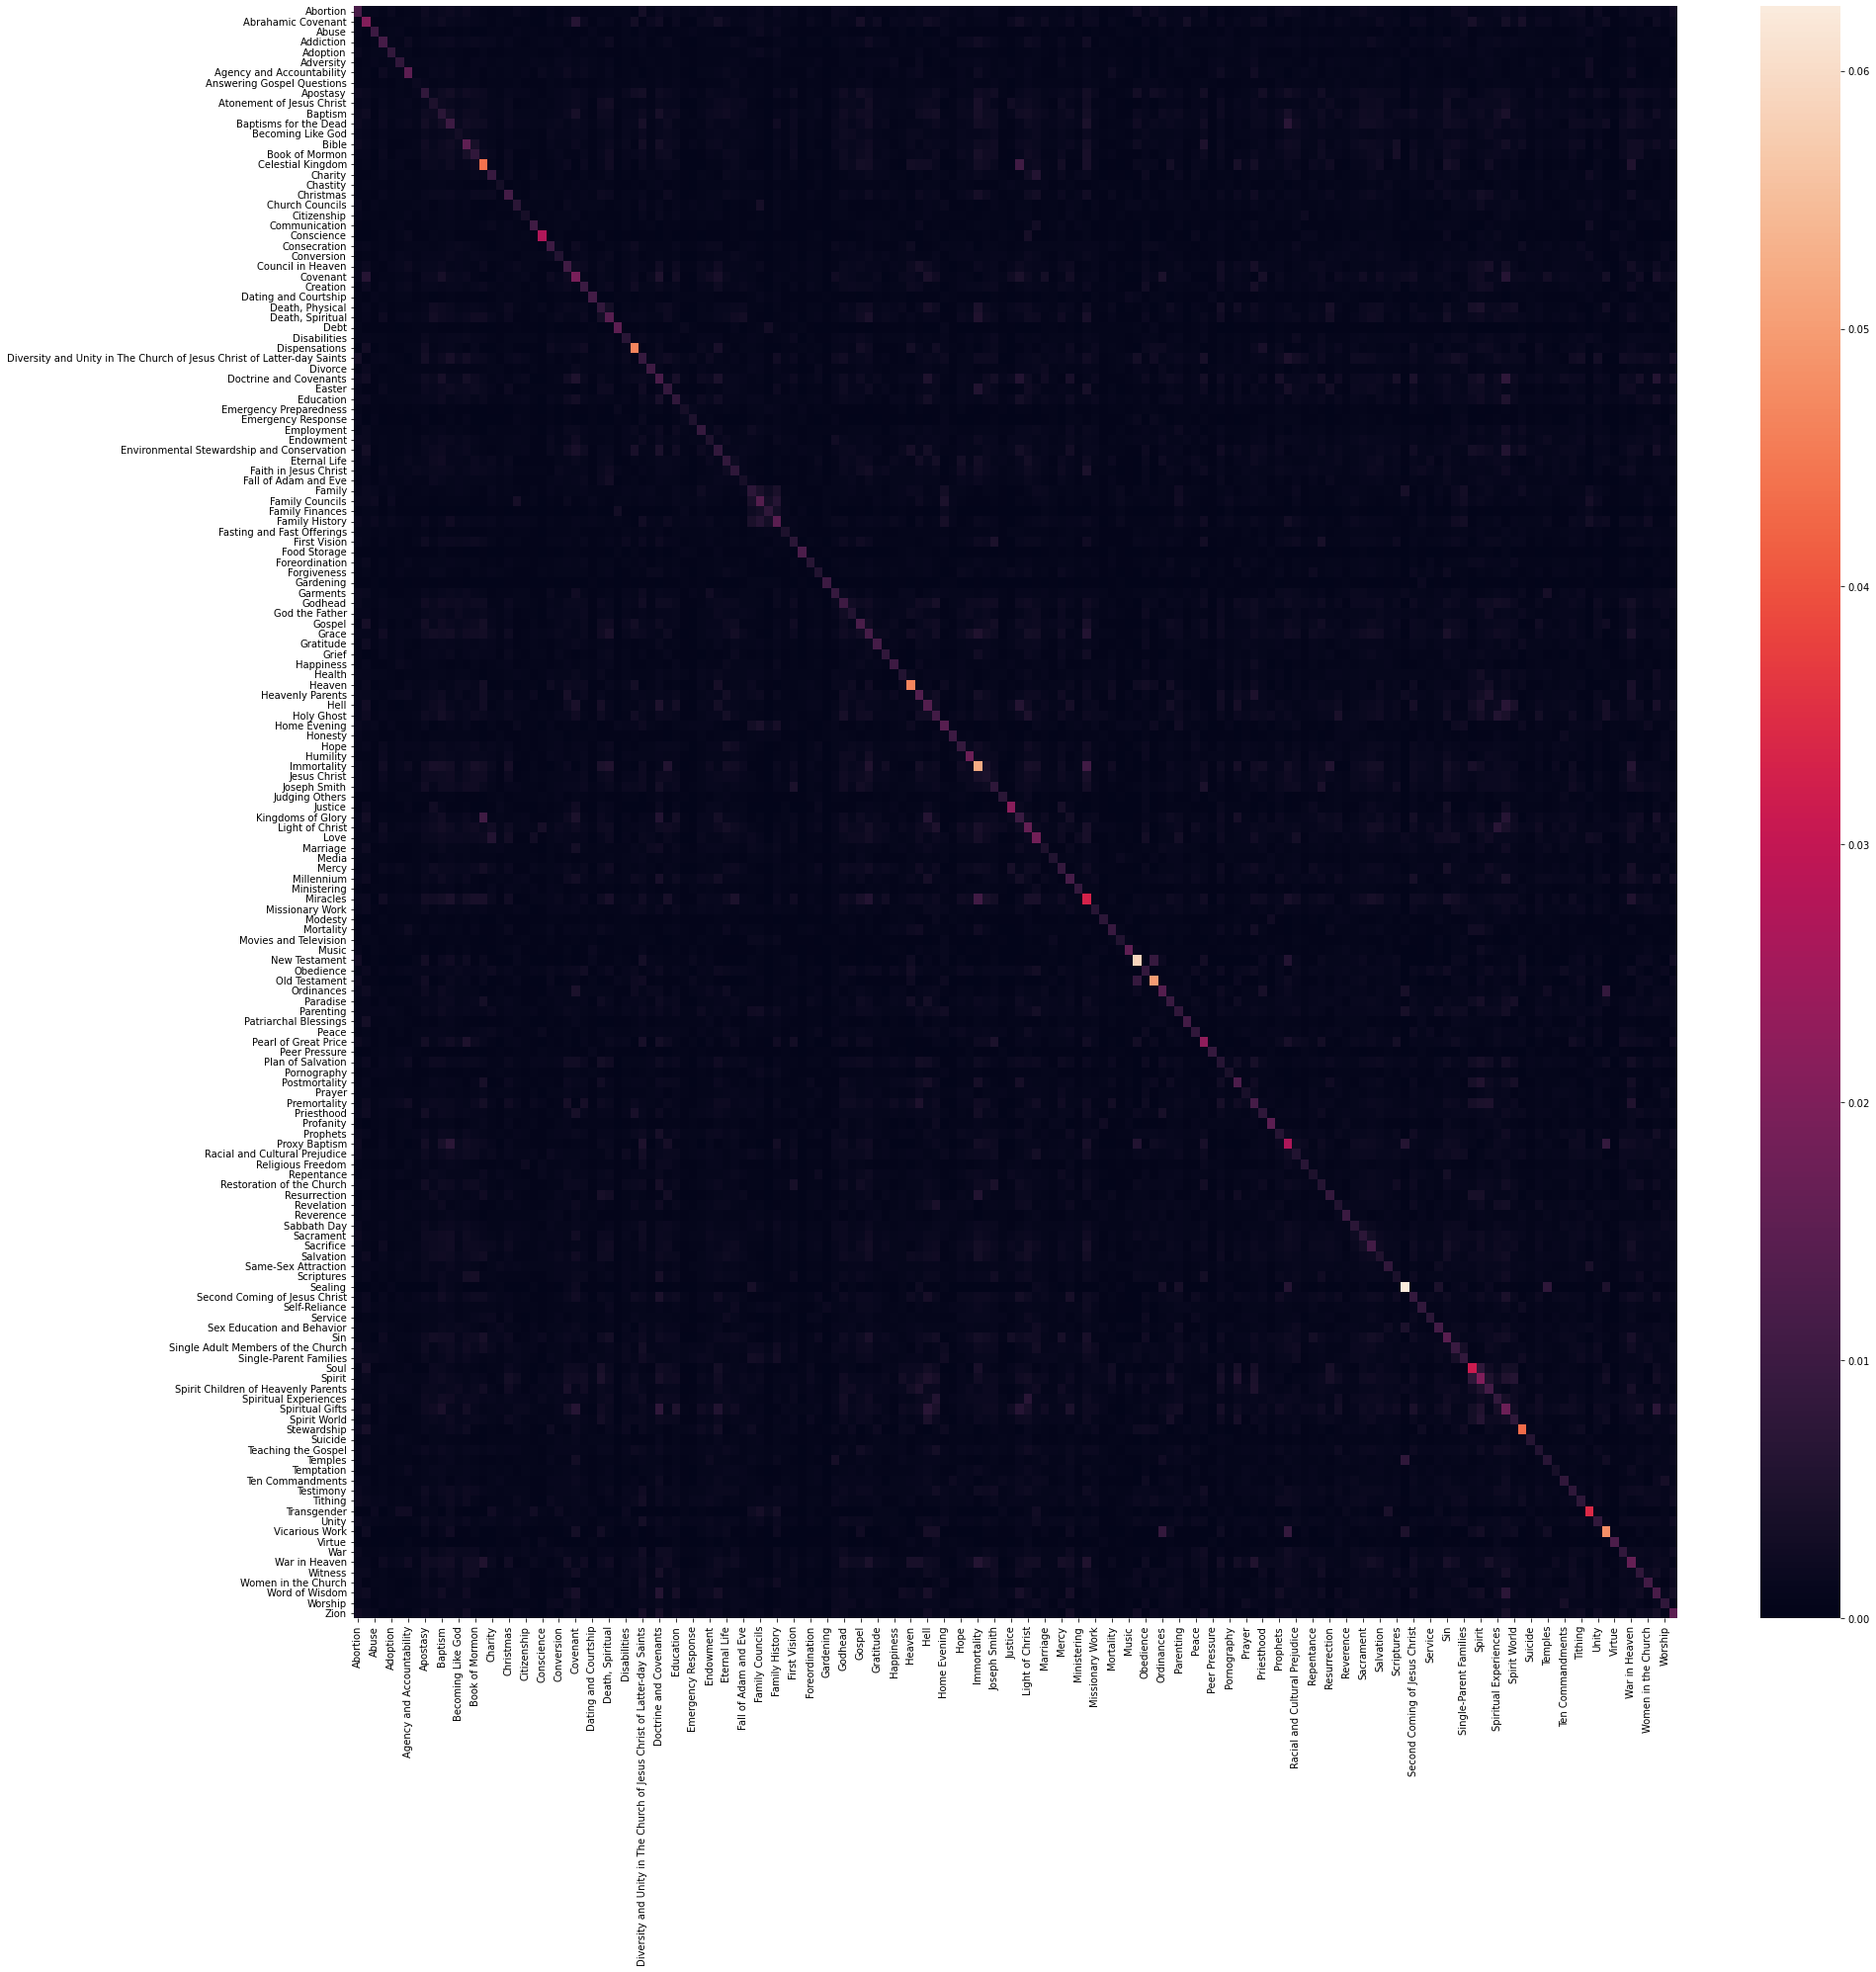

In [10]:
corr_matrix = np.matmul(dtm_labels_tf, dtm_labels_tf.transpose())
print(f"Shape of correlation matrix: {corr_matrix.shape}")

df_corr = pd.DataFrame(
    data=corr_matrix,
    index=topic_df['topic'].values,
    columns=topic_df['topic'].values
)

# Save correlation matrix
df_corr.to_csv('experiments/topic_correlations.csv')

# Display heatmap of correlation matrix
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(df_corr)
plt.show()

Alternate correlation matrix, using normalized term counts rather than plain counts.

Shape of correlation matrix: (158, 158)


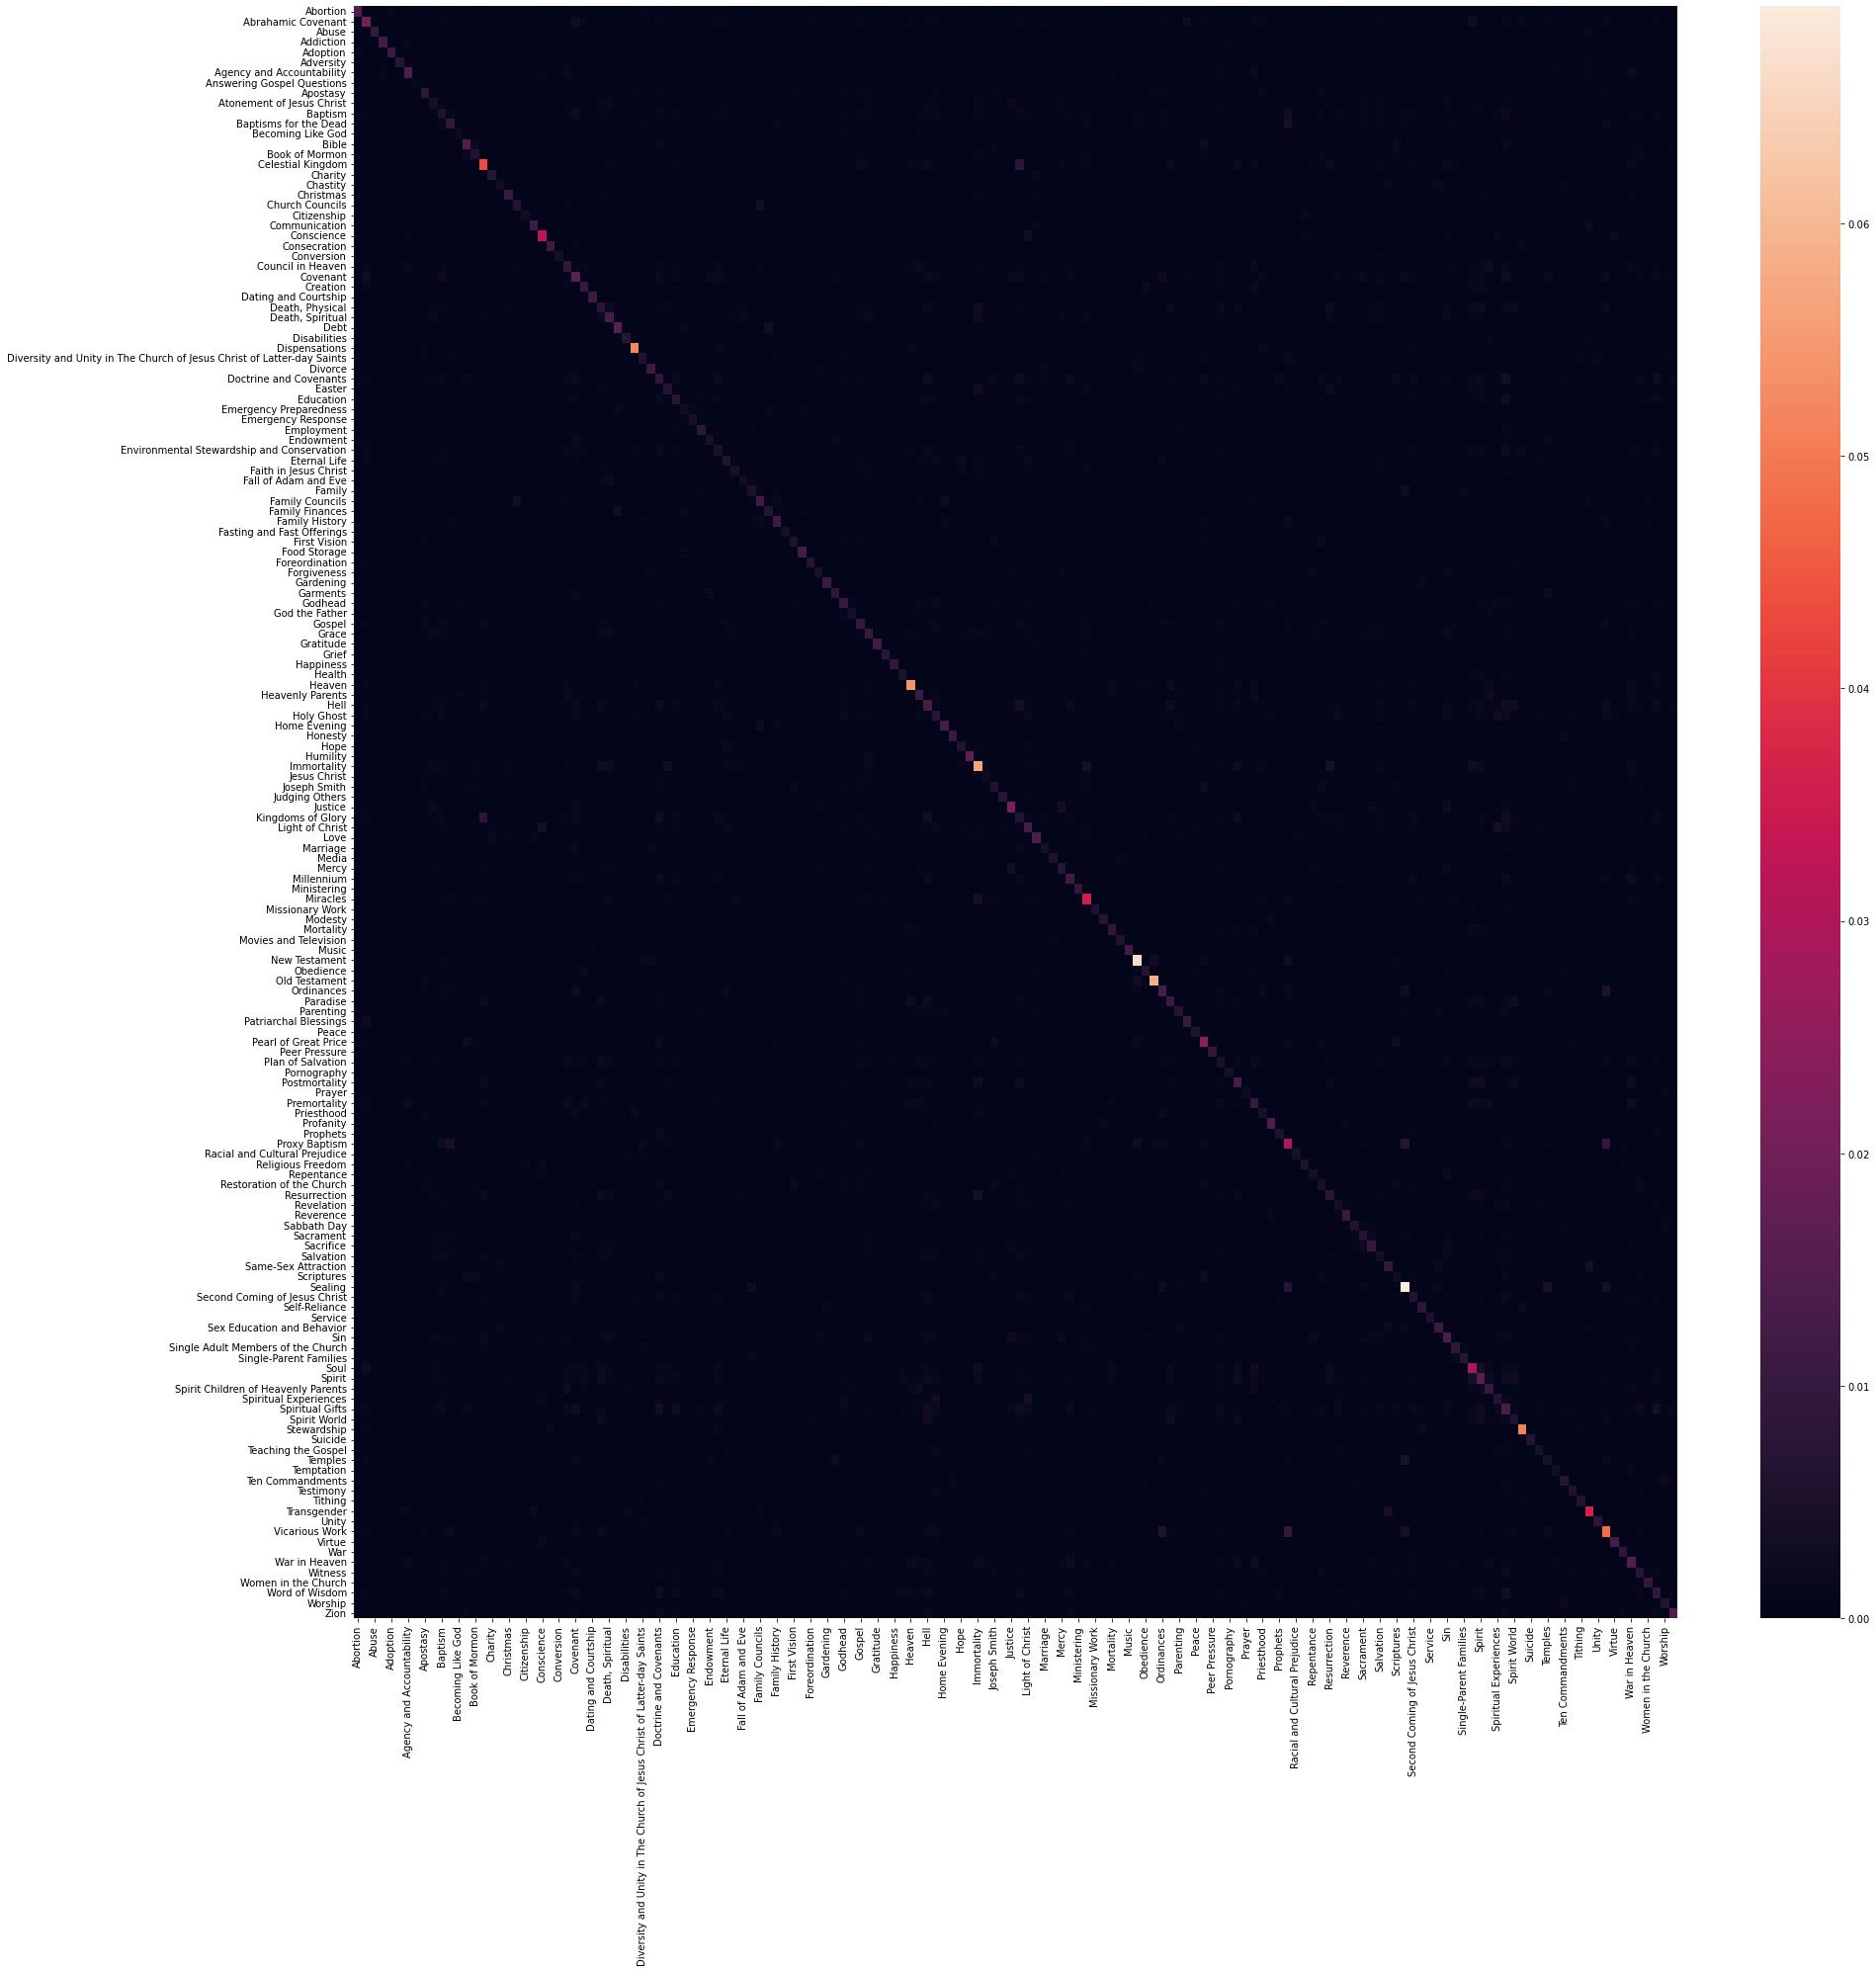

In [17]:
corr_matrix = np.matmul(dtm_labels_tfidf, dtm_labels_tfidf.transpose())
print(f"Shape of correlation matrix: {corr_matrix.shape}")

df_corr = pd.DataFrame(
    data=corr_matrix,
    index=topic_df['topic'].values,
    columns=topic_df['topic'].values
)

# Save correlation matrix
df_corr.to_csv('experiments/topic_correlations.csv')

# Display heatmap of correlation matrix
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(df_corr)
plt.show()

### Find the documents that best represent each topic
This will help with understanding how effective the topic categorization was by showing the "quintessential" documents for each topic; that is, the documents whose terms (words, ngrams) are most similar to the topic.

I'll create matrices where each row is one topic, and the columns are the similarity scores across all documents.

> **Takeaway:** The topic categorization is generally very effective, with a few exceptions for common documents that appear across multiple topics.

In [263]:
naive_tf_top_docs_per_topic = np.matmul(
    dtm_labels_tf,
    dtm_tf[:-num_topics].toarray().transpose())

naive_tfidf_top_docs_per_topic = np.matmul(
    dtm_labels_tfidf,
    dtm_tfidf[:-num_topics].toarray().transpose())

print(f"Shape of topics-docs matrix for TF: {naive_tf_top_docs_per_topic.shape}")
print(f"Shape of topics-docs matrix for TF-IDF: {naive_tfidf_top_docs_per_topic.shape}")

Shape of topics-docs matrix for TF: (161, 1000)
Shape of topics-docs matrix for TF-IDF: (161, 1000)


In [266]:
top3docs_naive_tf = pd.DataFrame(
    data = naive_tf_top_docs_per_topic.argsort()[:, : -4 : -1],
    columns = ['tf_doc1', 'tf_doc2', 'tf_doc3'],
    index = topic_df.index
).apply(
    lambda s: pd.Series([sample_df['url'].values[i] for i in s],
        index = ['tf_doc1', 'tf_doc2', 'tf_doc3']),
    axis = 1)

top3docs_naive_tfidf = pd.DataFrame(
    data = naive_tfidf_top_docs_per_topic.argsort()[:, : -4 : -1],
    columns = ['tfidf_doc1', 'tfidf_doc2', 'tfidf_doc3'],
    index = topic_df.index
).apply(
    lambda s: pd.Series([sample_df['url'].values[i] for i in s],
        index = ['tfidf_doc1', 'tfidf_doc2', 'tfidf_doc3']),
    axis = 1)

# Combine into a single DataFrame
topic_df_full = topic_df.join(
    [
        top3docs_naive_tf,
        top3docs_naive_tfidf
    ]
)

topic_df_full.to_csv('experiments/topics_naive_models.csv', index=False)

topic_df_full.head()

url               topic  \
0  https://www.churchofjesuschrist.org/study/manu...            Abortion   
1  https://www.churchofjesuschrist.org/study/manu...  Abrahamic Covenant   
2  https://www.churchofjesuschrist.org/study/manu...               Abuse   
3  https://www.churchofjesuschrist.org/study/manu...           Addiction   
4  https://www.churchofjesuschrist.org/study/manu...            Adoption   

                                                text  \
0  Abortion: See the Church’s official statement ...   
1  Abrahamic Covenant: Abraham made covenants wit...   
2  Abuse: Abuse is the mistreatment or neglect of...   
3  Addiction: Addiction is a persistent dependenc...   
4  Adoption: The scriptures teach us that God lov...   

                                             tf_doc1  \
0  https://www.churchofjesuschrist.org/study/new-...   
1  https://www.churchofjesuschrist.org/study/ensi...   
2  https://www.churchofjesuschrist.org/study/ensi...   
3  https://www.churchofjesuschrist.org/study/liah...   
4  https://www.churchofjesuschrist.org/study/ensi...   

                                             tf_doc2  \
0  https://www.churchofjesuschrist.org/study/ensi...   
1  https://www.churchofjesuschrist.org/study/ensi...   
2  https://www.churchofjesuschrist.org/study/new-...   
3  https://www.churchofjesuschrist.org/study/ensi...   
4  https://www.churchofjesuschrist.org/study/liah...   

                                             tf_doc3  \
0  https://www.churchofjesuschrist.org/study/ensi...   
1  https://www.churchofjesuschrist.org/study/ensi...   
2  https://www.churchofjesuschrist.org/study/ensi...   
3  https://www.churchofjesuschrist.org/study/new-...   
4  https://www.churchofjesuschrist.org/study/new-...   

                                          tfidf_doc1  \
0  https://www.churchofjesuschrist.org/study/ensi...   
1  https://www.churchofjesuschrist.org/study/ensi...   
2  https://www.churchofjesuschrist.org/study/liah...   
3  https://www.churchofjesuschrist.org/study/new-...   
4  https://www.churchofjesuschrist.org/study/ensi...   

                                          tfidf_doc2  \
0  https://www.churchofjesuschrist.org/study/ensi...   
1  https://www.churchofjesuschrist.org/study/ensi...   
2  https://www.churchofjesuschrist.org/study/ensi...   
3  https://www.churchofjesuschrist.org/study/liah...   
4  https://www.churchofjesuschrist.org/study/frie...   

                                          tfidf_doc3  
0  https://www.churchofjesuschrist.org/study/ensi...  
1  https://www.churchofjesuschrist.org/study/ensi...  
2  https://www.churchofjesuschrist.org/study/ensi...  
3  https://www.churchofjesuschrist.org/study/new-...  
4  https://www.churchofjesuschrist.org/study/ensi...

### Assign topic labels to documents

For matrix multiplication, `(m_rows, n_cols) x (n_rows, p_cols)` -> `(m_rows, p_cols)`

In [258]:
naive_topic_guesses_tf = np.matmul(
    dtm_tf[:-num_topics].toarray(), 
    dtm_labels_tf.transpose())

naive_topic_guesses_tfidf = np.matmul(
    dtm_tfidf[:-num_topics].toarray(), 
    dtm_labels_tfidf.transpose())

In [259]:
print(f"Topic distribution (naive method), TF: {naive_topic_guesses_tf.shape}")
print(f"Topic distribution (naive method), TF-IDF: {naive_topic_guesses_tfidf.shape}")

Topic distribution (naive method), TF: (1000, 161)
Topic distribution (naive method), TF-IDF: (1000, 161)


In [260]:
# Create DataFrames with the names of the top 3 categories 
# based on the naive implementation.
# First grab indices (array.argsort(), all rows and last three cols), 
# then translate to category names with df.apply().
top3_naive_tf = pd.DataFrame(
    data = naive_topic_guesses_tf.argsort()[:, : -4 : -1],
    columns = ['naive_tf1', 'naive_tf2', 'naive_tf3'],
    index = sample_df.index
).apply(
    lambda s: pd.Series([topic_df.at[i, "topic"] for i in s.values],
        index = ['naive_tf1', 'naive_tf2', 'naive_tf3']),
    axis = 1)

top3_naive_tfidf = pd.DataFrame(
    data = naive_topic_guesses_tfidf.argsort()[:, : -4 : -1],
    columns = ['naive_tfidf1', 'naive_tfidf2', 'naive_tfidf3'],
    index = sample_df.index
).apply(
    lambda s: pd.Series([topic_df.at[i, "topic"] for i in s.values], 
        index = ['naive_tfidf1', 'naive_tfidf2', 'naive_tfidf3']),
    axis = 1)

# Create DataFrames with the scores of the top 3 categories
# based on the naive implementation (both Term Frequency and TF-IDF)
temp_scores = naive_topic_guesses_tf.copy()
temp_scores.sort()
temp_scores = temp_scores[:, : -4 : -1]
top3_scores_naive_tf = pd.DataFrame(
    data = temp_scores,
    columns = ['naive_tf_score1', 'naive_tf_score2', 'naive_tf_score3'],
    index = sample_df.index)

temp_scores = naive_topic_guesses_tfidf.copy()
temp_scores.sort()
temp_scores = temp_scores[:, : -4 : -1]
top3_scores_naive_tfidf = pd.DataFrame(
    data = temp_scores,
    columns = ['naive_tfidf_score1', 'naive_tfidf_score2', 'naive_tfidf_score3'],
    index = sample_df.index)

In [261]:
# Merge into the sample_df DataFrame
sample_df_full = sample_df.join(
    [
        top3_naive_tf,
        top3_scores_naive_tf,
        top3_naive_tfidf,
        top3_scores_naive_tfidf
    ]
)

# Display the DataFrame
sample_df_full.head()

url  \
57430  https://www.churchofjesuschrist.org/study/frie...   
1971   https://www.churchofjesuschrist.org/study/liah...   
8299   https://www.churchofjesuschrist.org/study/liah...   
63503  https://www.churchofjesuschrist.org/study/frie...   
12976  https://www.churchofjesuschrist.org/study/liah...   

                                                    text  \
57430  Our mom made temple cards from the temple pict...   
1971   In “The Family: A Proclamation to the World,” ...   
8299   Saturday Morning, October 4, 2008, General Ses...   
63503  To find the names of colors you know,\nChange ...   
12976  To make this marble game, you will need: a car...   

                    naive_tf1          naive_tf2  naive_tf3  naive_tf_score1  \
57430                 Sealing            Temples   Garments            0.438   
1971   Single-Parent Families     Family History     Family            0.247   
8299                    Music             Virtue  Addiction            0.929   
63503                  Heaven  Articles of Faith  Profanity            0.040   
12976           New Testament          Profanity       Hell            0.118   

       naive_tf_score2  naive_tf_score3            naive_tfidf1  \
57430            0.434            0.231                 Temples   
1971             0.199            0.196  Single-Parent Families   
8299             0.702            0.664                   Music   
63503            0.036            0.032               Profanity   
12976            0.056            0.054           New Testament   

            naive_tfidf2 naive_tfidf3  naive_tfidf_score1  naive_tfidf_score2  \
57430            Sealing     Garments               0.010               0.009   
1971         Transgender     Marriage               0.018               0.012   
8299              Virtue    Christmas               0.009               0.008   
63503  Articles of Faith       Heaven               0.004               0.004   
12976  Celestial Kingdom         Hell               0.003               0.001   

       naive_tfidf_score3  
57430               0.006  
1971                0.012  
8299                0.005  
63503               0.004  
12976               0.001

## `sklearn` methods: LDA and NMF

**Takeaway:** Use NMF. MiniBatchNMF might work well for a larger set of documents, but NMF did fantastic (highly accurate categories) and completed in less time than MiniBatchNMF. LDA's topics were much less cohesive compared to NMF, but it is much faster than NMF (roughly 1/3 to 1/4 the time). The extra time for NMF is worth it.

Other things:
- For both NMF models, I used TF-IDF doc-terms matrix, since that normalizes to control for common words across all documents. In addition to stopwords, this helps bring focus to more meaningful terms.
- I set ngram_range to (1, 2) to include single words and bigrams.
- I tested setting the `max_features` parameter on the `TfidfVectorizer` to speed up processing time for NMF by limiting the number of terms in the doc-terms matrix. I set it to 5,000 to limit the terms matrix to the top-5,000 terms based on term frequency, so only those terms were used for assigning categories. This version performed much worse than the `NMF` with all features, but it was way faster (coverged at 260 iterations in about 2.5 minutes).
- I removed all words that occured in only 1 document as well as words that occured in over 95% of documents.
- Setting `verbose=1` on either NMF model will print the model's loss each iteration. Can be helpful to notice its improvement over time.
- I used the default settings for NMF except I set `init='nndsvda'`, which is the initialization strategy used for MiniBatchNMF, and is the setting that scikit-learn used in the example code comparing NMF to MiniBatchNMF and LDA.
- NMF said it reached the full 200 iterations without converging, so I could try increasing max_iter for a better result. As it is, it did fantastically well.
- I fit the models with the topics' doc-term matrix included, which probably helped the models assign categories since they had access to the full array of words, compared to if I had filtered to include only the documents from the doc-terms matrix but not the topics.
- Using my matrix-multiplication method, some topics were combined under a single label (i.e., 161 topics condensed to 98 for NMF, 92 for MiniBatchNMF, and 86 for LDA), but the word distribution shows that those topics fit well together.

### Set up models

In [102]:
lda = LatentDirichletAllocation(
    n_components = num_topics,
    n_jobs = -1,                    # set to -1 to use all available threads on the CPU cores
    # learning_method = 'online',   # set to 'online' for batch processing to increase speed when used on large datasets
    # max_iter = 20,                # default is 10
    random_state = 0
)

nmf = NMF(
    n_components = num_topics,
    random_state = 0,
    init = 'nndsvda',
    verbose = 1,    # show loss progress each iteration
    max_iter = 1000,
    # beta_loss = 'frobenius',
    # alpha_W = 0.00005,
    # alpha_H = 0.00005,
    # l1_ratio = 1
)

mini_nmf = MiniBatchNMF(
    n_components = num_topics,
    random_state = 0,
    # verbose = 1, 
    # init = 'nndsvda',
    # beta_loss = 'frobenius',
    # alpha_W = 0.00005,
    # alpha_H = 0.00005,
    # l1_ratio = 1
)

# Create NMF model for 5,000-term doc-terms matrix
nmf_5k = NMF(
    n_components = num_topics,
    random_state = 0,
    init = 'nndsvda',
    max_iter = 1000,
    verbose = 1    # show loss progress each iteration
)

# Create topic-term matrix (ttm) for term-frequency (CountVectorizer)
# and term-frequency inverse-document-frequency (TfidfVectorizer)

# Include topics when fitting the models
print("Fitting the LDA model on TF doc-terms matrix...")
t0 = time.perf_counter()
lda.fit(dtm_tf)
print(f"✅ Completed in {time.perf_counter() - t0:,.2f} seconds")

print("\nFitting the NMF model on TF-IDF doc-terms matrix...")
t0 = time.perf_counter()
nmf.fit(dtm_tfidf)
print(f"✅ Completed in {time.perf_counter() - t0:,.2f} seconds.")

print("\nFitting the MiniBatch NMF model on TF-IDF doc-terms matrix...")
t0 = time.perf_counter()
mini_nmf.fit(dtm_tfidf)
print(f"✅ Completed in {time.perf_counter() - t0:,.2f} seconds.")

print("\nFitting the NMF_5k model on TF-IDF doc-terms matrix (of top 5,000 terms)...")
t0 = time.perf_counter()
nmf_5k.fit(dtm_tfidf_5k)
print(f"✅ Completed in {time.perf_counter() - t0:,.2f} seconds.")

# Alternatively, exclude the topics when fitting the models.
# May be sub-optimal since the topics contain some of the 
# important key words that might help the models assign categories.
# lda.fit(dtm_tf[:-num_topics])
# nmf.fit(dtm_tfidf[:-num_topics])
# mini_nmf.fit(dtm_tfidf[:-num_topics])

Fitting the LDA model on TF doc-terms matrix...
✅ Completed in 103.404 seconds
Fitting the NMF model on TF-IDF doc-terms matrix...
violation: 1.0
violation: 0.18634736790086245
violation: 0.1435414294237958
violation: 0.10501192521280682
violation: 0.08377926663957845
violation: 0.07091346003315079
violation: 0.062210874989608145
violation: 0.05547379203614301
violation: 0.04996488316584742
violation: 0.044720198184328847
violation: 0.040282606780879956
violation: 0.03626953143636662
violation: 0.03312032165135409
violation: 0.029977764868467528
violation: 0.027193281049658062
violation: 0.0246142453646808
violation: 0.022565587027887964
violation: 0.02097761956479925
violation: 0.01959378777585296
violation: 0.018350240424185704
violation: 0.01743194363095484
violation: 0.016378690027955306
violation: 0.015342037453243494
violation: 0.014333089766854615
violation: 0.013413950197542789
violation: 0.012741534228390456
violation: 0.01232224168125108
violation: 0.01195925101315002
violati

c:\Users\Ryan\anaconda3\envs\stapps\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


✅ Completed in 711.539 seconds.
Fitting the MiniBatch NMF model on TF-IDF doc-terms matrix...


c:\Users\Ryan\anaconda3\envs\stapps\lib\site-packages\sklearn\decomposition\_nmf.py:2308: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


✅ Completed in 846.565 seconds.


### Assign labels to computed topics

For matrix multiplication, $(m\_rows, n\_cols) x (n\_rows, p\_cols)$ -> $(m\_rows, p\_cols)$

So, the following code uses a transposed version of the doc-terms matrix for the topics so that the columns and row dimensions align properly. Here's an example:

```python
lda.components_.shape
# -> (2, 57)
dtm_labels.transpose().shape
# -> (57, 2)
# Perform matrix multiplcation of ...
# lda_topic_guesses = lda.components_ x dtm_labels.transpose()
lda_topic_guesses.shape
# -> (2, 2)
```

In [248]:
lda_topic_guesses = np.matmul(
    lda.components_, 
    dtm_labels_tf.transpose())

nmf_topic_guesses = np.matmul(
    nmf.components_, 
    dtm_labels_tfidf.transpose())

mini_nmf_topic_guesses = np.matmul(
    mini_nmf.components_, 
    dtm_labels_tfidf.transpose())

nmf_5k_topic_guesses = np.matmul(
    nmf_5k.components_, 
    dtm_labels_tfidf_5k.transpose())

Check the shape of the topic-terms matrix -- it should be `num_topics` rows x `num_topics` columns, where each row is a topic computed by LDA and each column is the score of that topic compared to the labeled topics.

The argmax (index of the highest score) should correspond with the most likely topic for the topic computed by the LDA algorith.

In [250]:
lda_topic_guesses.shape

(161, 161)

In [251]:
print(f"LDA topics condensed to: {len(set(lda_topic_guesses.argmax(axis=1)))}")
print(f"NMF topics condensed to: {len(set(nmf_topic_guesses.argmax(axis=1)))}")
print(f"MiniBatch NMF topics condensed to: {len(set(mini_nmf_topic_guesses.argmax(axis=1)))}")
print(f"NMF_5k topics condensed to: {len(set(nmf_5k_topic_guesses.argmax(axis=1)))}")

LDA topics condensed to: 86
NMF topics condensed to: 98
MiniBatch NMF topics condensed to: 92
NMF_5k topics condensed to: 94


In [252]:
lda_topic_names = [topic_df.at[idx, 'topic'] for idx in lda_topic_guesses.argmax(axis=1)]
nmf_topic_names = [topic_df.at[idx, 'topic'] for idx in nmf_topic_guesses.argmax(axis=1)]
mini_nmf_topic_names = [topic_df.at[idx, 'topic'] for idx in mini_nmf_topic_guesses.argmax(axis=1)]
nmf_5k_topic_names = [topic_df.at[idx, 'topic'] for idx in nmf_5k_topic_guesses.argmax(axis=1)]

In [111]:
# View assigned labels for the computed topics.
# We hope to see a good amount of variety here.
lda_topic_guesses.argmax(axis=1)

array([101,  88, 143,  49, 111,  15,  88,  68,  88, 128,  51,  59,  15,
       134,   9,  51,  97,  97,  52,  86,   9, 128,  71, 129,  77, 121,
        51,   2, 160, 148,  82,  41,  97,  90, 157, 119,  71,   9,  81,
        94,  97,   9,  20,  16, 159, 141,   1, 100,  70, 145, 128, 117,
        49,  56, 138,  44,   9, 157,  73,  77,  73,   9,  12,  81,  52,
       137,   9, 111,   9, 102,  82, 137,  35,  42,   5, 110, 160, 131,
        55, 149,  71,  19,  82, 155,  29,  82,  51,  83, 111,  49, 114,
       135, 156,  71,  82,  51, 111,  81, 128,  14, 140,  51,  89,  29,
        29,  58,  59, 116, 106,  96,  39,  63, 155,  54, 112,  87, 124,
        77,  64, 157,  84,  49, 111,  82,   4,  94,  75,  92,  54,   6,
        61, 123,  97, 131,  12,  53,   9,  82,  49,  97,  35, 109,  94,
        95,  30, 138,  82,  77, 157, 111,  34,  73,  51, 157,  75,  71,
       148,  67,  97,  82,  95], dtype=int64)

View information on a topic by index number.

In [112]:
topic_df.iloc[101]

Unnamed: 0                                                  135
url           https://www.churchofjesuschrist.org/study/manu...
topic                                     Patriarchal Blessings
text          Patriarchal Blessings: Every worthy, baptized ...
Name: 101, dtype: object

#### View the top $k$ labels for each topic (by index number)

Plotting technique adapted from the scikit-learn example: [Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html)

In [113]:
label_idxs = lda_topic_guesses[0].argsort()[: -4 : -1]
topic_names = [topic_df.at[i, "topic"] for i in label_idxs]
topic_scores = np.round(lda_topic_guesses[0][label_idxs], 2)
title_text = (f"Topic {0 +1}\n"
             + "\n".join([str(i) for i in zip(topic_names, topic_scores)]))
print(title_text)

Topic 1
('Patriarchal Blessings', 6.13)
('Priesthood Blessing', 2.82)
('Abrahamic Covenant', 2.12)


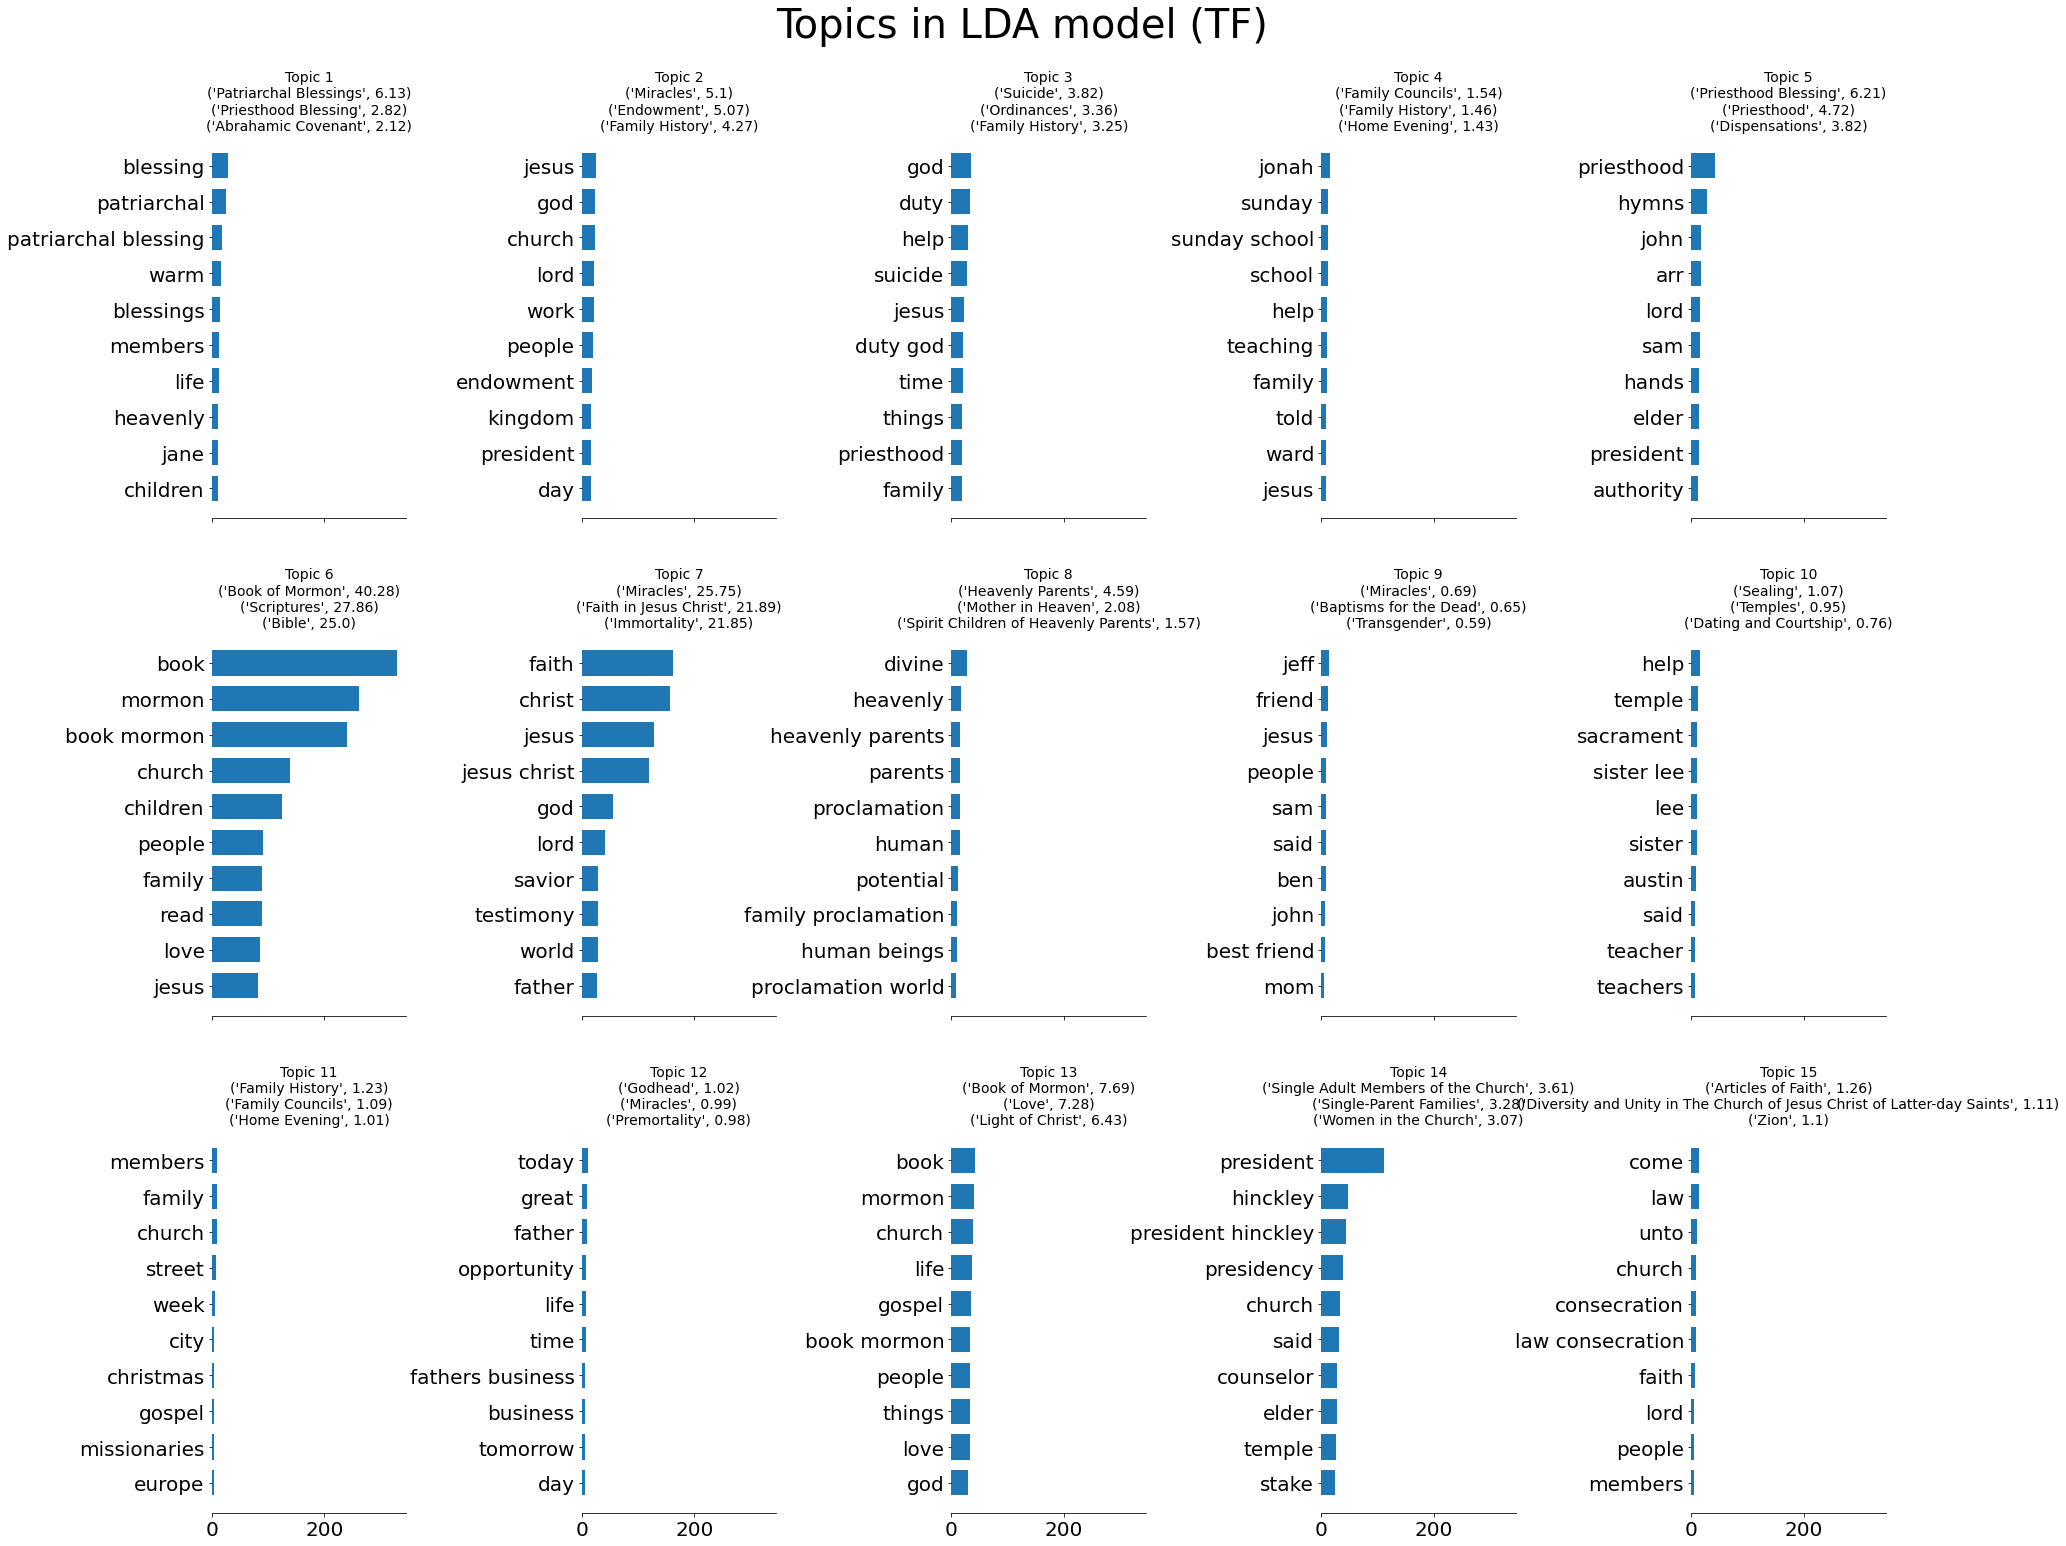

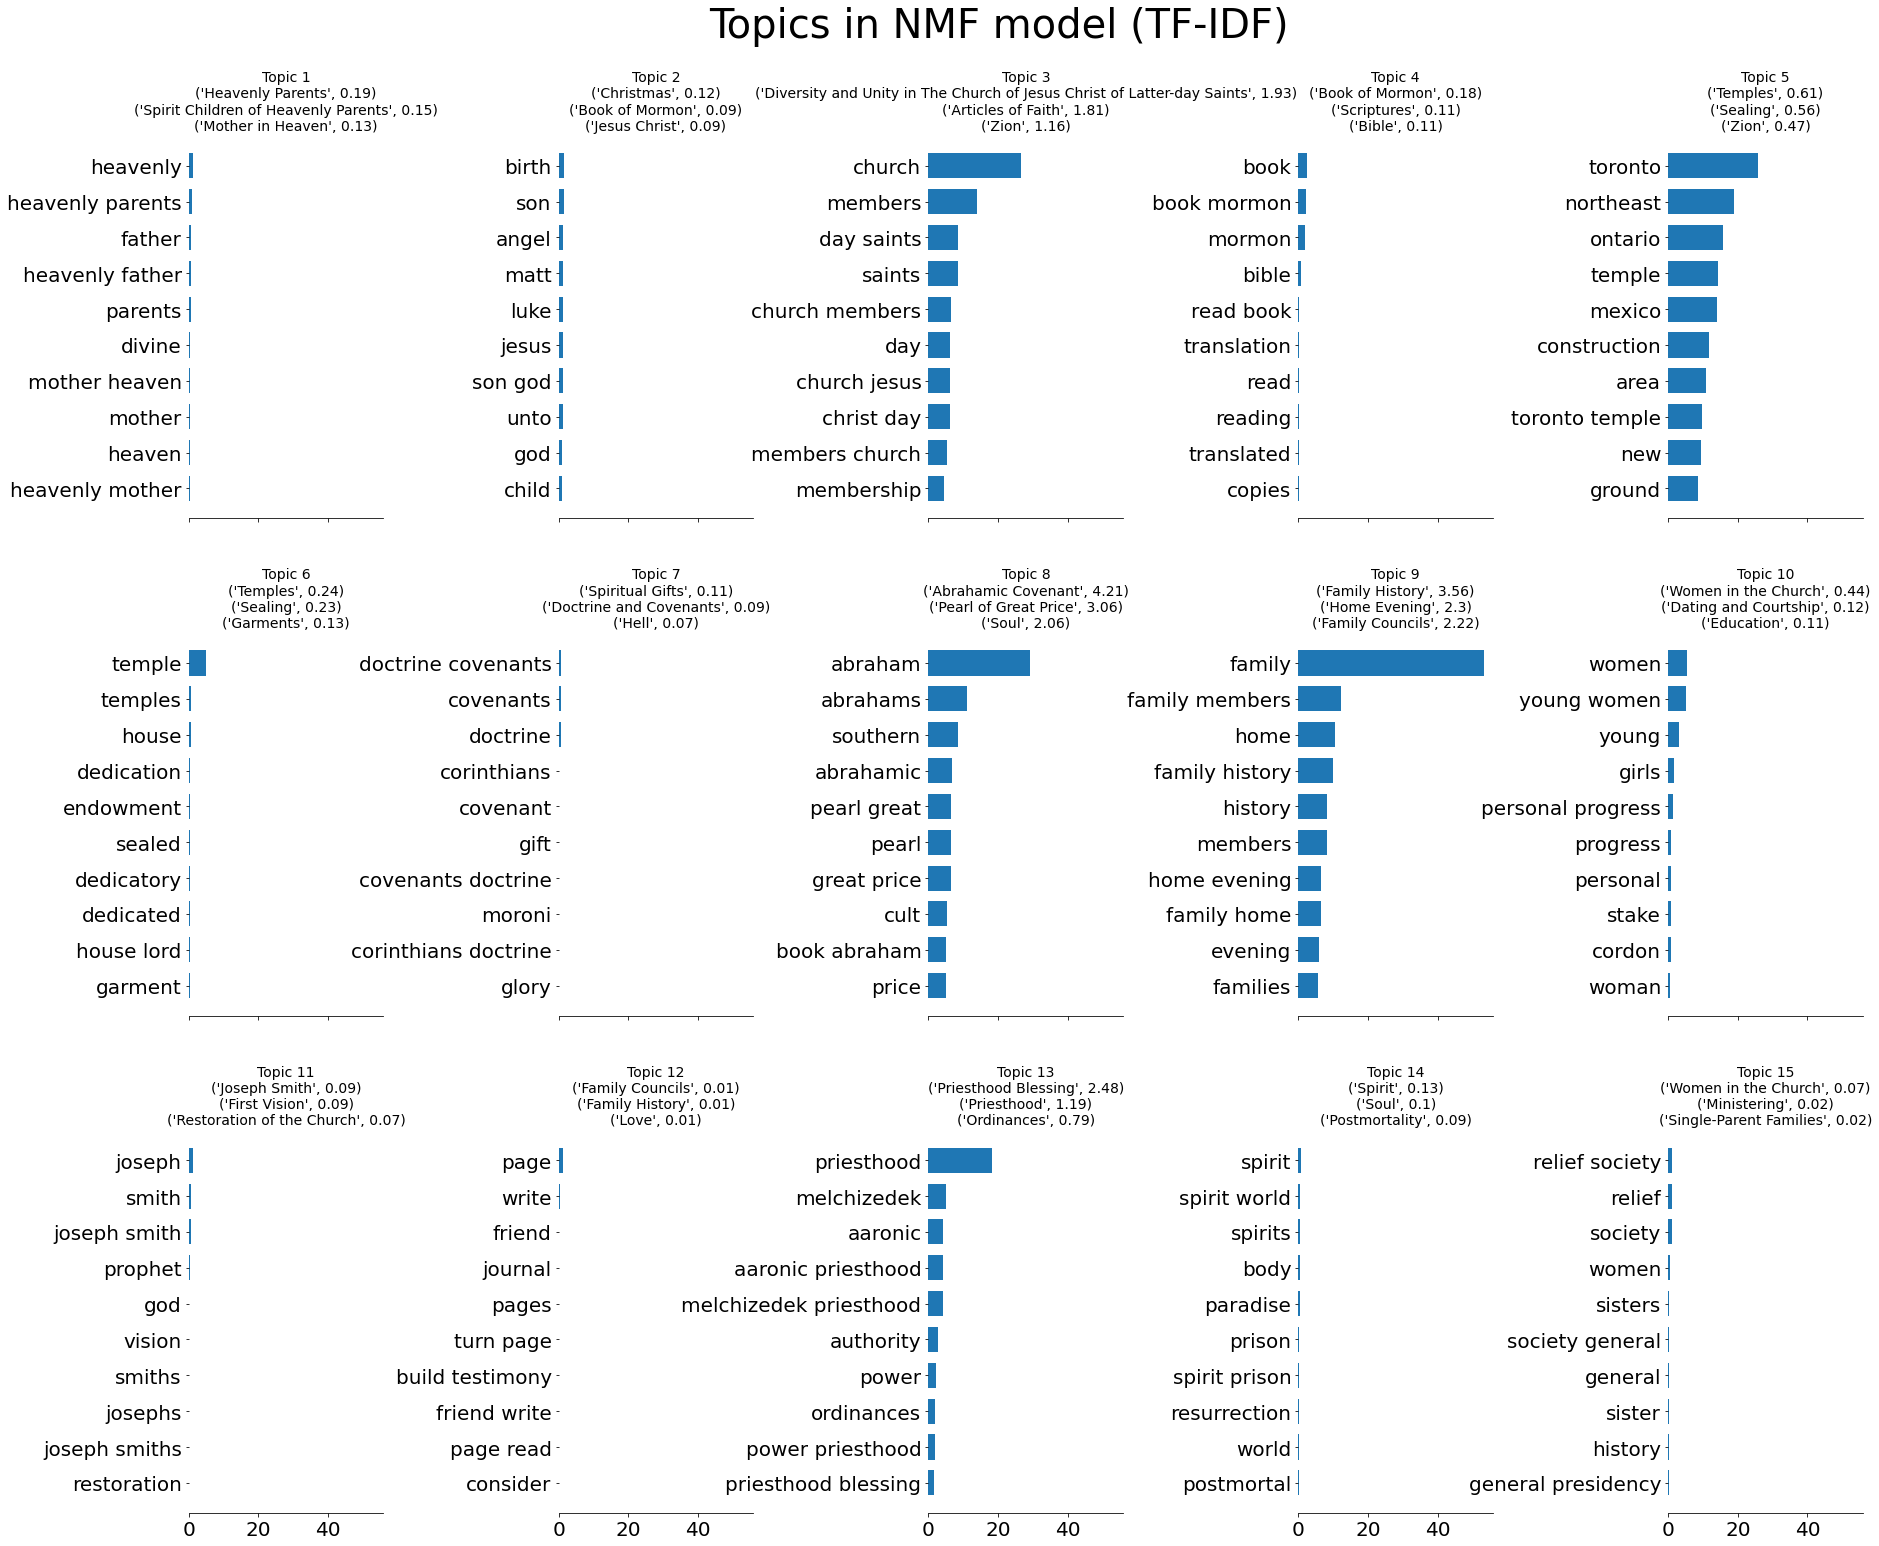

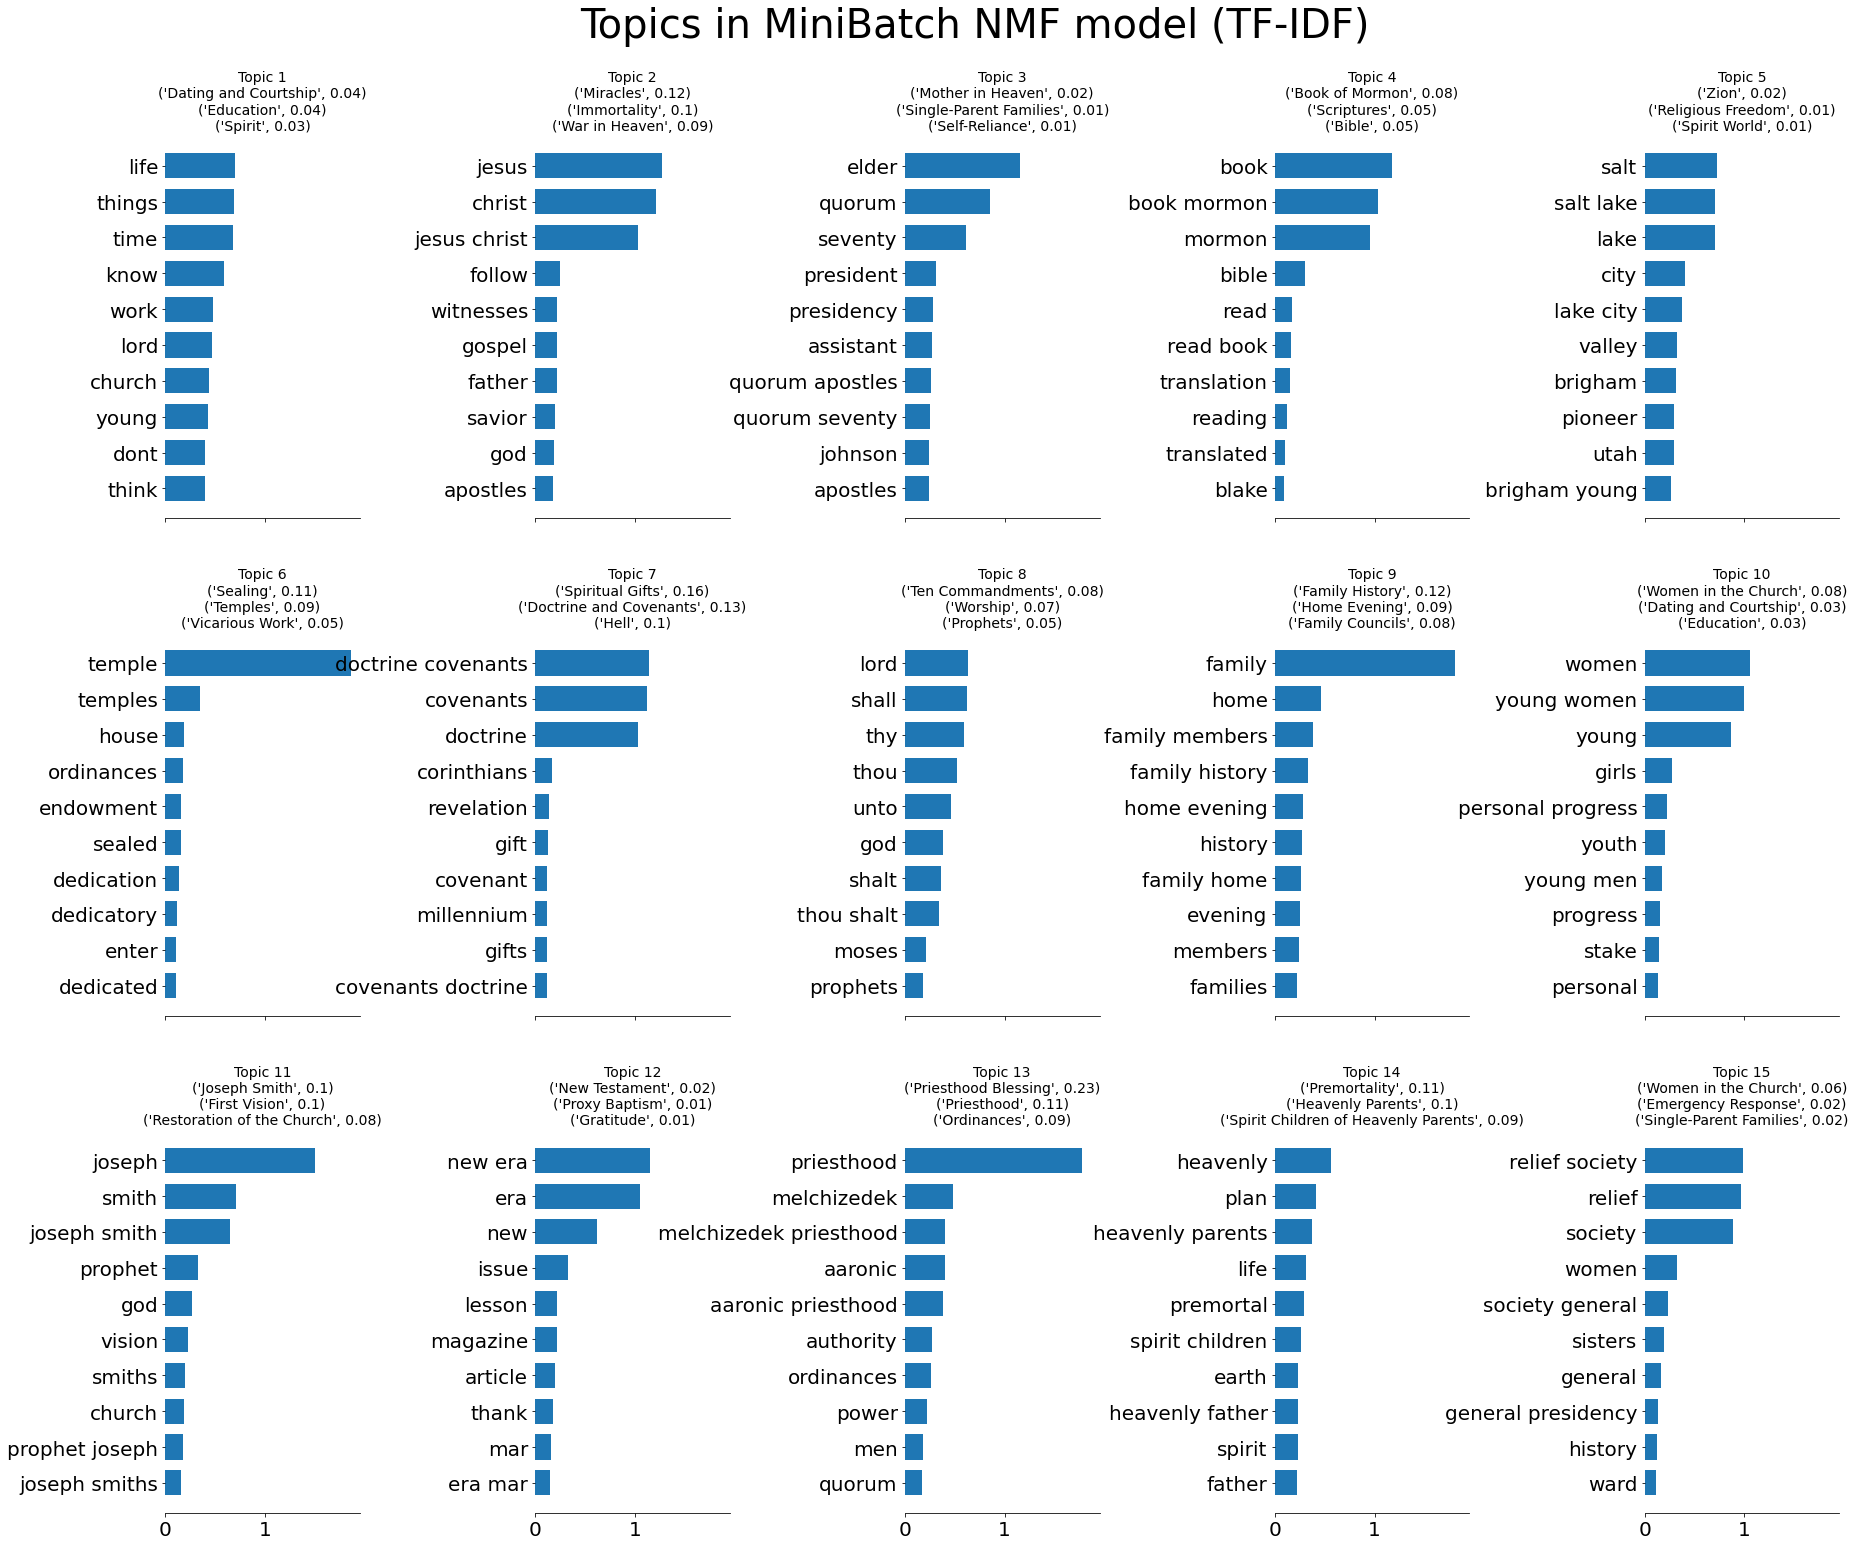

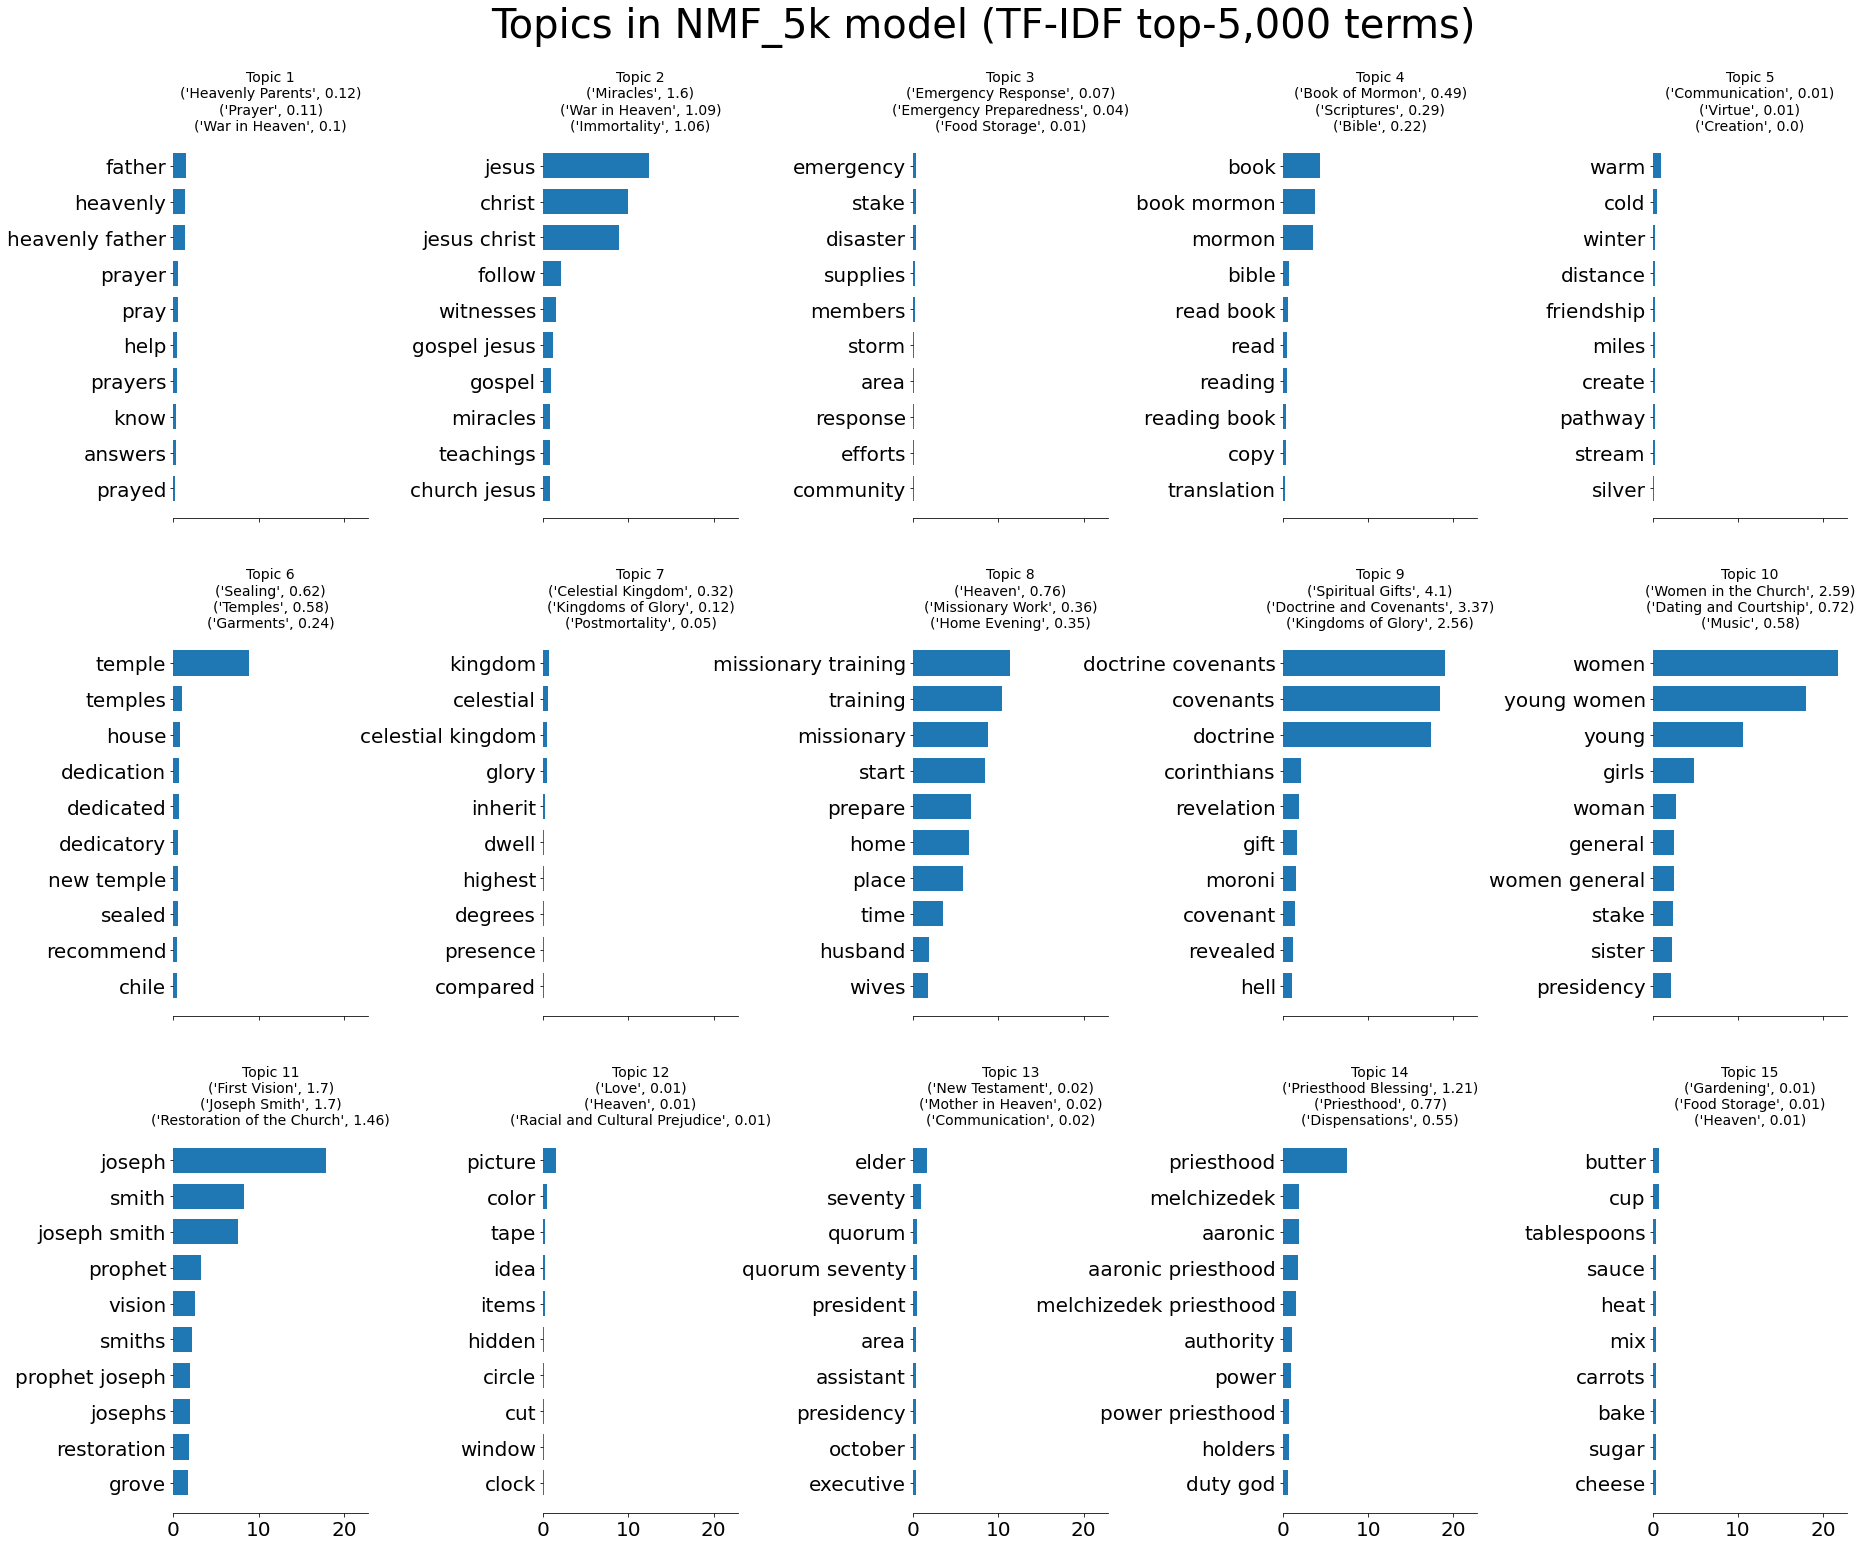

In [253]:
def plot_top_words(model, feature_names, topic_guesses, topic_labels, n_topics, n_top_words, title, randomize=False):
    cols = 5
    rows = n_topics // cols
    if rows * cols < n_topics: rows += 1
    fig, axes = plt.subplots(rows, cols, figsize=(30, 7.5 * rows), sharex=True)
    axes = axes.flatten()
    if randomize:
        idxs = random.sample(list(range(len(model.components_))), n_topics)
    else:
        idxs = [i for i in range(n_topics)]
    for topic_idx, topic in enumerate(model.components_[idxs]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)

        label_idxs = topic_guesses[topic_idx].argsort()[: -4 : -1]
        topic_names = [topic_labels[i] for i in label_idxs]
        topic_scores = np.round(topic_guesses[topic_idx][label_idxs], 2)
        title_text = (f"Topic {topic_idx +1}\n"
                    + "\n".join([str(i) for i in zip(topic_names, topic_scores)]))
        ax.set_title(title_text, fontdict={"fontsize": 14})

        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


plot_top_words(
    model = lda,
    feature_names = tf.get_feature_names_out(),
    topic_guesses = lda_topic_guesses,
    topic_labels = topic_df['topic'],
    n_topics = 15,
    n_top_words = 10,
    title = "Topics in LDA model (TF)",
    randomize = False)

plot_top_words(
    model = nmf,
    feature_names = tfidf.get_feature_names_out(),
    topic_guesses = nmf_topic_guesses,
    topic_labels = topic_df['topic'],
    n_topics = 15,
    n_top_words = 10,
    title = "Topics in NMF model (TF-IDF)",
    randomize = False)

plot_top_words(
    model = mini_nmf,
    feature_names = tfidf.get_feature_names_out(),
    topic_guesses = mini_nmf_topic_guesses,
    topic_labels = topic_df['topic'],
    n_topics = 15,
    n_top_words = 10,
    title = "Topics in MiniBatch NMF model (TF-IDF)",
    randomize = False)

plot_top_words(
    model = nmf_5k,
    feature_names = tfidf_5k.get_feature_names_out(),
    topic_guesses = nmf_5k_topic_guesses,
    topic_labels = topic_df['topic'],
    n_topics = 15,
    n_top_words = 10,
    title = "Topics in NMF_5k model (TF-IDF top-5,000 terms)",
    randomize = False)

### Save DataFrame with top labels for each topic

In [267]:
top3labels_lda = pd.DataFrame(
    data = lda_topic_guesses.argsort()[:, : -4 : -1],
    columns = ['lda_label1', 'lda_label2', 'lda_label3'],
    index = topic_df.index
).apply(
    lambda s: pd.Series([topic_df['topic'].values[i] for i in s],
        index = ['lda_label1', 'lda_label2', 'lda_label3']),
    axis = 1)
temp_scores = lda_topic_guesses.copy()
temp_scores.sort()
temp_scores = temp_scores[:, : -4 : -1]
top3labels_lda = top3labels_lda.join(
    pd.DataFrame(
        data = temp_scores,
        columns = ['lda_score1', 'lda_score2', 'lda_score3'],
        index = topic_df.index
    )
)
top3labels_lda.to_csv('experiments/lda_topic_labels.csv', index=False)


top3labels_nmf = pd.DataFrame(
    data = nmf_topic_guesses.argsort()[:, : -4 : -1],
    columns = ['nmf_label1', 'nmf_label2', 'nmf_label3'],
    index = topic_df.index
).apply(
    lambda s: pd.Series([topic_df['topic'].values[i] for i in s],
        index = ['nmf_label1', 'nmf_label2', 'nmf_label3']),
    axis = 1)
temp_scores = nmf_topic_guesses.copy()
temp_scores.sort()
temp_scores = temp_scores[:, : -4 : -1]
top3labels_nmf = top3labels_nmf.join(
    pd.DataFrame(
        data = temp_scores,
        columns = ['nmf_score1', 'nmf_score2', 'nmf_score3'],
        index = topic_df.index
    )
)
top3labels_nmf.to_csv('experiments/nmf_topic_labels.csv', index=False)


top3labels_mini_nmf = pd.DataFrame(
    data = mini_nmf_topic_guesses.argsort()[:, : -4 : -1],
    columns = ['mini_nmf_label1', 'mini_nmf_label2', 'mini_nmf_label3'],
    index = topic_df.index
).apply(
    lambda s: pd.Series([topic_df['topic'].values[i] for i in s],
        index = ['mini_nmf_label1', 'mini_nmf_label2', 'mini_nmf_label3']),
    axis = 1)
temp_scores = mini_nmf_topic_guesses.copy()
temp_scores.sort()
temp_scores = temp_scores[:, : -4 : -1]
top3labels_mini_nmf = top3labels_mini_nmf.join(
    pd.DataFrame(
        data = temp_scores,
        columns = ['mini_nmf_score1', 'mini_nmf_score2', 'mini_nmf_score3'],
        index = topic_df.index
    )
)
top3labels_mini_nmf.to_csv('experiments/mini_nmf_topic_labels.csv', index=False)


top3labels_nmf_5k = pd.DataFrame(
    data = nmf_5k_topic_guesses.argsort()[:, : -4 : -1],
    columns = ['nmf_5k_label1', 'nmf_5k_label2', 'nmf_5k_label3'],
    index = topic_df.index
).apply(
    lambda s: pd.Series([topic_df['topic'].values[i] for i in s],
        index = ['nmf_5k_label1', 'nmf_5k_label2', 'nmf_5k_label3']),
    axis = 1)
temp_scores = nmf_5k_topic_guesses.copy()
temp_scores.sort()
temp_scores = temp_scores[:, : -4 : -1]
top3labels_nmf_5k = top3labels_nmf_5k.join(
    pd.DataFrame(
        data = temp_scores,
        columns = ['nmf_5k_score1', 'nmg_5k_score2', 'nmg_5k_score3'],
        index = topic_df.index
    )
)
top3labels_nmf_5k.to_csv('experiments/nmf_5k_topic_labels.csv', index=False)


### Assign topics to documents

In [262]:
lda_doc_topics = lda.transform(dtm_tf[:-num_topics])
top3_lda = pd.DataFrame(
    data = lda_doc_topics.argsort()[:, : -4 : -1],
    columns = ['lda1', 'lda2', 'lda3'],
    index = sample_df_full.index
).apply(
    lambda s: pd.Series([lda_topic_names[i] for i in s.values],
        index=['lda1', 'lda2', 'lda3']),
    axis = 1)


nmf_doc_topics = nmf.transform(dtm_tfidf[:-num_topics])
top3_nmf = pd.DataFrame(
    data = nmf_doc_topics.argsort()[:, : -4 : -1],
    columns = ['nmf1', 'nmf2', 'nmf3'],
    index = sample_df_full.index
).apply(
    lambda s: pd.Series([nmf_topic_names[i] for i in s.values],
        index=['nmf1', 'nmf2', 'nmf3']),
    axis = 1)


mini_nmf_doc_topics = mini_nmf.transform(dtm_tfidf[:-num_topics])
top3_mini_nmf = pd.DataFrame(
    data = mini_nmf_doc_topics.argsort()[:, : -4 : -1],
    columns = ['mini_nmf1', 'mini_nmf2', 'mini_nmf3'],
    index = sample_df_full.index
).apply(
    lambda s: pd.Series([mini_nmf_topic_names[i] for i in s.values],
        index=['mini_nmf1', 'mini_nmf2', 'mini_nmf3']),
    axis = 1)


nmf_5k_doc_topics = nmf_5k.transform(dtm_tfidf_5k[:-num_topics])
top3_nmf_5k = pd.DataFrame(
    data = nmf_5k_doc_topics.argsort()[:, : -4 : -1],
    columns = ['nmf_5k_1', 'nmf_5k_2', 'nmf_5k_3'],
    index = sample_df_full.index
).apply(
    lambda s: pd.Series([nmf_topic_names[i] for i in s.values],
        index=['nmf_5k_1', 'nmf_5k_2', 'nmf_5k_3']),
    axis = 1)


# Create DataFrames with the scores of the top 3 categories
temp_scores = lda_doc_topics.copy()
temp_scores.sort()
temp_scores = temp_scores[:, : -4 : -1]
top3_scores_lda = pd.DataFrame(
    data = temp_scores,
    columns = ['lda_score1', 'lda_score2', 'lda_score3'],
    index = sample_df_full.index)

temp_scores = nmf_doc_topics.copy()
temp_scores.sort()
temp_scores = temp_scores[:, : -4 : -1]
top3_scores_nmf = pd.DataFrame(
    data = temp_scores,
    columns = ['nmf_score1', 'nmf_score2', 'nmf_score3'],
    index = sample_df_full.index)

temp_scores = mini_nmf_doc_topics.copy()
temp_scores.sort()
temp_scores = temp_scores[:, : -4 : -1]
top3_scores_mini_nmf = pd.DataFrame(
    data = temp_scores,
    columns = ['mini_nmf_score1', 'mini_nmf_score2', 'mini_nmf_score3'],
    index = sample_df_full.index)

temp_scores = nmf_5k_doc_topics.copy()
temp_scores.sort()
temp_scores = temp_scores[:, : -4 : -1]
top3_scores_nmf_5k = pd.DataFrame(
    data = temp_scores,
    columns = ['nmf_5k_score1', 'nmf_5k_score2', 'nmf_5k_score3'],
    index = sample_df_full.index)

# Combine into a single DataFrame
sample_df_full = sample_df_full.join(
    [
        top3_lda,
        top3_scores_lda,
        top3_nmf,
        top3_scores_nmf,
        top3_mini_nmf,
        top3_scores_mini_nmf,
        top3_nmf_5k,
        top3_scores_nmf_5k
    ]
)

sample_df_full.head(5)

violation: 1.0
violation: 0.8762401886936607
violation: 0.1273331557279674
violation: 0.0511004928652162
violation: 0.017132977985068288
violation: 0.006452942058229549
violation: 0.003455990409721748
violation: 0.001729607060467487
violation: 0.0007749375107091339
violation: 0.00038604040303648053
violation: 0.00022511177146774836
violation: 0.00011922370945151732
violation: 5.740986628245949e-05
Converged at iteration 14
violation: 1.0
violation: 0.8060513459407618
violation: 0.07191873958043567
violation: 0.018807534967831042
violation: 0.0066910618677336045
violation: 0.0028594685644853335
violation: 0.0010535615024101993
violation: 0.000495448317869296
violation: 0.00023496210711105537
violation: 9.897607578414332e-05
Converged at iteration 11


url  \
57430  https://www.churchofjesuschrist.org/study/frie...   
1971   https://www.churchofjesuschrist.org/study/liah...   
8299   https://www.churchofjesuschrist.org/study/liah...   
63503  https://www.churchofjesuschrist.org/study/frie...   
12976  https://www.churchofjesuschrist.org/study/liah...   

                                                    text  \
57430  Our mom made temple cards from the temple pict...   
1971   In “The Family: A Proclamation to the World,” ...   
8299   Saturday Morning, October 4, 2008, General Ses...   
63503  To find the names of colors you know,\nChange ...   
12976  To make this marble game, you will need: a car...   

                    naive_tf1          naive_tf2  naive_tf3  naive_tf_score1  \
57430                 Sealing            Temples   Garments            0.438   
1971   Single-Parent Families     Family History     Family            0.247   
8299                    Music             Virtue  Addiction            0.929   
63503                  Heaven  Articles of Faith  Profanity            0.040   
12976           New Testament          Profanity       Hell            0.118   

       naive_tf_score2  naive_tf_score3            naive_tfidf1  \
57430            0.434            0.231                 Temples   
1971             0.199            0.196  Single-Parent Families   
8299             0.702            0.664                   Music   
63503            0.036            0.032               Profanity   
12976            0.056            0.054           New Testament   

            naive_tfidf2  ...               mini_nmf3  mini_nmf_score1  \
57430            Sealing  ...  Single-Parent Families            0.409   
1971         Transgender  ...                    Soul            0.368   
8299              Virtue  ...                 Service            0.209   
63503  Articles of Faith  ...       Articles of Faith            0.164   
12976  Celestial Kingdom  ...     Priesthood Blessing            0.241   

       mini_nmf_score2  mini_nmf_score3                    nmf_5k_1  \
57430            0.035            0.031                Food Storage   
1971             0.007            0.005                Food Storage   
8299             0.115            0.042                        Hope   
63503            0.130            0.068  Fasting and Fast Offerings   
12976            0.049            0.016             Family Councils   

                  nmf_5k_2         nmf_5k_3  nmf_5k_score1  nmf_5k_score2  \
57430              Sealing        Christmas          0.217          0.040   
1971                  Love         Miracles          0.331          0.025   
8299        Foreordination    Communication          0.256          0.108   
63503  Priesthood Blessing  Missionary Work          0.156          0.085   
12976          Transgender  Family Councils          0.113          0.019   

       nmf_5k_score3  
57430          0.037  
1971           0.009  
8299           0.071  
63503          0.039  
12976          0.013  

[5 rows x 38 columns]

In [264]:
sample_df_full.to_csv('experiments/topic_model_methods.csv', index=False)

In [228]:
# Examine distribution of assigned topics

# Note that some of the topics argmaxed to the same topic label, which
# is why these counts look different than the ones in common_topics above.
print(f"Total number of topics assigned: {len(sample_df_full['nmf1'].unique())}/{num_topics} possible topics.")
sample_df_full[['url', 'nmf_label1']].groupby(by='nmf_label1').count().sort_values(by='url', ascending=False)

Total number of topics assigned: 148/161 possible topics.


url
nmf_label1                    
Atonement of Jesus Christ   31
Temptation                  28
Baptism                     21
Celestial Kingdom           21
Addiction                   20
...                        ...
Ordinances                   1
Paradise                     1
Plan of Salvation            1
Sacrament                    1
Millennium                   1

[148 rows x 1 columns]

# Experiment: topic visualization with `pyLDAvis`

What I learned:
- Some preprocessing may be necessary (e.g., removing digits, expanding contractions like _we're_ to _we are_)
- Normalizing terms through TF-IDF performs worse than standard term counts; possibly because so many of the documents reference related information, since the magazines share a common topic: Christianity. TF-IDF appears to overweight noise in the dataset (like numbers)
- NMF appears to perform much better than LDA at generating perceptually good topics (i.e., topics are distinct from one another and words within a topic are related)

Import required packages for this section

In [ ]:
# Built-in packages
import re                       # text-based pattern matching
import unicodedata              # Unicode character reference (database on character properties)
                                # for normalizing characters. See also unicodedata2: https://pypi.org/project/unicodedata2/
# import unidecode                # Normalizing (transliterating) unicode to ascii; third-party package

# Third-party packages
import numpy as np              # array-based data storage and computation
import pandas as pd             # tabular data analysis
import pyLDAvis                 # visualization for LDA topics

# scikit-learn classes
from sklearn.feature_extraction.text import CountVectorizer     
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF, MiniBatchNMF

# Explanation of sklearn imports
# ``````````````````````````````
# CountVectorizer: Convert documents (text strings) to vectors 
# representing the number of times a word or n-gram 
# appeared in each document

# TfidfVectorizer: Convert documents to vectors representing the number
# of times a normalized word or n-gram appeared in each document
# where words are normalized by Term-frequency x Inverse-document-frequency

# LatentDirichletAllocation: Assign topics to documents after the 
# documents have been processed into vectors (i.e., the document-term matrix 
# output by CountVectorizer or TfidfVectorizer)

# NMF and MiniBatchNMF: Assign topics to documents after the documents 
# have been processed and normalized (i.e., by TfidfVectorizer). Time
# complexity increases in polynomial time with respect to the number
# of inputs, so the MiniBatchNMF can perform much faster for large datasets.

# set_config: Disable HTML display of sklearn objects;
# this way, the text representation is returned
# when an object's __repr__ method is called, like
# when that object is on the last line in a code cell.
from sklearn import set_config
set_config(display='text')

In [ ]:
# Set the number of words to include in n-grams (e.g., 2 for bigrams)
NGRAMS = 2
MAX_DOC_FREQ = 0.5
MIN_DOC_FREQ = 0.02

count_vectorizer = CountVectorizer(
    strip_accents = 'unicode',
    ngram_range = (1, NGRAMS),
    max_df = MAX_DOC_FREQ,
    min_df = MIN_DOC_FREQ,
    stop_words='english'
)

tfidf_vectorizer = TfidfVectorizer(**count_vectorizer.get_params())

In [ ]:
sample_df = pd.read_csv('data/article_text.csv').dropna().sample(n=1000, random_state=0)

In [ ]:
sample_df.isna().sum()

url     0
text    0
dtype: int64

In [ ]:
import time
t0 = time.perf_counter()

doc_terms_matrix = count_vectorizer.fit_transform(sample_df['text'])
t1 = time.perf_counter()

tfidf_doc_terms_matrix = tfidf_vectorizer.fit_transform(sample_df['text'])
t2 = time.perf_counter()

print(f"Time for CountVectorizer: {t1-t0:.6f}s")
print(f"Time for TfidfVectorizer: {t2-t1:.6f}s")

c:\Users\Ryan\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


Time for CountVectorizer: 2.948595s
Time for TfidfVectorizer: 3.327715s


In [ ]:
doc_terms_matrix.shape

(1000, 2557)

In [ ]:
tfidf_doc_terms_matrix.shape

(1000, 2557)

Latent Dirichlet Allocation for standard word counts (doc-terms matrix from CountVectorizer)

In [ ]:
lda_tf = LatentDirichletAllocation(
    n_components=10,
    learning_method='online',
    n_jobs=-1,
    max_iter=20,
    random_state=0)
lda_tf.fit(doc_terms_matrix)

LatentDirichletAllocation(learning_method='online', max_iter=20, n_jobs=-1,
                          random_state=0)

In [ ]:
for i, topic in enumerate(lda_tf.components_):
    words = [count_vectorizer.get_feature_names_out()[j] for j in topic.argsort()[-10:]]
    print(f"Top words for topic {i}: {words}")

Top words for topic 0: ['don', 'father', 'little', 'know', 'good', 'mom', 'didn', 'like', 'just', 'said']
Top words for topic 1: ['people', 'world', 'gospel', 'faith', 'know', 'things', 'love', 'life', 'lord', 'god']
Top words for topic 2: ['hymn', 'president thomas', 'general conference', 'thomas monson', 'general', 'thomas', 'monson', 'hymns', 'music', 'conference']
Top words for topic 3: ['missionary', 'stake', 'says', 'ward', 'members', 'president', 'quorum', 'missionaries', 'mission', 'elder']
Top words for topic 4: ['saints', 'new', 'salt lake', 'president', 'lake', 'city', 'salt', 'people', 'members', 'temple']
Top words for topic 5: ['pray', 'page', 'feel', 'help', 'picture', 'usa', 'paper', 'age', 'like', 'friend']
Top words for topic 6: ['youth', 'young women', 'relief society', 'men', 'society', 'relief', 'president', 'women', 'young', 'priesthood']
Top words for topic 7: ['president', 'home', 'said', 'father', 'brother', 'years', 'lord', 'smith', 'young', 'joseph']
Top word

In [ ]:
import pyLDAvis.sklearn
pyLDAvis.display(pyLDAvis.sklearn.prepare(lda_tf, doc_terms_matrix, count_vectorizer))

c:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Ryan\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
# Using the tSNE visualization rather than the default PCoA
pyLDAvis.display(pyLDAvis.sklearn.prepare(lda_tf, doc_terms_matrix, count_vectorizer, mds='tsne'))

c:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Ryan\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
c:\Users\Ryan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Ryan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Ryan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square

Latent Dirichlet Allocation using Term-Frequency Inverse-Document-Frequency (doc-terms matrix from TfidfVectorizer)

In [ ]:
lda_tfidf = LatentDirichletAllocation(
    n_components=10,
    learning_method='online',
    n_jobs=-1,
    max_iter=20,
    random_state=0)
lda_tfidf.fit(tfidf_doc_terms_matrix)

LatentDirichletAllocation(learning_method='online', max_iter=20, n_jobs=-1,
                          random_state=0)

In [ ]:
for i, topic in enumerate(lda_tfidf.components_):
    print(f"Top words for topic {i}:")
    print([tfidf_vectorizer.get_feature_names_out()[j] for j in topic.argsort()[-10:]])

Top words for topic 0:
['help', 'temple', 'life', 'children', 'jesus', 'father', 'said', 'lord', 'god', 'family']
Top words for topic 1:
['today', 'peace', 'know', 'girl', 'ward', 'names', 'share gospel', 'long time', 'eternity', 'answers']
Top words for topic 2:
['choose', 'children', 'priesthood', 'inside', 'liahona', 'david', 'sunday', 'man', 'family', 'hymns']
Top words for topic 3:
['felt', 'abraham', 'youth', 'family', 'know', 'dad', 'friends', 'said', 'grandma', 'mom']
Top words for topic 4:
['christ', 'gave', 'block', 'discover', 'way', 'open', 'temple', 'commandment', 'jesus', '00']
Top words for topic 5:
['children', 'missionaries', 'gospel', 'paper', 'picture', 'circle', 'utah', 'items', 'hidden', 'ages']
Top words for topic 6:
['like', 'jesus', 'set', 'read', 'things', 'life', 'words', 'gifts', 'said', 'father']
Top words for topic 7:
['100', 'bright', 'hymns', 'president', 'words', 'just', 'spanish', 'english', 'class', 'letter']
Top words for topic 8:
['large', 'council',

In [ ]:
pyLDAvis.display(pyLDAvis.sklearn.prepare(lda_tfidf, tfidf_doc_terms_matrix, tfidf_vectorizer))

c:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Ryan\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
# Visualization using tSNE rather than the default PCoA
pyLDAvis.display(pyLDAvis.sklearn.prepare(lda_tfidf, tfidf_doc_terms_matrix, tfidf_vectorizer, mds='tsne'))

c:\Users\Ryan\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Ryan\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
c:\Users\Ryan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Ryan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Ryan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square

# Experiment: grid search over potential parameters
What I learned:
- For `LatentDirichletAllocation`, the algorithm seems to prefer fewer topics (i.e., the lowest `n_components` seemed to win: 20 in the first run with (20, 50, 100) as options and 10 in the second run with (10, 20) as options).
- For `LatentDirichletAllocation`, a higher `max_iter` returned a better score (I tried 10 and 20; 20 was better)
- For `CountVectorizer`, `stopwords='english'` performed better
- For `CountVectorizer`, `preprocessor=preprocess_text` performed better (i.e., my custom function to normalize the text and remove non-alphanumeric characters)
- For `CountVectorizer`, `strip_accents='unicode'` performed better
- For `CountVectorizer`, lower values of `max_df` performed better (I tried 0.5, 0.7, and 0.9, and 0.5 won)
- For `CountVectorizer`, higher values of `min_df` performed better (I tried 0.01 and 0.02 and 0.02 won)

Set up pipeline and grid search. See: [Sample pipeline for text feature extraction and evaluation](https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html) from scikit-learn's examples.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import os

sample_df = pd.read_csv('data/article_text.csv').dropna().sample(n=1000, random_state=0)

pipe = Pipeline(
    [
        ("dtm", CountVectorizer()),
        ("lda", LatentDirichletAllocation())
    ],
    verbose=True
)

parameters = {
    # "dtm__strip_accents": (None, 'unicode', 'ascii'),
    "dtm__ngram_range": [(1, 2)], # (1, 3)),
    "dtm__max_df": [0.5], # (0.5, 0.7, 0.9),
    "dtm__min_df": (0.01, 0.02),
    "dtm__stop_words": ['english'], # ('english', None),
    "dtm__preprocessor": (None, preprocess_text),
    "lda__n_components": (10, 20, 50), # (20, 50, 100),
    "lda__max_iter": [20], # (10, 20),
    "lda__learning_method": ['online']
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=parameters,
    n_jobs=-1,
    verbose=2)

grid_search.fit(sample_df['text'])

print(f"Best score: {grid_search.best_score_:.3f}")
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

# Save results
test_num = 1
save_fp = f"data/grid_test_results{test_num}.csv"
while os.path.exists(save_fp):
    test_num += 1
    save_fp = f"data/grid_test_results{test_num}.csv"

pd.DataFrame(grid_search.cv_results_).to_csv(save_fp, index=False)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Pipeline] ............... (step 1 of 2) Processing dtm, total=   3.1s
[Pipeline] ............... (step 2 of 2) Processing lda, total=  29.4s
Best score: -409941.156
Best parameters set:
	dtm__max_df: 0.5
	dtm__min_df: 0.02
	dtm__ngram_range: (1, 2)
	dtm__preprocessor: <function preprocess_text at 0x000001BF07ABF5E0>
	dtm__stop_words: english
	lda__learning_method: online
	lda__max_iter: 20
	lda__n_components: 10


In [ ]:
print(f"Best score: {grid_search.best_score_:.3f}")
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Best score: -642275.409
Best parameters set:
	dtm__max_df: 0.5
	dtm__preprocessor: None
	dtm__stop_words: english
	dtm__strip_accents: unicode
	lda__learning_method: online
	lda__max_iter: 20
	lda__n_components: 20


In [ ]:
# Display HTML diagram of the grid search
# See: https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_pipeline_display.html

from sklearn import set_config
set_config(display='diagram')
grid_search

# Return to normal
set_config(display='text')

GridSearchCV(estimator=Pipeline(steps=[('dtm', CountVectorizer()),
                                       ('lda', LatentDirichletAllocation())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'dtm__max_df': (0.5, 0.7, 0.9),
                         'dtm__preprocessor': (None,
                                               <function preprocess_text at 0x000001BF02F46550>),
                         'dtm__stop_words': ('english', None),
                         'dtm__strip_accents': (None, 'unicode', 'ascii'),
                         'lda__learning_method': ['online'],
                         'lda__max_iter': (10, 20),
                         'lda__n_components': (20, 50, 100)},
             verbose=2)